# To make the Synthetic Specturm that will be used to test what the best detrending techniques are.
### Things included in this notebook:
### 1) Therorized transmission spectrum

### 2) code to make synthetic data (including errors and comparison stars) with the true data as a template (i.e. same timestamps and similar binning scheme)

##### ==========================  EXTRA ========================== #####

### 3) code to make plots of the distribution of data given diffrernt detrending techniques

### 4) code to view the raw light curves of the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import glob
import astropy.io.fits as fits
from scipy.stats import chisquare
import sys
# import batman
#to plot without doing show plot
%matplotlib inline
#for interactive plots
# %matplotlib notebook

### 1) create transmission spectra for WASP31b: 
### Used https://bd-server.astro.ex.ac.uk/exoplanets/WASP-31/ to do so. 

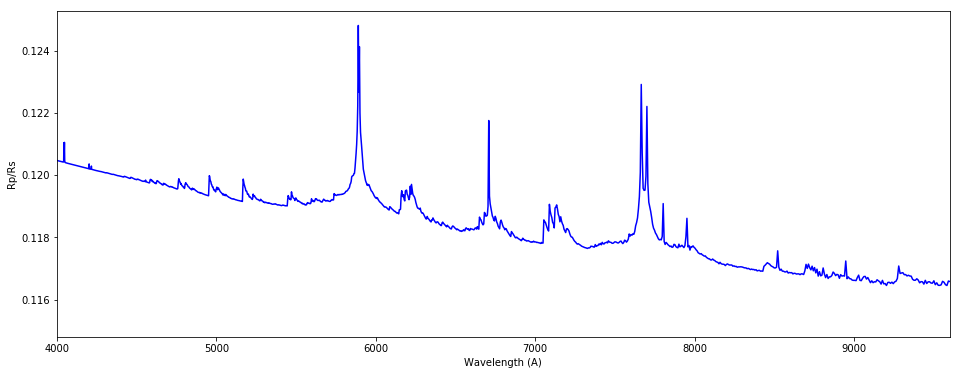

In [2]:
#start of rayScat: 2500 4000.80016, end of rayScat: 3000 5001.250312599999
#start of Na:
TranFile = 'TranSpec_WASP31_1.txt'
Wav, Depth = np.loadtxt(TranFile, unpack = True)
Wav = Wav*1e4 #convert to angstroms
Depth = np.sqrt(Depth) #convert to Rp/Rs
plt.figure(0, figsize = (16,6))
plt.plot(Wav, Depth,'b')
# plt.ylim(0.116,0.1251)
plt.xlim(4000,9600)
plt.xlabel('Wavelength (A)')
plt.ylabel('Rp/Rs')
plt.show()

Use same binning scheme that will use in real data. For this example just imported binning file used for first night of observations

In [3]:
BinFile1 = 'w31_114_Ob1.dat'
# BinFile2 = 'w31_114_Ob2.dat'
# BinFile3 = 'w31_114_Ob3.dat'
bnB, bnT = np.loadtxt(BinFile1, unpack = True)

Next, is a function that averages the wavelength bins and the transit depths based on bin size of given .dat file

In [4]:
#bins needs to be in formate of upper wavelength of bin in 1st column and lower wavelength in 2nd
def bin_exotransmit_model(exotransmit_wvl,exotransmit_flux,wvl_bins_file):
    BinUp, BinDn = np.loadtxt(wvl_bins_file, unpack = True)
    BinnedWaves = np.array([])
    BinnedRpRs = np.array([])
    for i in range(len(BinUp)):
        b = np.where((exotransmit_wvl > BinUp[i])&(exotransmit_wvl < BinDn[i]))
        binWav = exotransmit_wvl[b]
        binRpRs = exotransmit_flux[b]
        BinnedWaves = np.append(BinnedWaves, np.mean(binWav))
        BinnedRpRs = np.append(BinnedRpRs, np.mean(binRpRs))
    return BinnedWaves, BinnedRpRs

In [5]:
Binns, RpRss = bin_exotransmit_model(Wav,Depth,'w31_114_Ob3.dat')

Downloading the Rp/Rs error bars from our best fit model. We will use this to make realistic error bars for our synthetic data

In [6]:
transpec1 = '/Users/chimamcgruder/SSHFS/Copy0/GPTransmissionSpectra/outputs/WASP31/ut130226/LC114/BstPar/transpec.dat'
# transpec2 = '/Users/chimamcgruder/Hydra/Copy0/GPTransmissionSpectra/outputs/WASP31/ut130425/LCs114/AllCmp/transpecNoComments.dat'
# transpec3 = '/Users/chimamcgruder/Hydra/Copy0/GPTransmissionSpectra/outputs/WASP31/ut140222/LCs114/AllCps/transpecNoComments.dat'
def ReadTranSpec(FilePath):
    txt = open(FilePath, 'r')
    bin_mean = []
    R_ErrUp = []
    R_ErrDwn = []
    R_ErrUp2 = []
    R_ErrDwn2 = []
    RpRs = []
    for line in txt:
        if line.startswith('#'):
            pass
        else:
            numb = line.split()
            Bmean = (float(numb[0]) + float(numb[1]))/2.0
            bin_mean.append(Bmean) #just need the mean so that's the only thing I'm returning as of now
            RpRs.append(float(numb[2]))
            R_ErrUp.append(float(numb[3]))
            R_ErrDwn.append(float(numb[4]))
            R_ErrUp2.append(float(numb[6])/1e6)
            R_ErrDwn2.append(float(numb[7])/1e6)
    return bin_mean, RpRs, R_ErrUp, R_ErrDwn, R_ErrUp2, R_ErrDwn2
BinMean, RpRsUp, RpRsErrUp, RpRsErrDwn, RpRsErrUp2, RpRsErrDwn2 = ReadTranSpec(transpec1)

This function is to pull out the raw transmission spectrum from the .fits files. This is only needed to get the average flux for each star. I prefer using this over the lightcurves from the .pkl files because these bins you can determine after the fact

In [4]:
# Bad_frames = [49,143,148,212,325] #determined by sig clipping
# Good_idx = np.arange(326)
Bad_frames = [0,2,285]
Good_idx = np.arange(286)
Good_idx = list(set(Good_idx).difference(Bad_frames)) #To get array of all good indeces including in transit
# PltFinLCDirect1 = '/Users/chimamcgruder/Documents/Data/data_reductions/WASP31/wasp31_ut130226_a7_32_noflat/'  
# PltFinLCDirect2 = '/Users/chimamcgruder/Documents/Data/data_reductions/WASP31/wasp31_ut130425_a14_35_noflat/'
# Good_idx = list(np.arange(363))
# PltFinLCDirect3 = '/Users/chimamcgruder/Documents/Data/data_reductions/WASP31/wasp31_ut140222_a7_35_noflat/'

In [10]:
def MakeLCs(spec_names, BinBot, BinTop, GoodStars = ['WASP31', 'comp4', 'comp3', 'comp2', 'comp1'], good_idx = Good_idx, mainDir = PltFinLCDirect1):  
    final_specs = glob.glob(mainDir+spec_names+'*.fits')
    WL_trans_data = {}
    bin_len = len(BinBot)

    #need to add one because of the format of the final*.fits formate. 
    #The first indice is the wavelength and the others are the observations
    good_idx_plus1 = np.array(good_idx)+np.array([1]*len(good_idx))
    for spec in final_specs: #for each star 
        Full_DataPoints = np.zeros((len(good_idx), bin_len))
        j = spec.index(spec_names)
        star = spec[j+len(spec_names):-5]
        if star in GoodStars: #to check if the star is a good one
            data = fits.getdata(spec)
            wl = data[0,:]
            for i in range(bin_len): #for each wavelength bin 
                b = list(np.where((wl >= BinBot[i])&(wl <= BinTop[i]))[0])
                full_specs = data[good_idx_plus1,:]
                full_specs = full_specs[:,b]
                for j in range(len(full_specs[:,0])): #for each 40s frames (datapoint)
                    Full_DataPoints[j,i] = np.sum(full_specs[j,:])
            WL_trans_data[star] = Full_DataPoints
    return WL_trans_data

In [11]:
specType = 'final_spec_'
WL_transit_data = MakeLCs(specType, bnB, bnT)

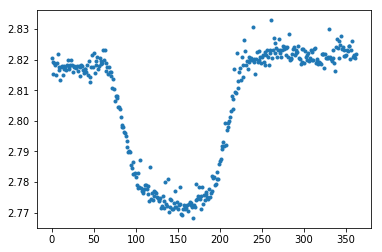

In [10]:
Targ_WL = np.sum(WL_transit_data['WASP31'], axis = 1)
Comp4_WL = np.sum(WL_transit_data['comp4'], axis = 1)
plt.plot(Targ_WL/Comp4_WL, '.')
plt.show()
plt.close()

Went through a big ordeal of trying to find the best noise levels, but in the end figured it'll just be best to use the errorbars from the transpec file for each target and the comp stars. It is an over estimation of the errorbars, but better than wasting more time figuring out more realistic ones. Also better to overestimate than underestimate. 

In [11]:
LC_error = []
LC_errorBar = []
for i in range(len(RpRsErrUp)):
    LC_error.append(np.min([RpRsErrUp2[i],RpRsErrDwn2[i]]))
    LC_errorBar.append(np.min([RpRsErrUp[i],RpRsErrDwn[i]]))

Now to add limb darkening and planetary features in transit:

Attempted to create limbdarkening parameters based on Hannu Parviainen's limb darkening coefficent code, *LDTk* https://github.com/hpparvi/ldtk/blob/master/README.md. I couldn't get this to work with the github installed version of ldtk on py27. However got it to work with the pip installed version of ldtk on py37. Need to check if py37 or the installation version is the problem later. For now I'll just copy what I did on my other folder. 


In [14]:
# from ldtk import LDPSetCreator, BoxcarFilter
# # from Anderson et al 2012
# Teff = 6302
# Teff_err = 102

# logg_star = 4.308
# logg_star_err = 0.02

# FeH = -0.2
# FeH_err = 0.09
# ld_uncerty_multper = 3
# # BinFile = 'w31_114_Ob1_Syn.dat'
# # bnB, bnT = np.loadtxt(BinFile, unpack = True)
# filters = []
# for i in range(len(bnB)):
#     filters.append(BoxcarFilter('b', bnB[i]/10, bnT[i]/10)) # Define your passbands. In Nanometers
#     # - Boxcar filters useful in #   transmission spectroscopy

# sc = LDPSetCreator(teff=(Teff, Teff_err),    # Define your star, and the code
#                    logg=(logg_star, logg_star_err),    # downloads the uncached stellar
#                       z=(FeH, FeH_err),    # spectra from the Husser et al.
#                      filters=filters)    # FTP server automatically.

# ps = sc.create_profiles()                # Create the limb darkening profiles
# ps.set_uncertainty_multiplier(ld_uncerty_multper)
# cq,eq = ps.coeffs_qd(do_mc=True)         # Estimate quadratic law coefficients

#Coefficents for new binning scheme
cp1 = np.array([[0.707154207440795, 0.10074424160066689],[0.7425095041749697, 0.04700295390629136],[0.6515402295883644, 0.11904717586938215]
,[0.6522923260165938, 0.1227034377491792],[0.6308708746738153, 0.13654277002652648],[0.6143698597374464, 0.14408644715694136]
,[0.5458425866403276, 0.1696993612781755],[0.5773414904398046, 0.14379732739543757],[0.5645049544105303, 0.1501003494875279]
,[0.5495758570893131, 0.14338387216068532],[0.5372633959887434, 0.1521648488267851],[0.5256215494624861, 0.15257472280643672]
,[0.5186302892947934, 0.15056725520526437],[0.5054229882518303, 0.15622576816771575],[0.49594507326181747, 0.1563780064548615]
,[0.48579570694987817, 0.1603608426612148],[0.4793126901930964, 0.1579385653930231],[0.47241283339531825, 0.15801083917165526]
,[0.46427061685128, 0.15587780477711777],[0.45623781448462825, 0.15188908527372258],[0.4471230706851915, 0.15503239699639249]
,[0.43278560280763145, 0.15646784431780453],[0.36990880488157807, 0.17833616631198218],[0.4194589017750955, 0.15569409564989523]
,[0.41466633920736573, 0.15366024091039918],[0.4084672348076663, 0.1529160387609032],[0.4016029716624372, 0.1528233196566519]
,[0.39396837516613775, 0.15198249806764103],[0.3904077639850072, 0.15000887559427942],[0.38390350674795537, 0.14981495658786903]
,[0.3777387057617298, 0.14915923025458946],[0.3725018757837816, 0.14921969518298167],[0.36601666656351783, 0.14855997031641777]
,[0.3600213056859857, 0.1479135081191988],[0.3562142021976969, 0.14887316240801635],[0.35115327078423014, 0.14646841875116268]
,[0.339339496010995, 0.14859128586315945],[0.3268339788807493, 0.14791081874753706],[0.31473189637058085, 0.149955639312624]
,[0.306700116129213, 0.146520086737145],[0.3098210372024899, 0.15023488776583577],[0.30584407003698216, 0.14980712647389655]
,[0.30130147873074675, 0.14650186769547788],[0.2897932507295622, 0.1512568609637666],[0.29381462969082284, 0.14662478467340323]])

cp2 = np.array([[0.70764195,0.10022461],[0.7431213,0.04648973],[0.6512924,0.11942158],[0.65291624,0.12223611]
 ,[0.6328454,0.13531235],[0.61579549,0.14368092],[0.55039556, 0.16767068],[0.57779424,0.14349422]
 ,[0.56488902,0.14996392],[0.54985419,0.14333932],[0.53763267,0.15196399],[0.52594897,0.15244117]
 ,[0.51904512,0.1502903 ],[0.50577816,0.15603061],[0.49630609, 0.1561167 ],[0.4861404,0.16014089]
 ,[0.47958833,0.15779741],[0.47316061,0.15766784],[0.46532126, 0.15611026],[0.45774747,0.15269854]
 ,[0.44827741,0.15350007],[0.43381174,0.15607681],[0.36956421,0.17843298],[0.41967539,0.15548934],[0.41490786,0.15340982]
 ,[0.40874574,0.15263012],[0.40180937,0.15265878],[0.39413346,0.15179961],[0.39059174,0.14986894]
 ,[0.38407277,0.14963544],[0.37787291,0.14901532],[0.37261871,0.14913964],[0.3661132,0.14848107]
 ,[0.36010198,0.14782182],[0.35649083,0.14868666],[0.35279429,0.14689413],[0.33974861,0.14858606]
 ,[0.32669136,0.14790683],[0.31445802,0.14997293],[0.3064706,0.14648411],[0.30963385,0.15030368]
 ,[0.30568622,0.14995222],[0.30135573,0.14636049],[0.28951563,0.15148193],[0.29584839,0.14538449]])

cp3 = np.array([[0.7042494 ,0.1052315],[0.72533662,0.07601665],[0.68825083,0.08045813],[0.67549254,0.10521365],
 [0.65046653,0.12250929],[0.62961784,0.13562108],[0.58275548,0.1568209],[0.55628769,0.16066221],[0.57320794,0.14736693],
 [0.56538395,0.14803087],[0.54884094,0.14295972],[0.53570928,0.15200893],[0.52525211,0.15108594],[0.51856596,0.15079994],
 [0.50538368,0.15594961],[0.49648104,0.15581699],[0.48622033,0.15995864],[0.48038538,0.15756644],[0.47353125,0.15759132],
 [0.46528254,0.15555718],[0.45513817,0.15189334],[0.44170259,0.15555661],[0.42587208,0.15916069],[0.37330344,0.17532158],
 [0.42006152,0.15386163],[0.41327514,0.15301589],[0.40693937,0.1533389],[0.40063669,0.15211013],[0.39387643,0.15079726],
 [0.38984402,0.15049536],[0.38375111,0.14961681],[0.37772157,0.14777411],[0.37255891,0.149519],[0.36666667,0.14824343],
 [0.36077095,0.14767406],[0.35635252,0.14854318],[0.34697728,0.14843668],[0.33809858,0.14827428],[0.32763139,0.14754281],
 [0.31535397,0.14926926],[0.30667624,0.1463051],[0.31063927,0.14979475],[0.30670536,0.1492992],[0.30206836,0.14604956],
 [0.29070159,0.15071536],[0.29637134,0.14528933]])

Using those limbdarking coefficents to create transit models for each of the wavelengths. Where RpRs for each bin is determined for from the function "bin_exotransmit_model".

importing the same external parameters as what was produced in the real data. 

In [26]:
eparams = '/Users/chimamcgruder/Hydra/Copy0/GPTransmissionSpectra/outputs/w31/ut190314/LC400/NoLBR/eparams.dat'  
Times, Airmass, DeltaWav, FWHM, SkyFlux, TraceCent = np.loadtxt(eparams, unpack = True)

#To standardize parameters
StrndAir = (Airmass - np.mean(Airmass))/np.std(Airmass)
StrndDelWav = (DeltaWav - np.mean(DeltaWav))/np.std(DeltaWav)
StrndFWHM = (FWHM - np.mean(FWHM))/np.std(FWHM)
StrndSkyFlx = (SkyFlux - np.mean(SkyFlux))/np.std(SkyFlux)
StrndTrcCen = (TraceCent - np.mean(TraceCent))/np.std(TraceCent)
StrndTim = (Times - np.mean(Times))/np.std(Times)

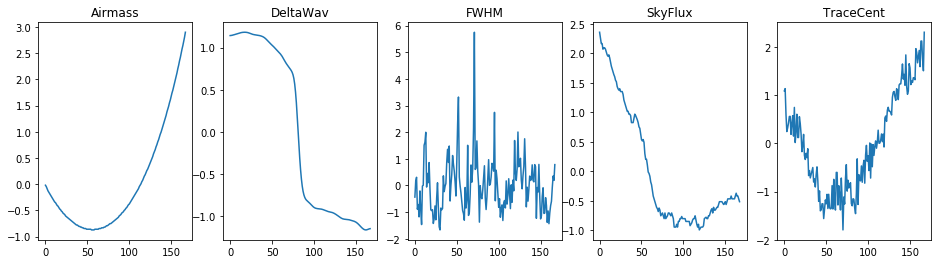

In [27]:
# plotting how the parameters vary of the night
plt.figure(0, figsize = (16,4))
plt.subplot(151)
plt.title('Airmass')
plt.plot(StrndAir)

plt.subplot(152)
plt.title('DeltaWav')
plt.plot(StrndDelWav)

plt.subplot(153)
plt.title('FWHM')
plt.plot(StrndFWHM)

plt.subplot(154)
plt.title('SkyFlux')
plt.plot(StrndSkyFlx)

plt.subplot(155)
plt.title('TraceCent')
plt.plot(StrndTrcCen)
plt.show()
plt.close()

In [18]:
print len(Times), repr(rTimes) #Need to print out the times to copy that in the Transit.py file that is done on the cluster

363 [2456711.61135231 2456711.61205836 2456711.6127644  2456711.61347045
 2456711.6141765  2456711.61488254 2456711.61560016 2456711.61630621
 2456711.61701226 2456711.6177183  2456711.61843593 2456711.61914197
 2456711.61984802 2456711.62055407 2456711.62126011 2456711.62196616
 2456711.62267221 2456711.62338983 2456711.62409587 2456711.62480192
 2456711.62550797 2456711.62622559 2456711.62693164 2456711.62763768
 2456711.62834373 2456711.62906135 2456711.62977897 2456711.63050817
 2456711.63122579 2456711.63253371 2456711.63317031 2456711.63380691
 2456711.63511483 2456711.63578616 2456711.63648063 2456711.63716352
 2456711.63784642 2456711.63852932 2456711.63921222 2456711.63989512
 2456711.64057801 2456711.64126091 2456711.64193223 2456711.64261513
 2456711.64328645 2456711.64395778 2456711.6446291  2456711.64891168
 2456711.649583   2456711.65025432 2456711.65093722 2456711.65160854
 2456711.65229144 2456711.65297434 2456711.65365724 2456711.65435171
 2456711.65503461 2456711.6557

In [19]:
print repr(RpRss)

[0.12039357 0.12020499 0.12006719 0.1199493  0.11983451 0.11977371
 0.11965359 0.11946341 0.1195323  0.11924656 0.11938803 0.11913225
 0.11909088 0.11917595 0.11916554 0.1192514  0.11956585 0.12136601
 0.11946686 0.11891392 0.11927726 0.11848453 0.11829073 0.11826913
 0.11883599 0.11835707 0.11798452 0.117849   0.11862959 0.11821736
 0.11772265 0.11776907 0.11784364 0.11814664 0.1203625  0.11811524
 0.11764713 0.11721293 0.11703565 0.1170495  0.11687747 0.11689406
 0.11677058 0.11663324 0.11666158 0.11659307]


To create eparam files without time dependence. Make sure the eparameters have already been clipped based off of bad frames

In [28]:
NewEpar = open('Ob4eparamsNoTime.dat', 'w')
# number of sig digits:10   
NewEpar.write('#Airmass 	 	 Delta Wav 	  	 FWHM 	        Sky Flux 	      Trace Center \n')
for l in range(len(Times)):
    NewEpar.write('%.10f'% Airmass[l]+' 	 '+'%.10f'% DeltaWav[l]+' 	 '+'%.10f'% FWHM[l]+' 	 '+'%.10f'% SkyFlux[l]+' 	 '+'%.10f'% TraceCent[l]+' \n') 
NewEpar.close()

Could not get batman to work on my mac properly. Will try to fix that later, but as of now just ran it on Hydra and downloading the pickle file here.

In [12]:
Good_LC = pickle.load(open('Light_curvesOb3.pkl', 'rb'))
print Good_LC.shape
plt.figure(0, figsize =(10,4))
plt.title('Modeled transit, mean of all wavelength bins')
plt.plot(Times, np.mean(Good_LC, axis = 1))
print WL_transit_data['WASP31'][2].shape

(45,)


##### UPDATE (3/4/24): I got batman to work on my mac properly. I think the issue was there were a bunch of packages that I didn't have properly organized, my solution was to completely delete anaconda, then reinstall it so I can make enviorments for different projects and record my package installation history to keep track of how I modify my anaconda. However, because a lot of the files that I used to create the synthetic dataset is on the cluster (which I no longer have access to), I can't rerun this sheet without getting new files.

In [ ]:
import batman
def batman_model(x0,time):
    """Generate the Mandel & Agol (batman) transit model.
    Inputs:
    x0 - transit parameters:  P (orbital period [days] of planet), t0 (time of mid transit), Rp/Rs, a/Rs, inclination, u1, u2. This assumes quadratic limb darkening.
    period - orbital period of planet (in days)
    time - time array over which to calculate model

    Returns:
    modelled fluxes as a function of time array
    """
    parms = batman.TransitParams()
    parms.t0 = x0[1]                       #time of inferior conjunction
    parms.per = x0[0]                       #orbital period
    parms.rp = x0[2]                       #planet radius (in units of stellar radii)
    parms.a = x0[3]                        #semi-major axis (in units of stellar radii)
    parms.inc = x0[4]                      #orbital inclination (in degrees)
    parms.ecc = 0.                     #eccentricity
    parms.w = 90.                        #longitude of periastron (in degrees)
    parms.limb_dark = "quadratic"        #limb darkening model
    parms.u = [x0[5],x0[6]]      #limb darkening coefficients [u1, u2]
    m = batman.TransitModel(parms, time)
    return parms, m
PAR, M = batman_model(x0,time)
model_flux = M.light_curve(PAR)

### 2) Make Synthetic data

We now have all the information we need to make the synthetic data. The simplest way to make synthetic spectrum using the external parameters is to randomly vary the length scale and amplitude hyperparameters of the GP within some range, then pull out random samples with these GP parameters, then finally add the noise. This is what I'll do to make my final test, with a unique GP draw for each bin (chromatic systematics), but the same draws for stars in bin (non-chromatic systematics). Only had the data depend on the external parameters airmass, deltawav, trace center, and time.

1/lambda one over 'metric' [363.94020206  59.00085698 242.76477975  76.78575528 243.41692977
 111.79312108]
Constants [0.00137441 0.00137042 0.00120286 0.00100357 0.00132084 0.00058685]
i 0
Bin: 4077.981871511579
LC std: 0.0007854989866637


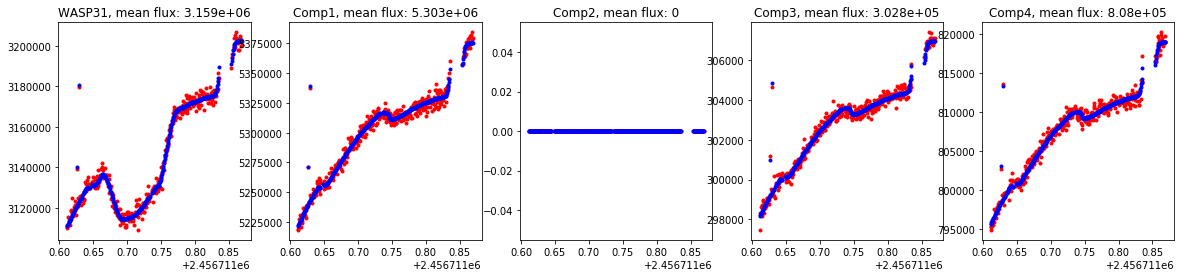

i 1
Bin: 4212.539297704839
LC std: 0.0008450706959735


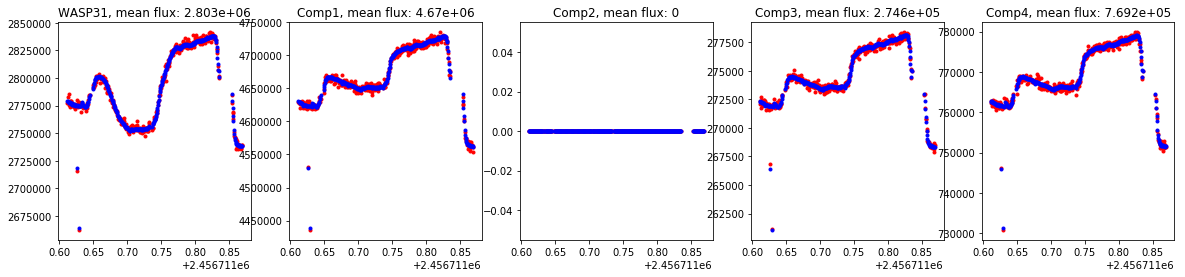

i 2
Bin: 4322.689378766102
LC std: 0.0007907550649556


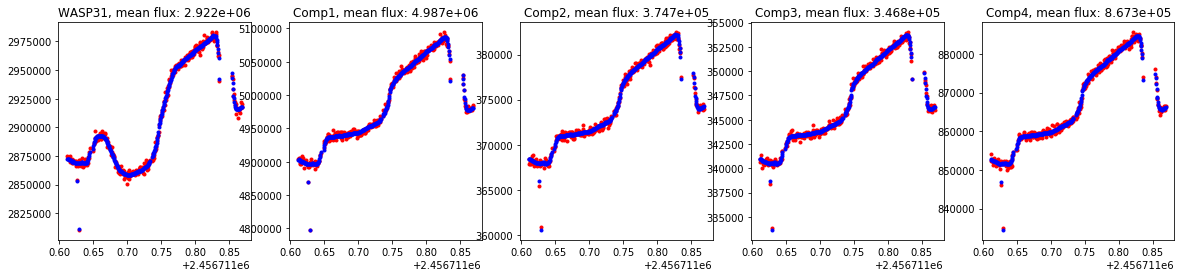

i 3
Bin: 4427.905601317648
LC std: 0.0007017331199803


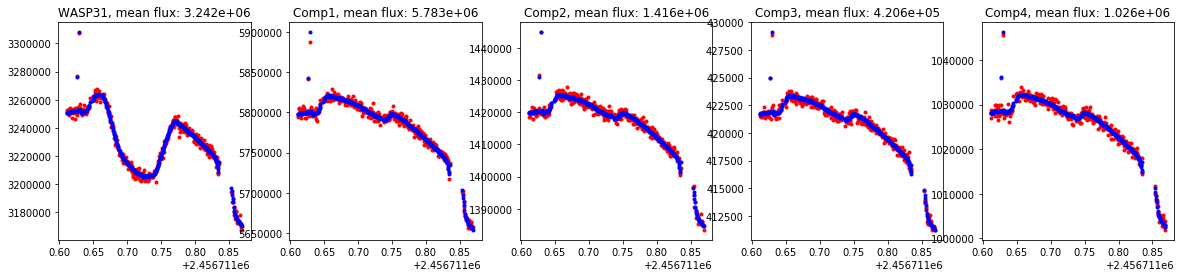

i 4
Bin: 4528.145835957143
LC std: 0.0007715074506216


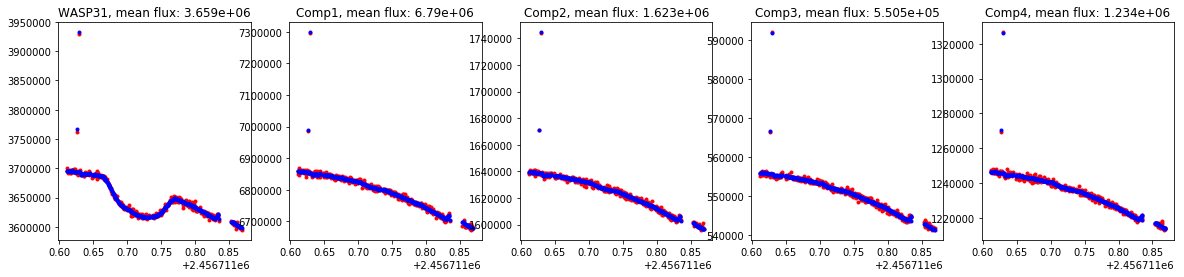

i 5
Bin: 4627.661934758696
LC std: 0.0007560935271281001


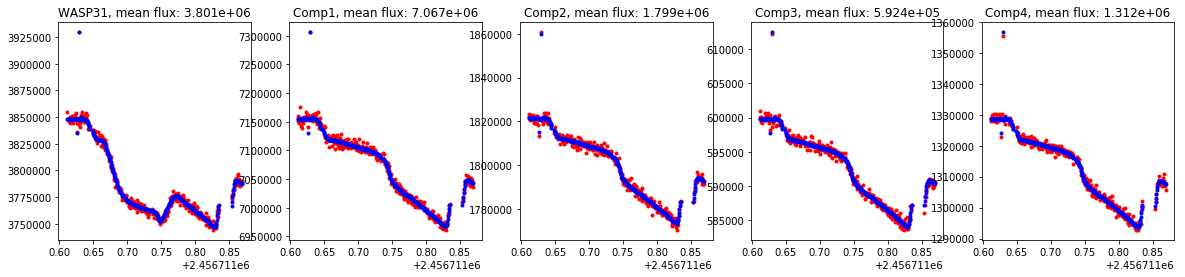

i 6
Bin: 4803.286636791666
LC std: 0.0008346329858572


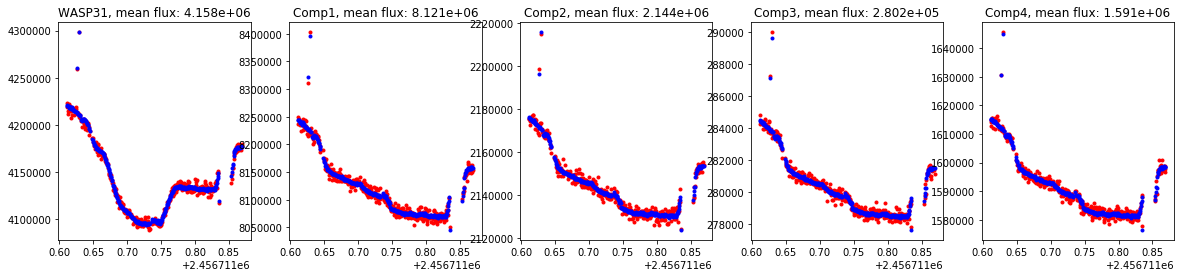

i 7
Bin: 4909.353997283333
LC std: 0.0006489677015327


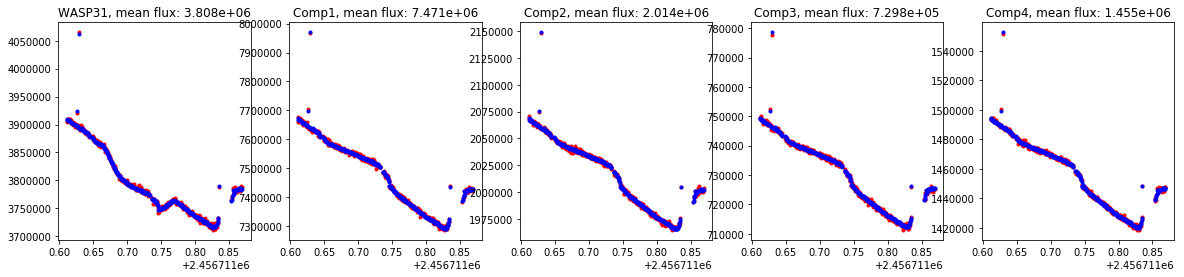

i 8
Bin: 5008.924515941027
LC std: 0.0007198109424401


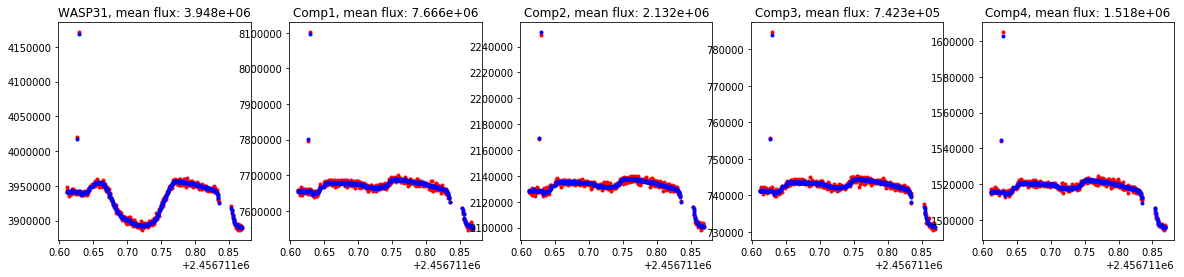

i 9
Bin: 5108.7257144974365
LC std: 0.0007619995244071


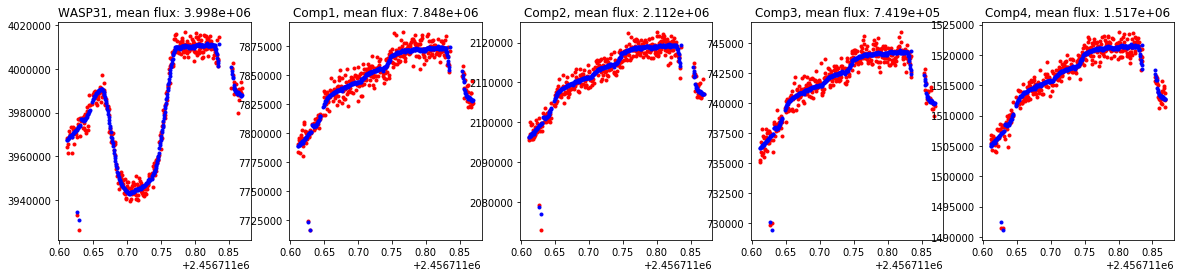

i 10
Bin: 5209.8512233
LC std: 0.0006855853558973999


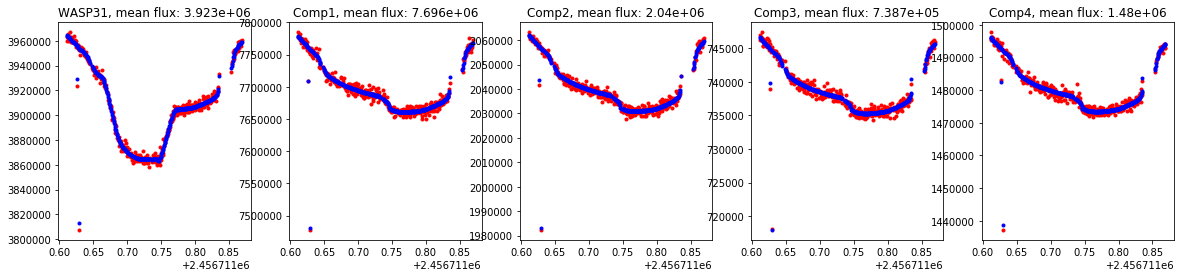

i 11
Bin: 5315.098503430768
LC std: 0.0008800905186925


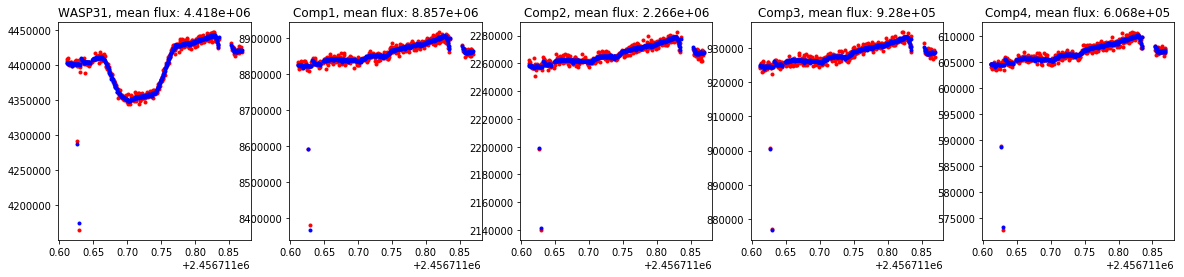

i 12
Bin: 5420.207462267647
LC std: 0.0006878971550624


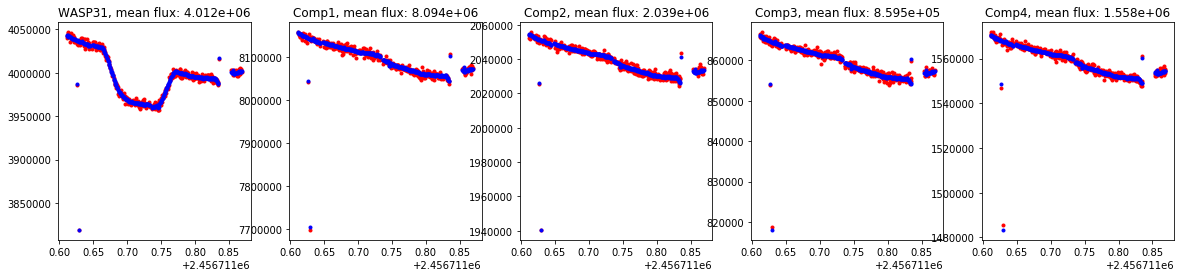

i 13
Bin: 5518.907094884375
LC std: 0.0004781812196417


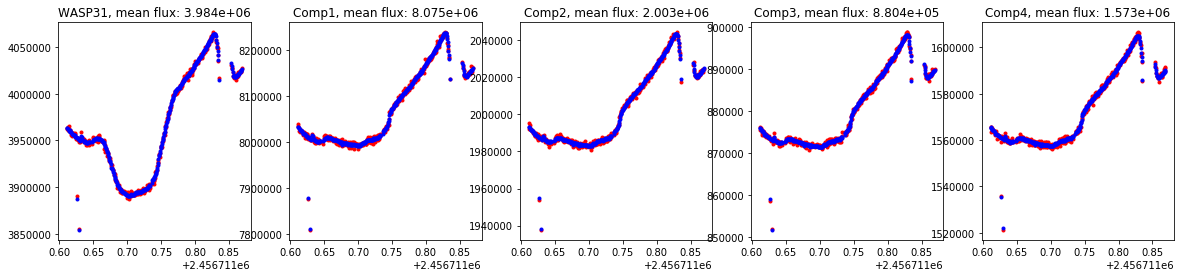

i 14
Bin: 5618.1286945281245
LC std: 0.0003022317758038


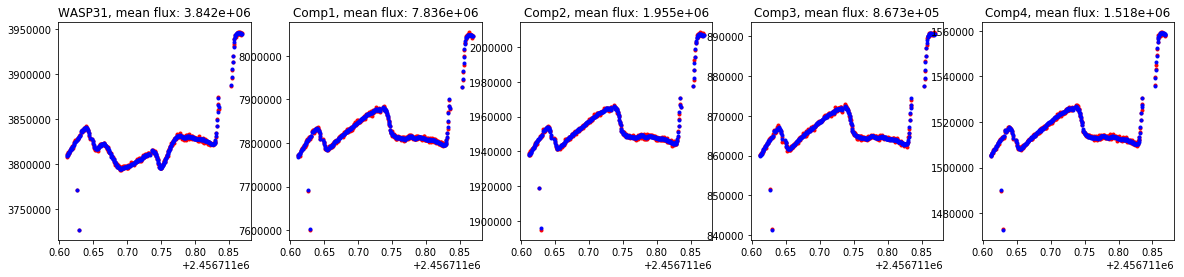

i 15
Bin: 5719.337538000001
LC std: 0.0003719081579942


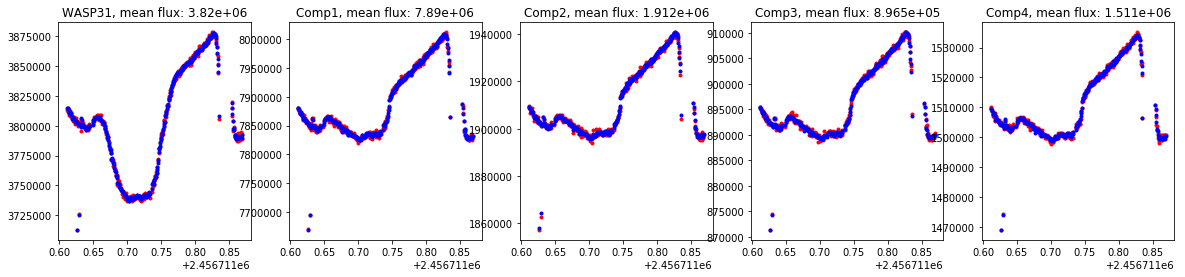

i 16
Bin: 5815.763415322222
LC std: 0.0004100029786028


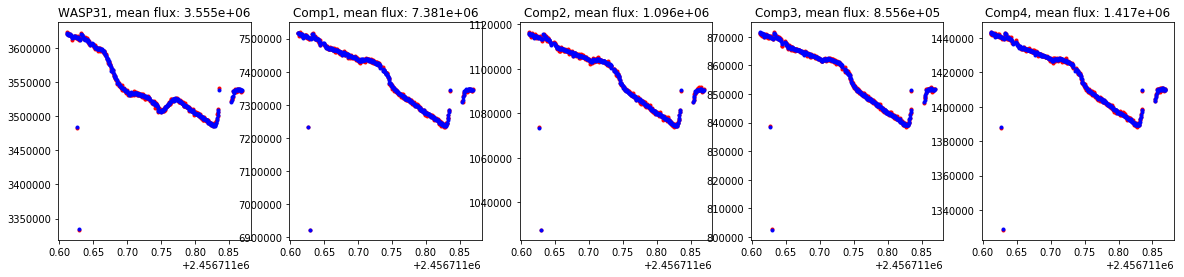

i 17
Bin: 5892.806993766666
LC std: 0.0005149995682858001


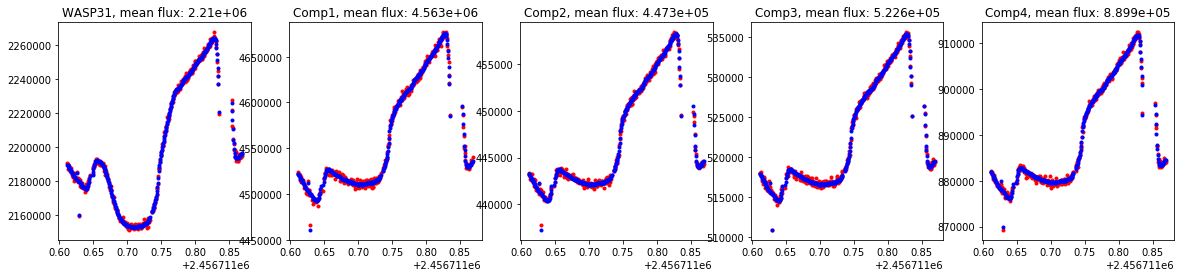

i 18
Bin: 5982.844471451515
LC std: 0.0004551007544644


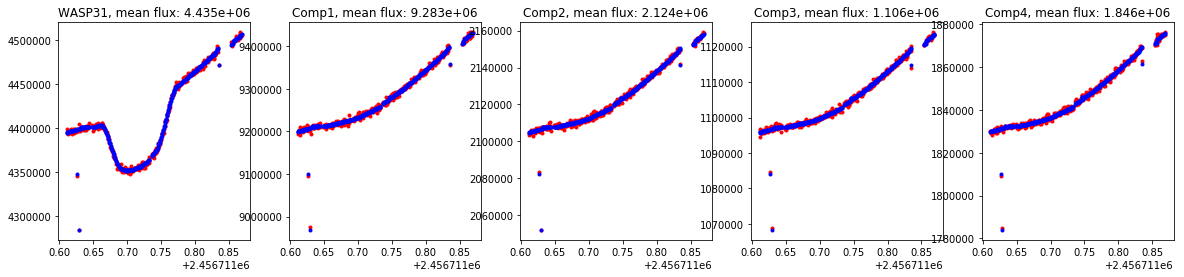

i 19
Bin: 6092.126199962962
LC std: 0.0005579107038005


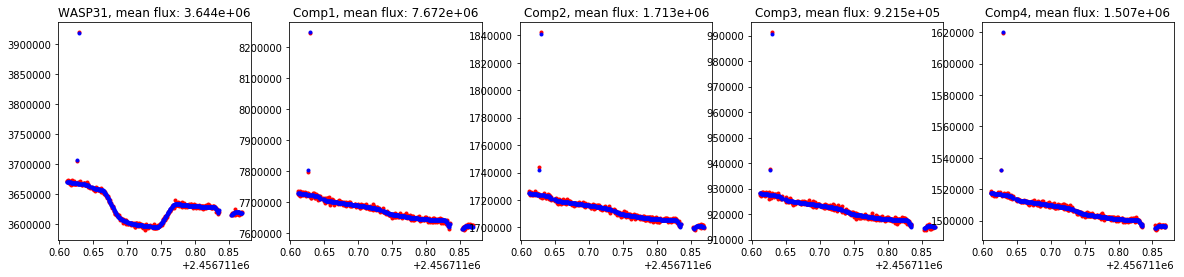

i 20
Bin: 6203.677473759375
LC std: 0.0008394746838695001


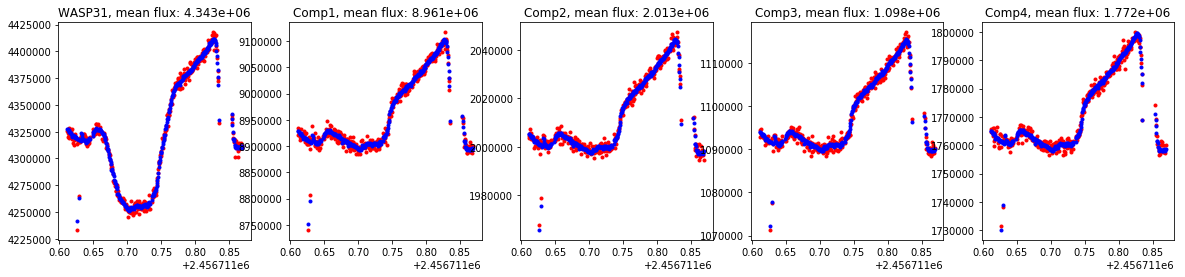

i 21
Bin: 6387.893676274074
LC std: 0.0007889271572194


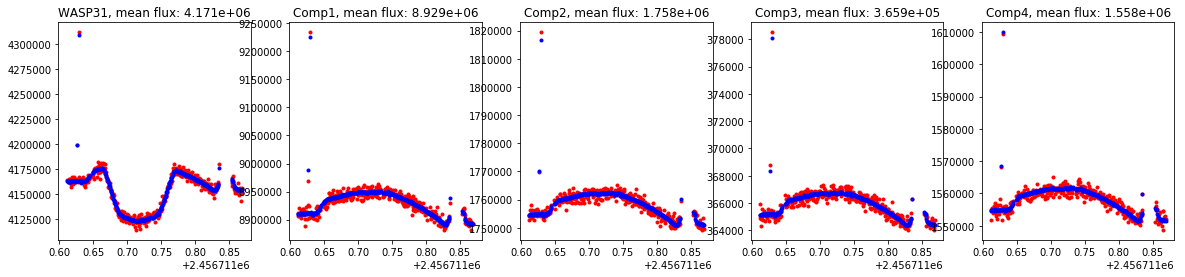

i 22
Bin: 6493.637695433335
LC std: 0.0003440206962912


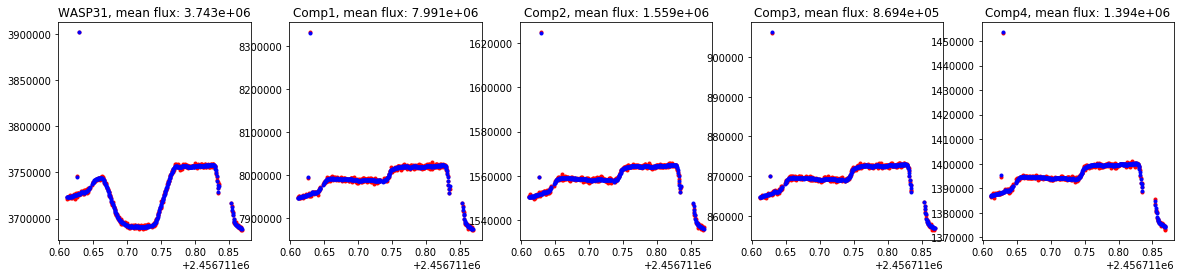

i 23
Bin: 6594.257388634782
LC std: 0.0002343989599969


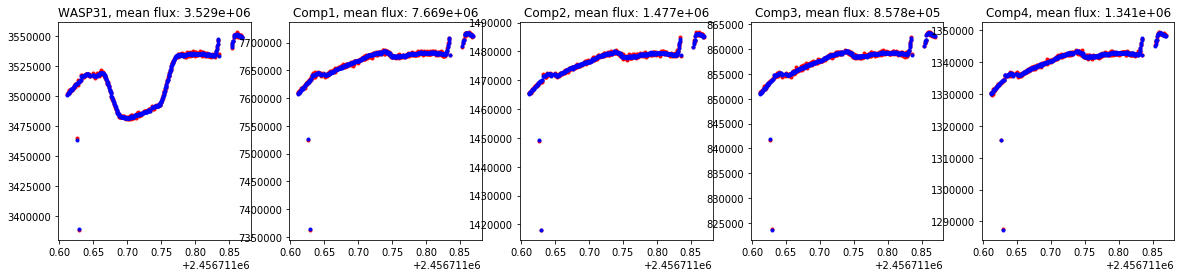

i 24
Bin: 6693.5611341818185
LC std: 0.00043646963998669996


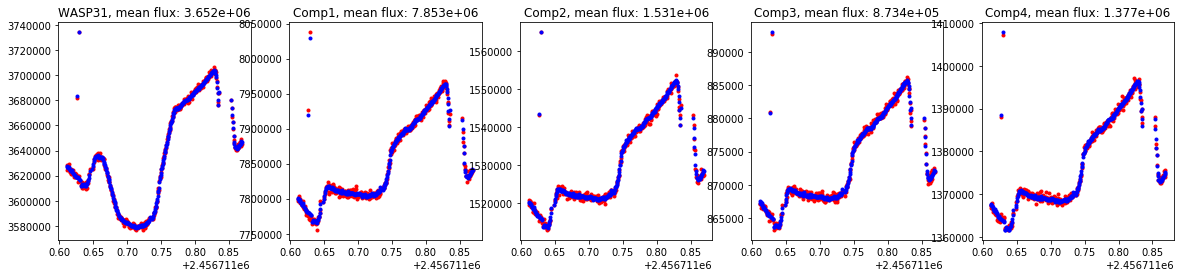

i 25
Bin: 6793.604460163636
LC std: 0.0002986163716748


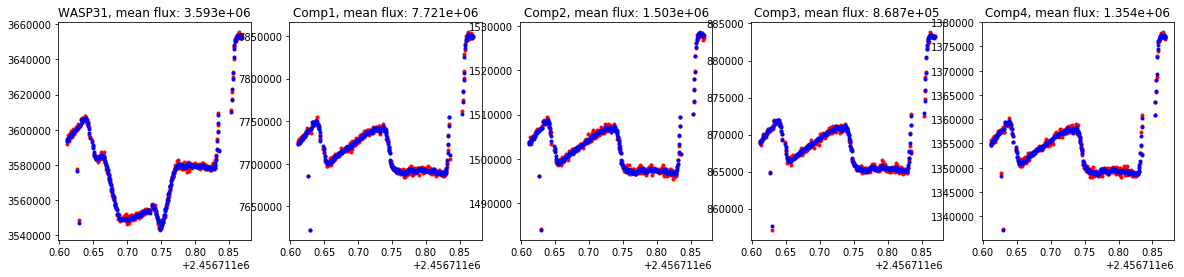

i 26
Bin: 6899.07514793913
LC std: 0.0005479391694801


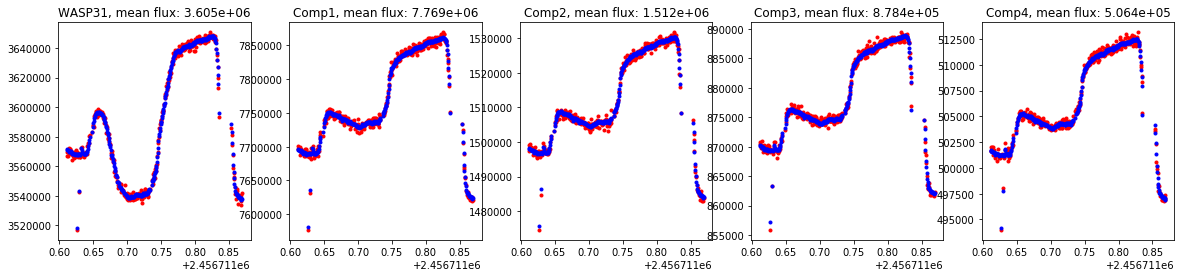

i 27
Bin: 7002.915308254999
LC std: 0.0004780636145372


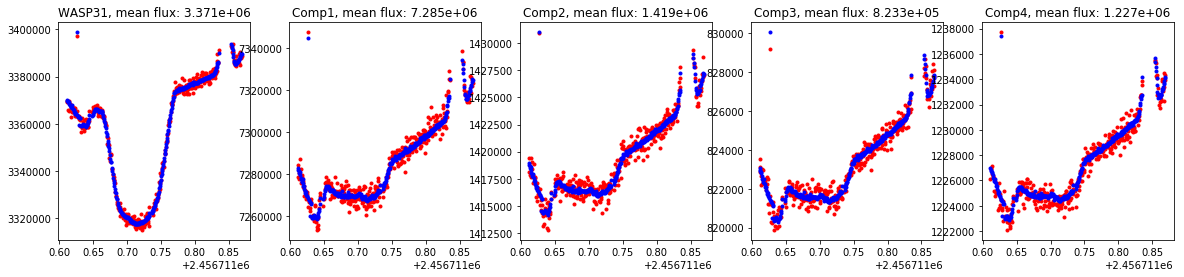

i 28
Bin: 7102.39185058
LC std: 0.0004498509365929


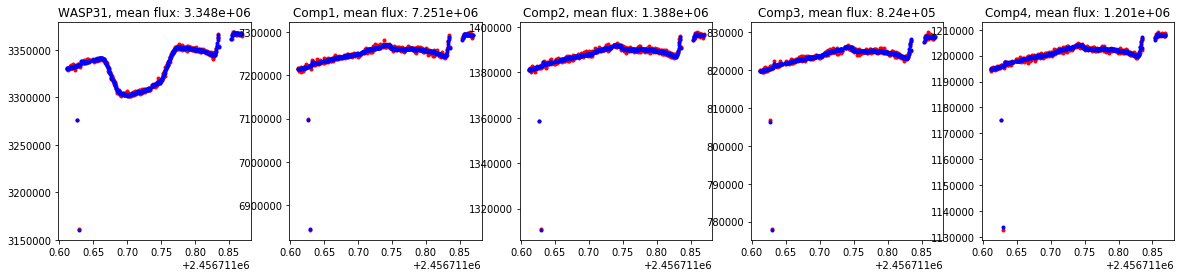

i 29
Bin: 7202.128636289473
LC std: 0.0004196502562172


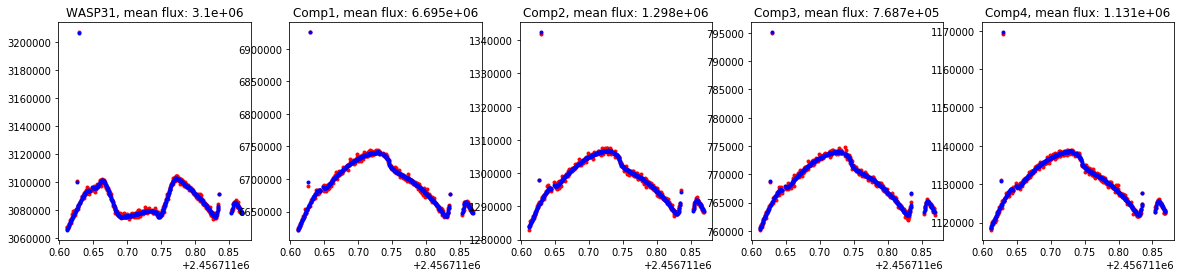

i 30
Bin: 7302.051814068422
LC std: 0.0004193378783247


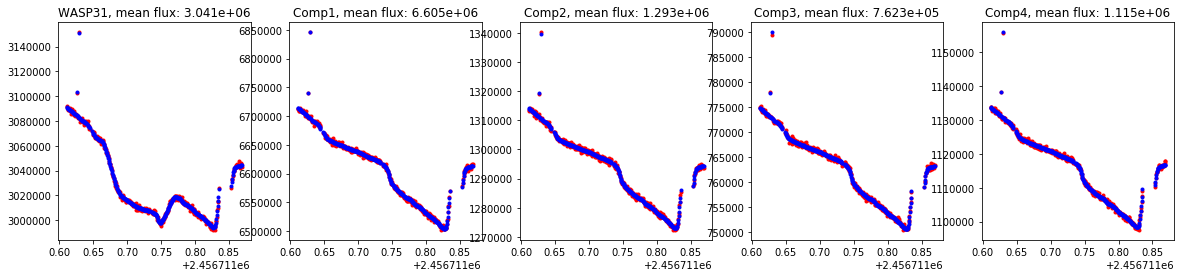

i 31
Bin: 7402.033661166667
LC std: 0.0004042143210095


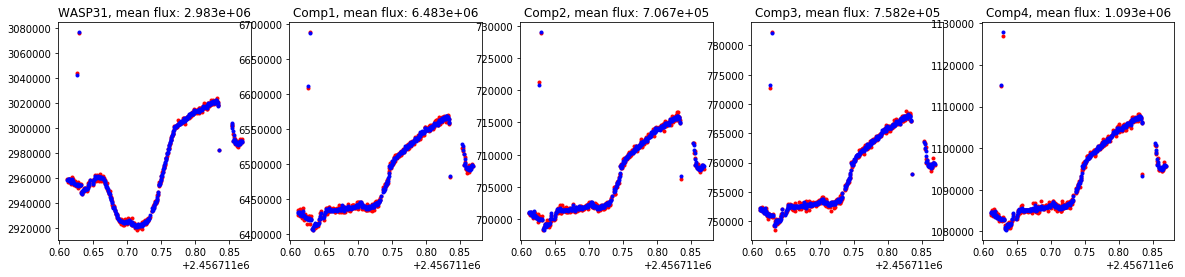

i 32
Bin: 7501.989111849999
LC std: 0.00041777860582609995


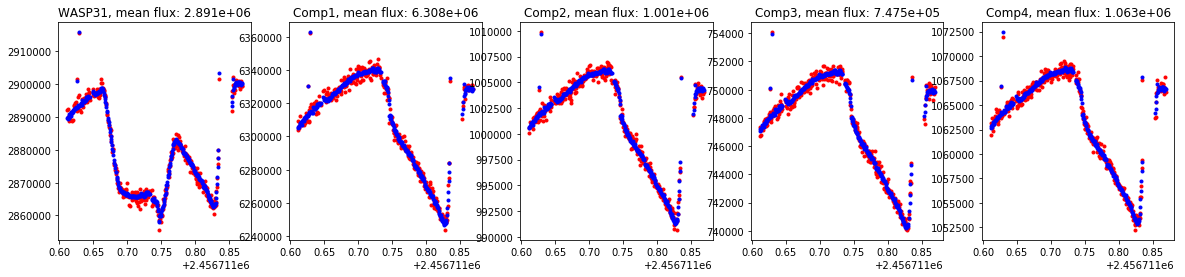

i 33
Bin: 7601.777794352942
LC std: 0.0007293812939007


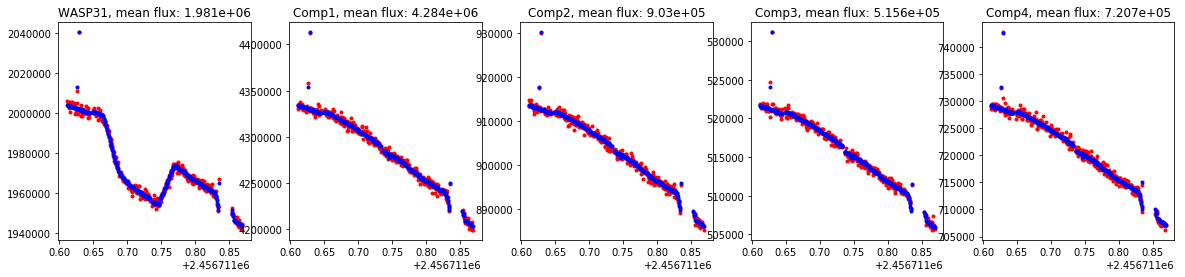

i 34
Bin: 7680.528930210001
LC std: 0.0006252863959612


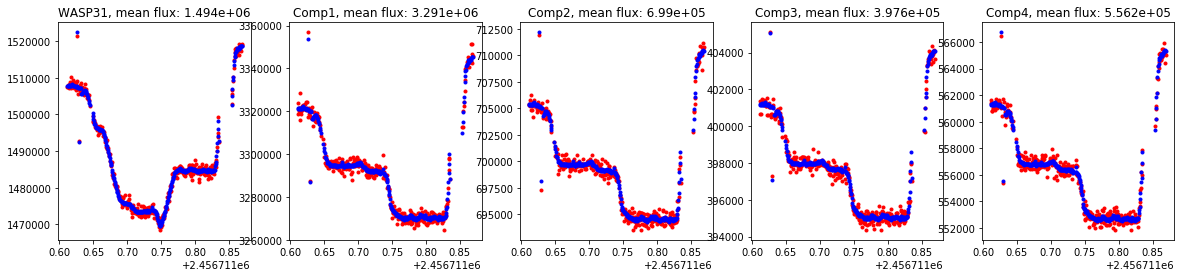

i 35
Bin: 7791.482888681482
LC std: 0.0008043925370731


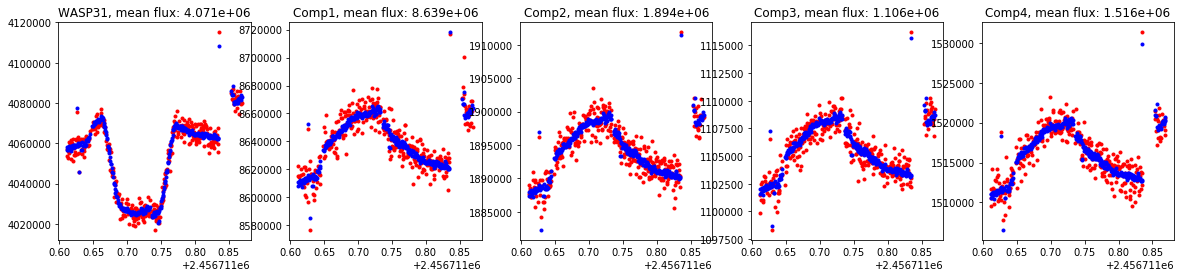

i 36
Bin: 8006.575779850001
LC std: 0.0008040533230231


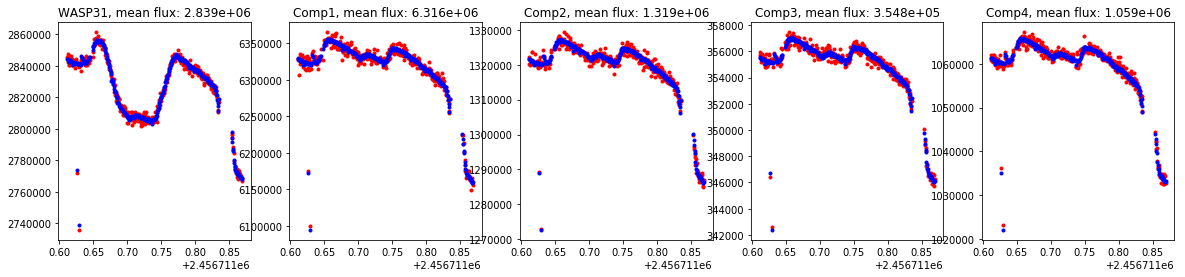

i 37
Bin: 8146.8774202391305
LC std: 0.0007175047709258999


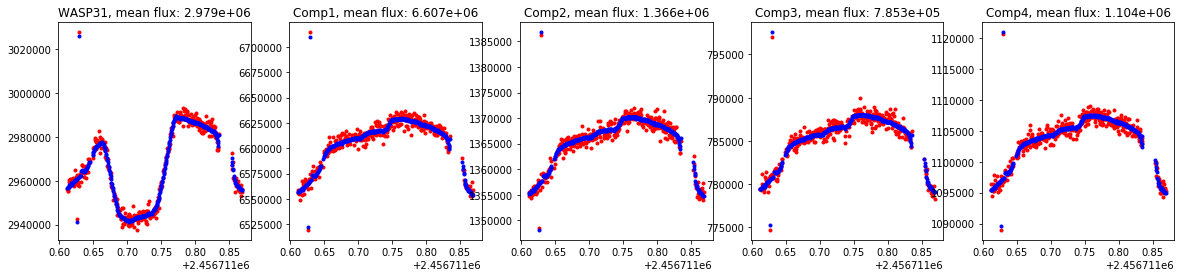

i 38
Bin: 8298.985238899999
LC std: 0.0005808162871709


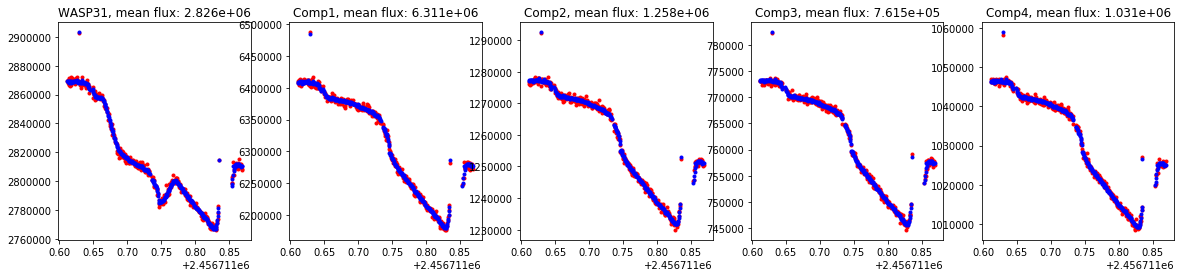

i 39
Bin: 8456.925737156524
LC std: 0.0005691351357637


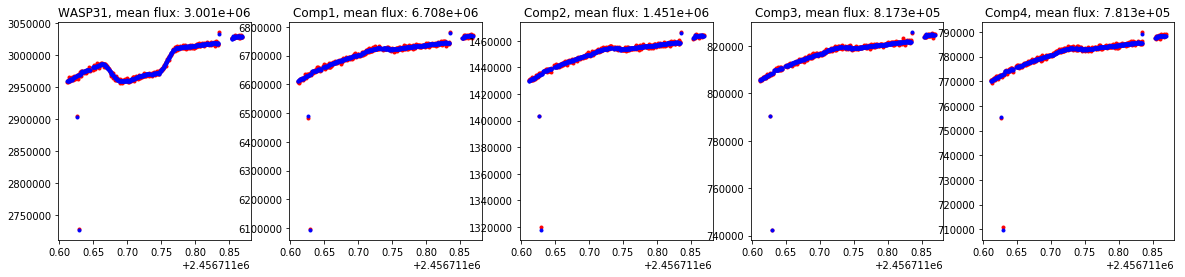

i 40
Bin: 8620.947533731818
LC std: 0.0004333244933167


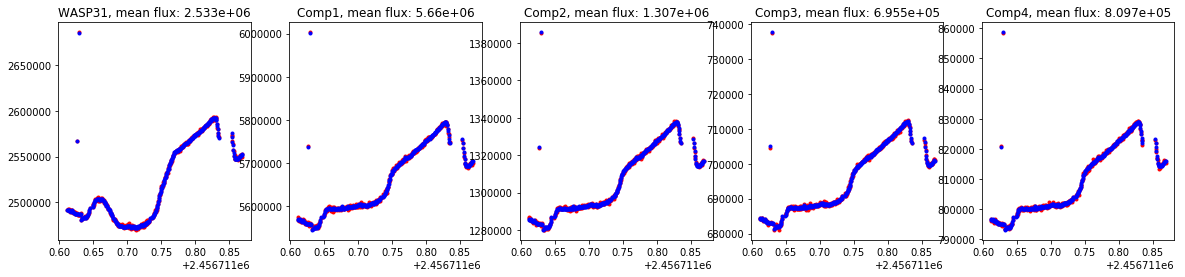

i 41
Bin: 8775.981616905263
LC std: 0.0005638965517753001


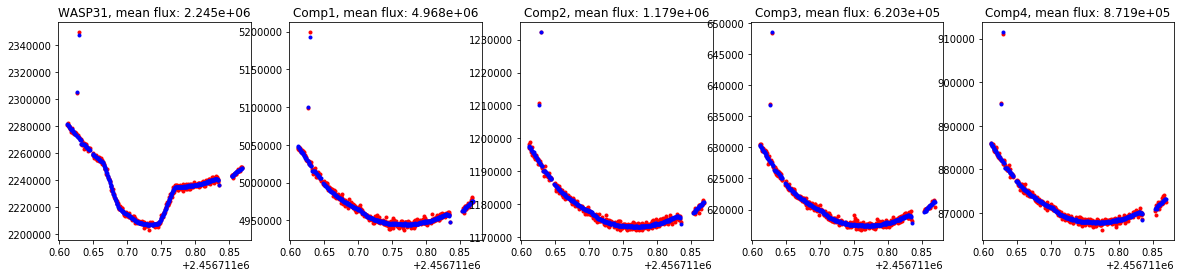

i 42
Bin: 8924.800495315789
LC std: 0.000560241359584


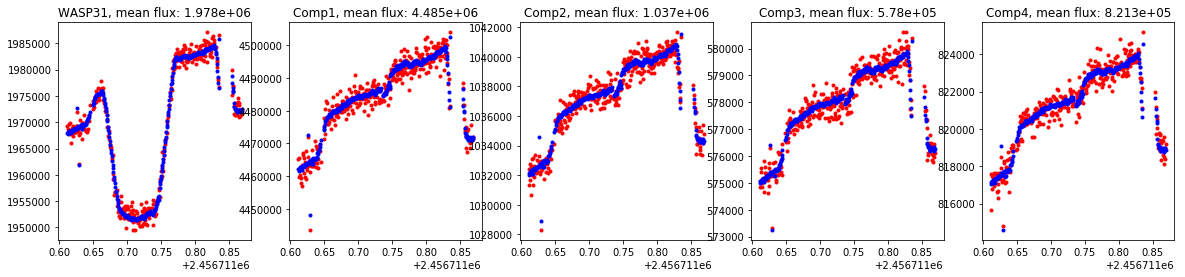

i 43
Bin: 9087.05385868095
LC std: 0.0006238069587683


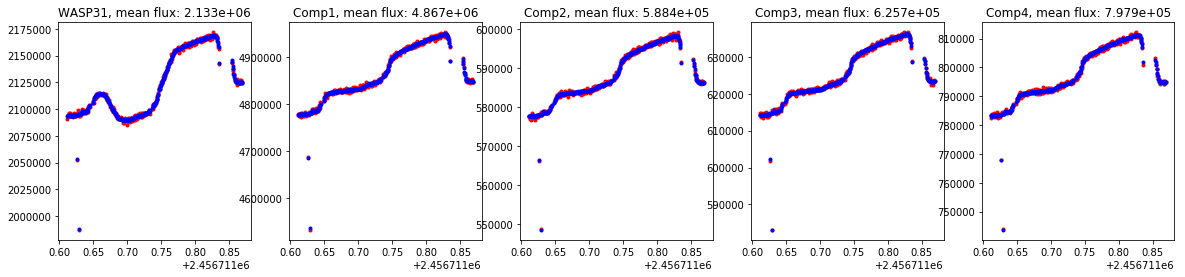

i 44
Bin: 9250.906891583334
LC std: 0.0007418871432661


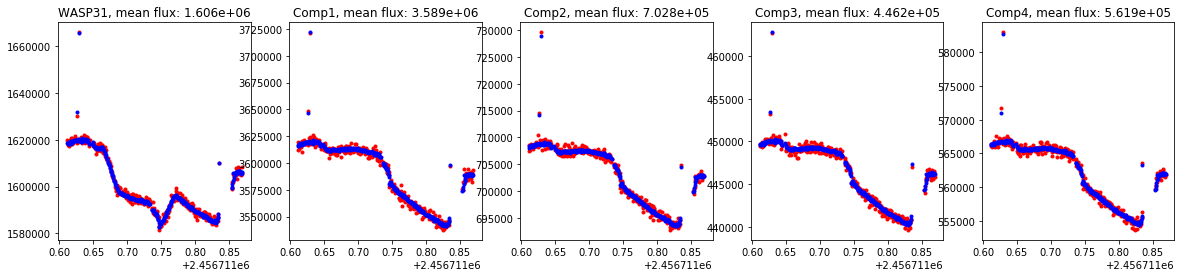

i 45
Bin: 9443.344300384615
LC std: 0.0007110459008078


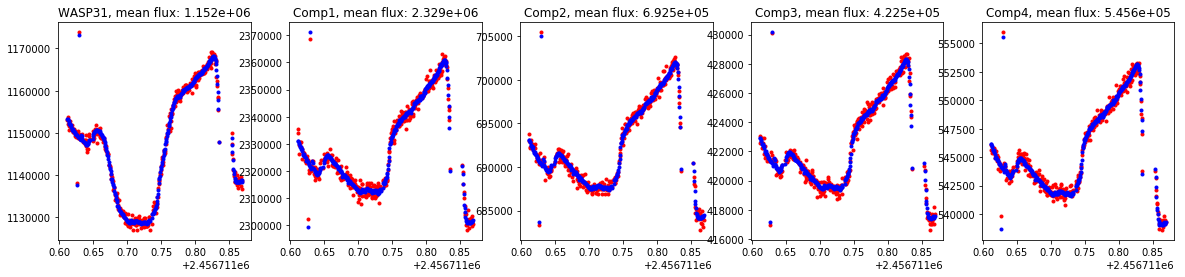

In [27]:
import george
###======================= To produce main trend that's identical to all comps =================###
#number closer to -1 makes the function more dependent on external parameters
inv_ln_alpha = np.random.uniform(-6.0, -4.0, 6)
inv_alpha = np.exp(inv_ln_alpha)
lambDa = 1.0/inv_alpha
print "1/lambda one over 'metric'", lambDa

#number closer to -1 makes the functions more dependent on external parameters
Const = np.random.uniform(.5e-3,1.5e-3, 6)
print 'Constants', Const
k1 = Const[0]*george.kernels.ExpSquaredKernel(lambDa[0], axes= 0, ndim = 5)
k2 = Const[1]*george.kernels.ExpSquaredKernel(lambDa[1], axes= 1, ndim = 5)
k3 = Const[2]*george.kernels.ExpSquaredKernel(lambDa[2], axes= 2, ndim = 5)
k4 = Const[3]*george.kernels.ExpSquaredKernel(lambDa[3], axes= 3, ndim = 5)
#
k5 = Const[4]*george.kernels.ExpSquaredKernel(lambDa[4], axes= 4, ndim = 5)
# k6 = Const[5]*george.kernels.ExpSquaredKernel(lambDa[5], axes= 5, ndim = 6)

GP_Main = george.GP(k1+k2+k3+k4+k5)
gp_kernel_inputs_Main = np.array([StrndAir, StrndDelWav, StrndTrcCen, StrndTim, StrndSkyFlx])
GP_Main.compute(gp_kernel_inputs_Main.T)


LC_t = []
LC_c1 = []
LC_c2 = []
LC_c3 = []
LC_c4 = []
BINS = Binns #bins based of true data
Error = LC_error
for binn in range(Good_LC.shape[1]): 
    #Here sampling from GP priors to simulate random unknown dependencies of external parameters 
    gp_y_valuesMain = GP_Main.sample(gp_kernel_inputs_Main.T)
    print 'i', binn
    print 'Bin:', BINS[binn]
    print 'LC std:', Error[binn]
    plt.figure(0, figsize = (20,4))
    
    # for target
    plt.subplot(151)
    MeanFlux = np.mean(WL_transit_data['WASP31'][:,binn])
    Main_Eff = (gp_y_valuesMain-gp_y_valuesMain.mean())*MeanFlux
    plt.title('WASP31, mean flux: %.4g' % MeanFlux)
    std = MeanFlux*Error[binn] #noise level specific to each bin. 
    noise = np.random.normal(0, std, len(WL_transit_data['WASP31'][:,binn]))
    LC = Main_Eff + noise + (Good_LC[:,binn]*MeanFlux)
    LC_t.append(LC)
    plt.plot(Times, LC_t[binn], 'r.')
    plt.plot(Times, LC_t[binn]-noise, 'b.')

    # for comp1
    plt.subplot(152)
    MeanFlux = np.mean(WL_transit_data['comp1'][:,binn])
    Main_Eff = (gp_y_valuesMain-gp_y_valuesMain.mean())*MeanFlux
    plt.title('Comp1, mean flux: %.4g' % MeanFlux)
    std = MeanFlux*Error[binn]
    noise = np.random.normal(0, std, len(WL_transit_data['comp1'][:,binn]))
    LC = Main_Eff + noise + MeanFlux
    LC_c1.append(LC)
    plt.plot(Times, LC_c1[binn], 'r.')
    plt.plot(Times, LC_c1[binn]-noise, 'b.')
    
    # for comp2
    plt.subplot(153)
    MeanFlux = np.mean(WL_transit_data['comp2'][:,binn])
    Main_Eff = (gp_y_valuesMain-gp_y_valuesMain.mean())*MeanFlux
    plt.title('Comp2, mean flux: %.4g' % MeanFlux)
    std = MeanFlux*Error[binn]
    noise = np.random.normal(0, std, len(WL_transit_data['comp2'][:,binn]))
    LC = Main_Eff + noise + MeanFlux
    LC_c2.append(LC)
    plt.plot(Times, LC_c2[binn], 'r.')
    plt.plot(Times, LC_c2[binn]-noise, 'b.')

    # for comp3
    plt.subplot(154)
    MeanFlux = np.mean(WL_transit_data['comp3'][:,binn])
    Main_Eff = (gp_y_valuesMain-gp_y_valuesMain.mean())*MeanFlux
    plt.title('Comp3, mean flux: %.4g' % MeanFlux)
    std =MeanFlux*Error[binn]
    noise = np.random.normal(0, std, len(WL_transit_data['comp3'][:,binn]))
    LC = Main_Eff + noise + MeanFlux
    LC_c3.append(LC)
    plt.plot(Times, LC_c3[binn], 'r.')
    plt.plot(Times, LC_c3[binn]-noise, 'b.')
    
    # for comp4
    plt.subplot(155)
    MeanFlux = np.mean(WL_transit_data['comp4'][:,binn])
    Main_Eff = (gp_y_valuesMain-gp_y_valuesMain.mean())*MeanFlux
    plt.title('Comp4, mean flux: %.4g' % MeanFlux)
    std = MeanFlux*Error[binn]
    noise = np.random.normal(0, std, len(WL_transit_data['comp4'][:,binn]))
    LC = Main_Eff + noise + MeanFlux
    LC_c4.append(LC)
    plt.plot(Times, LC_c4[binn], 'r.')
    plt.plot(Times, LC_c4[binn]-noise, 'b.')
    
    plt.show()
    plt.close()    
LC_targ_withT = np.array(LC_t)
LC_c1_withT = np.array(LC_c1)
LC_c2_withT = np.array(LC_c2)
LC_c3_withT = np.array(LC_c3)
LC_c4_withT = np.array(LC_c4)

Just to test how like the real data this syntheic data is (below)

(46, 363)


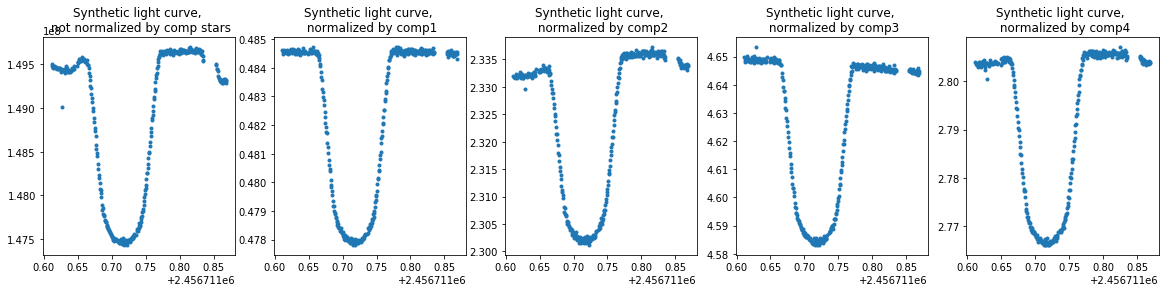

In [29]:
print LC_targ_withT.shape
WLC_t = np.sum(LC_targ_withT, axis = 0)
WLC_c1 = np.sum(LC_c1_withT, axis = 0)
WLC_c2 = np.sum(LC_c2_withT, axis = 0)
WLC_c3 = np.sum(LC_c3_withT, axis = 0)
WLC_c4 = np.sum(LC_c4_withT, axis = 0)

plt.figure(0, figsize = (20,4))
plt.subplot(151)
plt.title('Synthetic light curve, \n not normalized by comp stars')
plt.plot(Times, WLC_t, '.')
plt.subplot(152)
plt.title('Synthetic light curve, \n normalized by comp1')
plt.plot(Times, WLC_t/WLC_c1, '.')
plt.subplot(153)
plt.title('Synthetic light curve, \n normalized by comp2')
plt.plot(Times, WLC_t/WLC_c2, '.')
plt.subplot(154)
plt.title('Synthetic light curve, \n normalized by comp3')
plt.plot(Times, WLC_t/WLC_c3, '.')
plt.subplot(155)
plt.title('Synthetic light curve, \n normalized by comp4')
plt.plot(Times, WLC_t/WLC_c4, '.')
plt.show()
plt.close()

True data. The binning scheme is a little different in this case than the synthetic data, but that is okay. This is just needed to check and see it looks similar to real data (below)

In [31]:
File = PltFinLCDirect3+'LCs_400.pkl'
Raw_LC = pickle.load(open(File, 'rb'))
print Raw_LC['cNames']

['comp4', 'comp1', 'comp2', 'comp3']


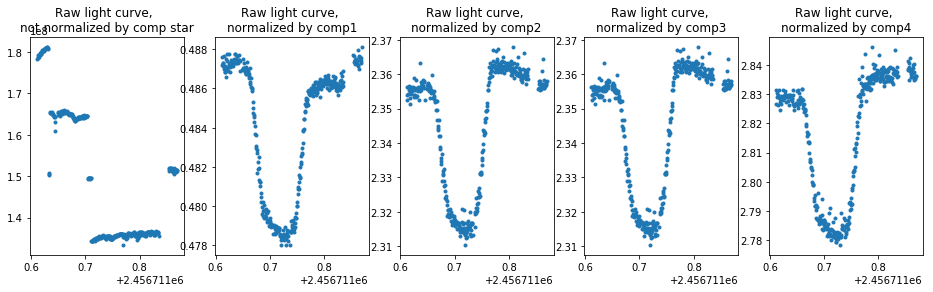

In [32]:
compLC = Raw_LC['cLC'][Good_idx]
Rawcomp1LC = compLC[:,1]
Rawcomp2LC = compLC[:,2]
Rawcomp3LC = compLC[:,3]
Rawcomp4LC = compLC[:,0]
RawTargLC = Raw_LC['oLC'][Good_idx]


plt.figure(0, figsize = (16,4))
plt.subplot(151)
plt.title('Raw light curve,  \nnot normalized by comp star')
plt.plot(Times, RawTargLC, '.')
plt.subplot(152)
plt.title('Raw light curve, \nnormalized by comp1')
plt.plot(Times, RawTargLC/Rawcomp1LC, '.')
plt.subplot(153)
plt.title('Raw light curve, \nnormalized by comp2')
plt.plot(Times, RawTargLC/Rawcomp2LC, '.')
plt.subplot(154)
plt.title('Raw light curve, \nnormalized by comp3')
plt.plot(Times, RawTargLC/Rawcomp2LC, '.')
plt.subplot(155)
plt.title('Raw light curve, \nnormalized by comp4')
plt.plot(Times, RawTargLC/Rawcomp4LC, '.')
plt.show()
plt.close()

Looks reasonable enough. The Synthetic data looks a little less noisy than the real data, but lets work with that for now and see what we get. Now Must save the data into pickle file to be imported by Nestor's code.

In [33]:
def RESHAPE(cLCw_data): 
    CurrShp = cLCw_data.shape
    properShp = np.zeros((CurrShp[1],CurrShp[0],CurrShp[2]))
    for c in range(CurrShp[0]):
        C = cLCw_data[c,:,:] #shape (n,w)
        for n in range(CurrShp[1]):
            N = C[n,:] #(w,)
            for w in range(len(N)):
                properShp[n,c,w] = N[w]
    return properShp

In [102]:
Synthetic = {}
Synthetic['t'] = Times
Synthetic['cNames'] = ['comp2', 'comp3', 'comp4']
cLC = np.array([WLC_c2,WLC_c3, WLC_c4])
Synthetic['cLC'] = cLC.T
Synthetic['oLC'] = WLC_t
wbins = []
for i in range(len(bnB)):
    wbins.append([bnB[i], bnT[i]])
Synthetic['wbins'] = wbins
Synthetic['oLCw'] = LC_targ_withT.T
cLCw = np.array([LC_c2_withT.T,LC_c3_withT.T,LC_c4_withT.T])
Synthetic['cLCw'] = RESHAPE(cLCw)

# Need it for the polyfit
Synthetic['etimes'] = Raw_LC['etimes'][Good_idx] 
Synthetic['spectra'] = {}
Synthetic['spectra']['wavelengths'] = Raw_LC['spectra']['wavelengths']
Synthetic['spectra']['WASP31'] = None 
Synthetic['spectra']['comp2'] = None 
Synthetic['spectra']['comp3'] = None
Synthetic['spectra']['comp4'] = None
print Synthetic['spectra']['wavelengths']

#Now to save to pickle file
# pickle.dump(Synthetic, open('SynSpec/LCs_114Synt1.pkl', 'wb'))

In [114]:
Raw_LC['spectra']['wavelengths']

array([ 4000.  ,  4001.25,  4002.5 , ..., 10496.25, 10497.5 , 10498.75])

#### Put last few steps in a for loop so I can run it over and over to make different test cases

for iteration 0
1/lambda one over 'metric' [213.77532338  76.62421756  61.80801162 127.92815769 265.35800633
 344.7859728 ]
Constants [0.00140116 0.00084662 0.00130801 0.00149424 0.00059971 0.00067697]


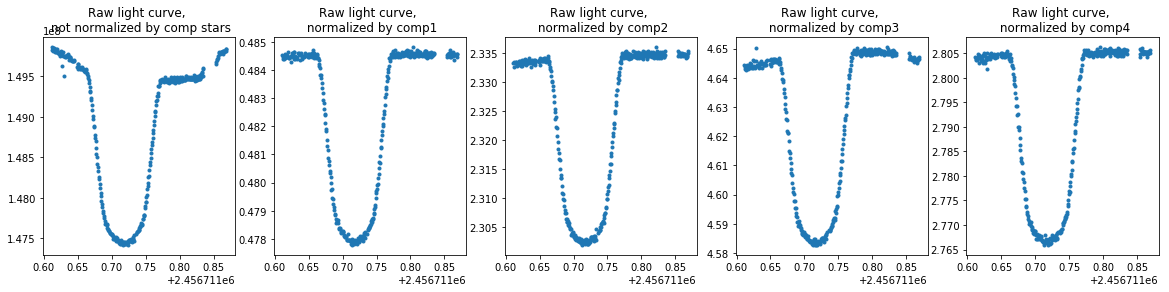

[ 4000.    4001.25  4002.5  ... 10496.25 10497.5  10498.75]






for iteration 1
1/lambda one over 'metric' [254.63258251 169.64952399  71.40677638 196.86965967 141.00805519
 199.53256594]
Constants [0.00109345 0.00074594 0.00077249 0.00122393 0.00059739 0.00078979]


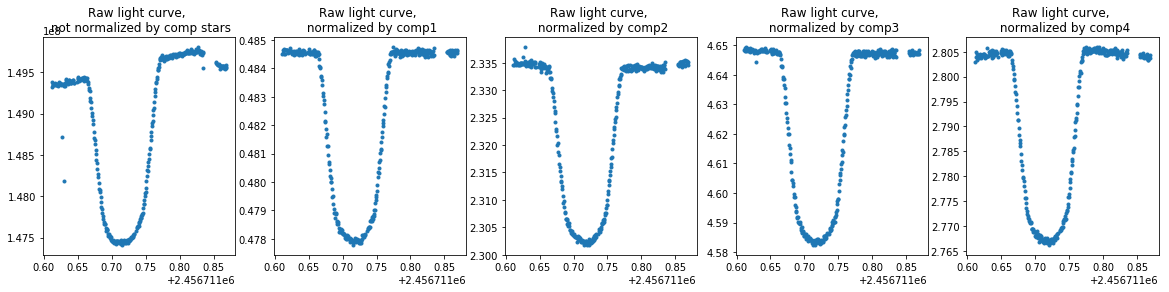

[ 4000.    4001.25  4002.5  ... 10496.25 10497.5  10498.75]






for iteration 2
1/lambda one over 'metric' [ 58.88388603 107.70224995 255.1761986  122.28513832  64.65735804
 144.78784099]
Constants [0.00070835 0.00103378 0.00121853 0.00072521 0.0009294  0.00064242]


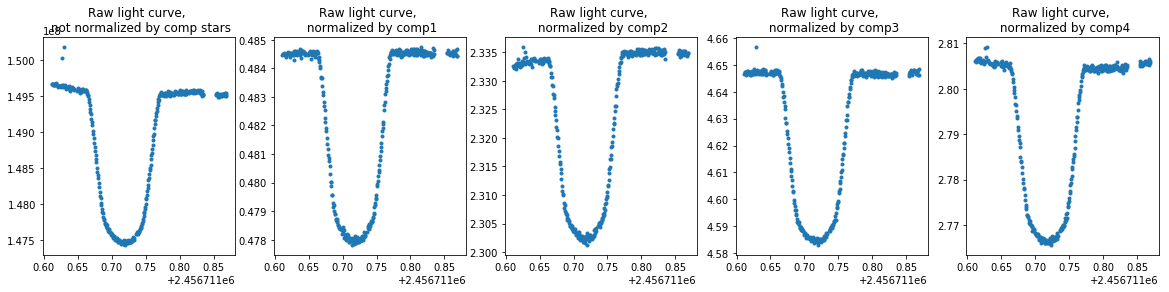

[ 4000.    4001.25  4002.5  ... 10496.25 10497.5  10498.75]






for iteration 3
1/lambda one over 'metric' [278.66472901 344.99313731 283.18500795 102.56643051 268.2963762
  55.92547776]
Constants [0.00117549 0.00105688 0.0011642  0.00137195 0.00062188 0.00132094]


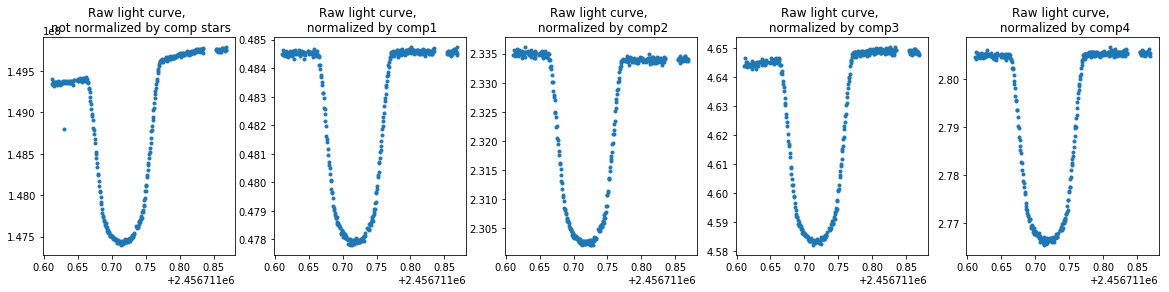

[ 4000.    4001.25  4002.5  ... 10496.25 10497.5  10498.75]






for iteration 4
1/lambda one over 'metric' [ 91.6622499   69.39684152  75.70021432 158.3388492  324.13785506
 118.4797719 ]
Constants [0.00111224 0.00096645 0.00145904 0.000758   0.00142482 0.00111245]


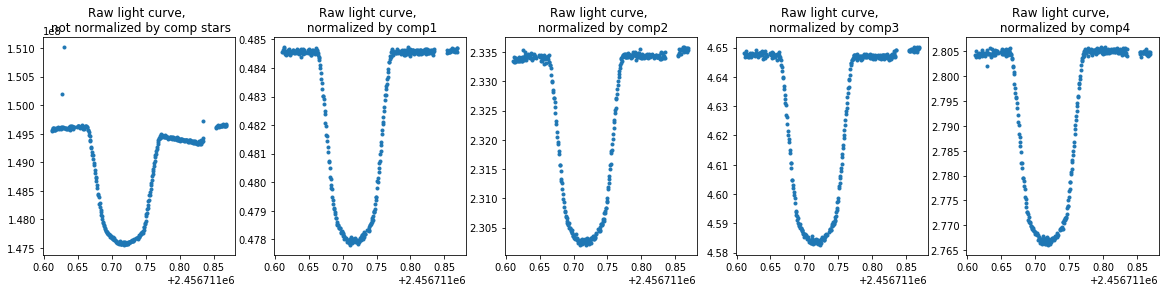

[ 4000.    4001.25  4002.5  ... 10496.25 10497.5  10498.75]






for iteration 5
1/lambda one over 'metric' [143.99505404 385.59391628 370.58547387 318.44922183 275.02430007
 232.95056303]
Constants [0.00062079 0.00118257 0.00128287 0.00054215 0.00133509 0.00094326]


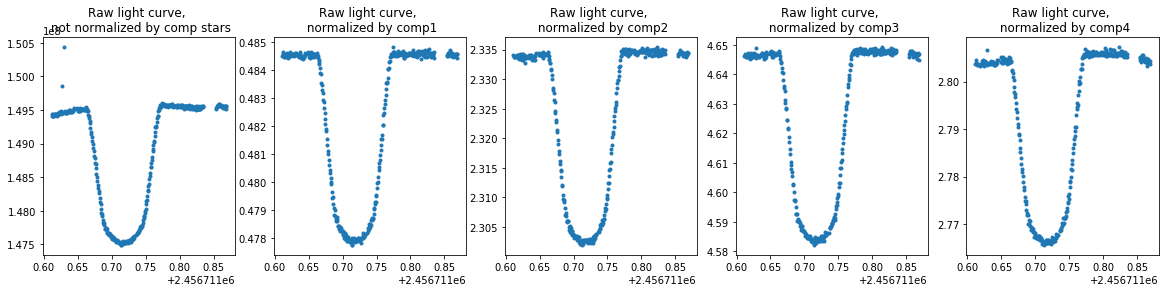

[ 4000.    4001.25  4002.5  ... 10496.25 10497.5  10498.75]






for iteration 6
1/lambda one over 'metric' [ 94.58296647 333.72743791 155.31941908  85.95973866 369.97848295
 110.89302629]
Constants [0.00119535 0.00146281 0.00128847 0.00052755 0.00136589 0.00135285]


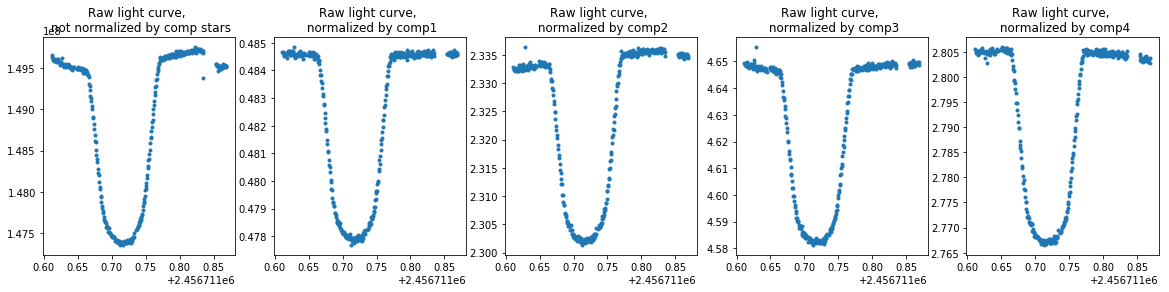

[ 4000.    4001.25  4002.5  ... 10496.25 10497.5  10498.75]






for iteration 7
1/lambda one over 'metric' [339.89150873 228.67008091  71.06428137 102.72223117 363.24326985
  70.98287117]
Constants [0.00139364 0.00117685 0.00063475 0.00055178 0.00070431 0.00053496]


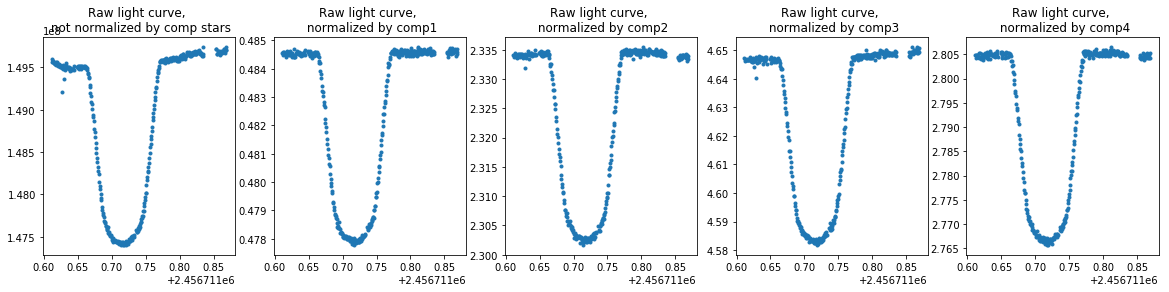

[ 4000.    4001.25  4002.5  ... 10496.25 10497.5  10498.75]






for iteration 8
1/lambda one over 'metric' [ 74.88916469  61.11693824 114.27840026 211.77205657 288.6056844
  61.77697175]
Constants [0.00139969 0.0013113  0.00140424 0.00059996 0.00140795 0.00120617]


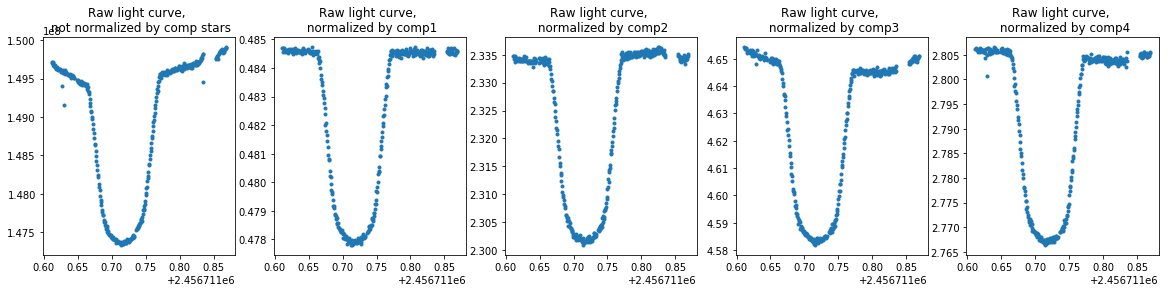

[ 4000.    4001.25  4002.5  ... 10496.25 10497.5  10498.75]






for iteration 9
1/lambda one over 'metric' [ 71.31696793 272.98193452  80.29989259  59.24345144  96.93045997
  55.27987715]
Constants [0.00067266 0.00139004 0.00109469 0.00136471 0.00118875 0.0006326 ]


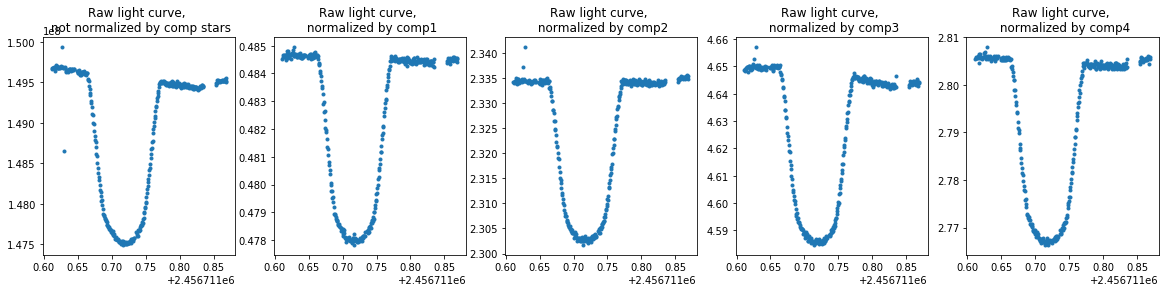

[ 4000.    4001.25  4002.5  ... 10496.25 10497.5  10498.75]






for iteration 10
1/lambda one over 'metric' [ 69.30901035 141.14492162 205.91851984 225.16352781  66.90320119
 293.33303432]
Constants [0.00106024 0.00115412 0.0012281  0.00095063 0.00094506 0.00118955]


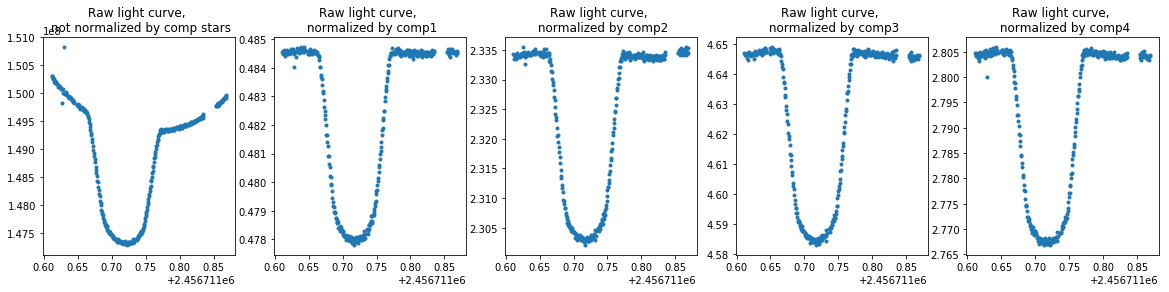

[ 4000.    4001.25  4002.5  ... 10496.25 10497.5  10498.75]






for iteration 11
1/lambda one over 'metric' [ 98.92072392  81.48380378 116.76282908 232.62285969  63.84793722
 262.13538619]
Constants [0.00147775 0.0008648  0.00117633 0.00149289 0.00100465 0.0008647 ]


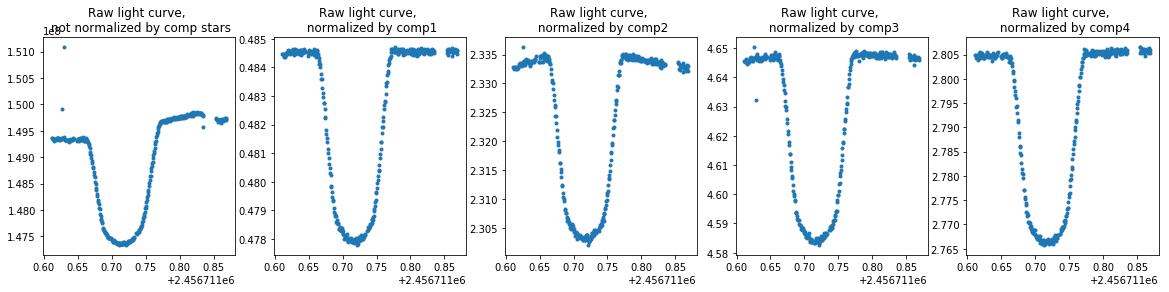

[ 4000.    4001.25  4002.5  ... 10496.25 10497.5  10498.75]






for iteration 12
1/lambda one over 'metric' [134.91717132  70.57337684 145.86610902 175.93243715 386.45122188
 324.54911439]
Constants [0.00103311 0.00098118 0.00107706 0.00070578 0.00147724 0.00113521]


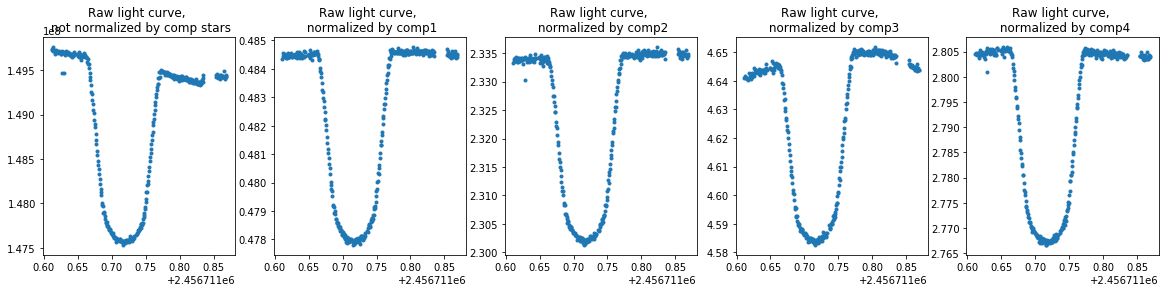

[ 4000.    4001.25  4002.5  ... 10496.25 10497.5  10498.75]






for iteration 13
1/lambda one over 'metric' [ 93.07785946 182.47400821 379.00486442 303.86936898 152.72756649
 206.88632319]
Constants [0.00111417 0.0008301  0.00110153 0.00121231 0.00058603 0.00113597]


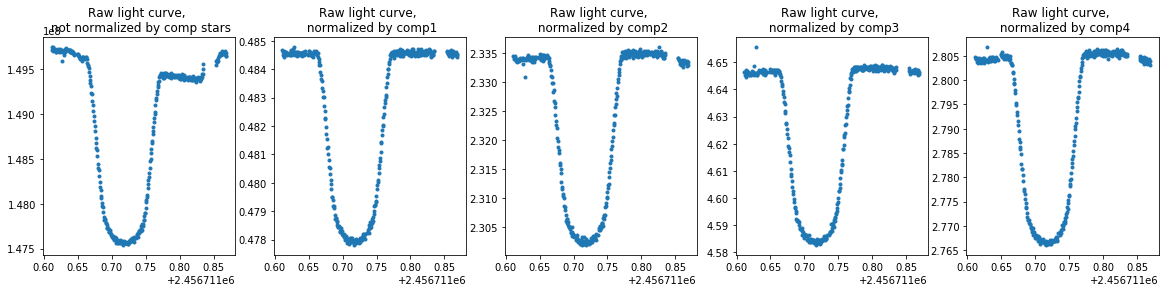

[ 4000.    4001.25  4002.5  ... 10496.25 10497.5  10498.75]






for iteration 14
1/lambda one over 'metric' [255.36966126  87.61211396 370.51156557 309.96771546  76.20511762
 377.58323155]
Constants [0.00119002 0.00116499 0.0005994  0.00072648 0.00060979 0.00123258]


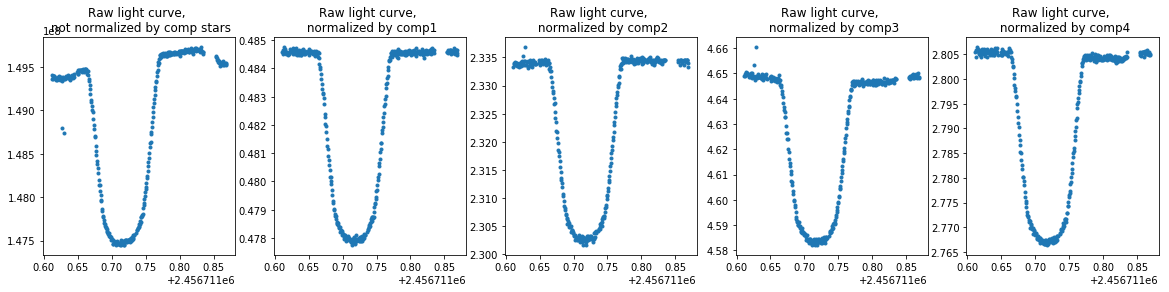

[ 4000.    4001.25  4002.5  ... 10496.25 10497.5  10498.75]






for iteration 15
1/lambda one over 'metric' [269.69280522  94.25680536  90.52107682 373.62086736 378.34264446
 325.34917001]
Constants [0.00111572 0.00059858 0.00063473 0.00149786 0.00079359 0.00054074]


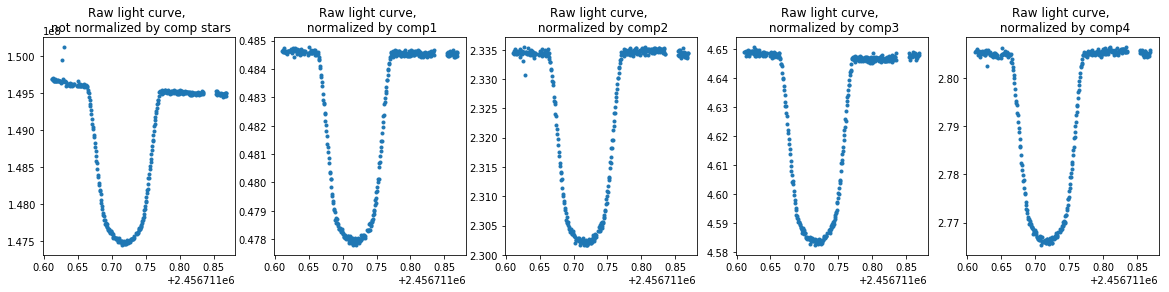

[ 4000.    4001.25  4002.5  ... 10496.25 10497.5  10498.75]






for iteration 16
1/lambda one over 'metric' [302.8569589  192.6976773   74.39049675  58.20574946  89.02550026
 227.06023027]
Constants [0.00055545 0.00122891 0.00130073 0.00076858 0.00065943 0.00073763]


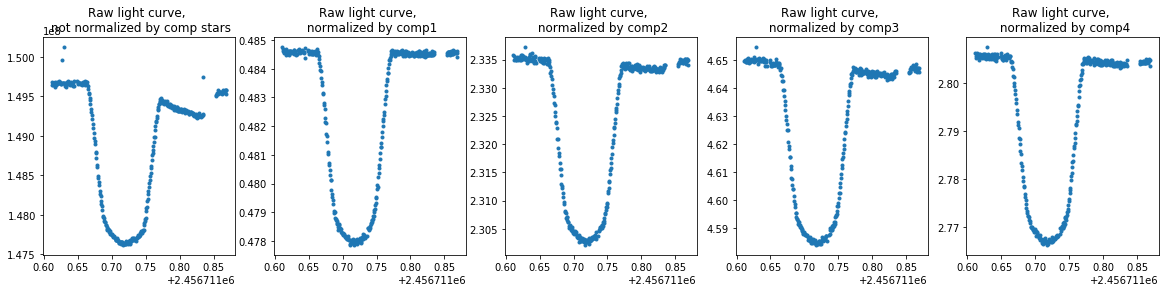

[ 4000.    4001.25  4002.5  ... 10496.25 10497.5  10498.75]






for iteration 17
1/lambda one over 'metric' [141.36728441 175.20529103  58.15402949  60.12520734 127.83803695
 150.52515612]
Constants [0.00074725 0.00140209 0.00057324 0.00090191 0.00117766 0.00089995]


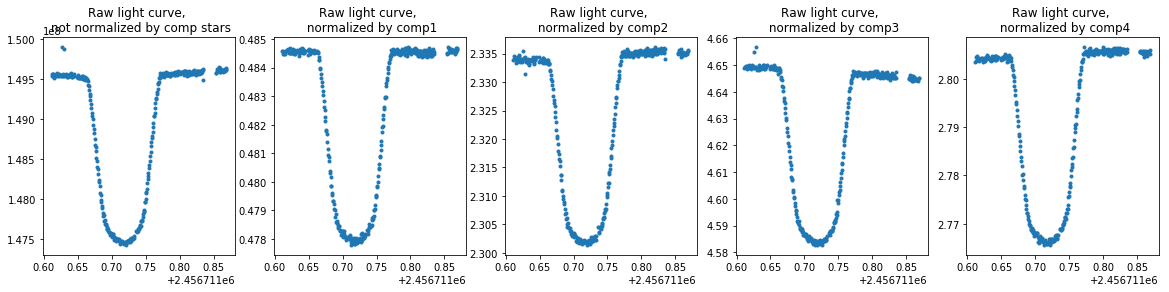

[ 4000.    4001.25  4002.5  ... 10496.25 10497.5  10498.75]






for iteration 18
1/lambda one over 'metric' [319.3225357   82.76054511 172.24420715 134.30124336 145.60118151
  77.53169732]
Constants [0.00140701 0.00089861 0.00078112 0.00098218 0.00142209 0.00135205]


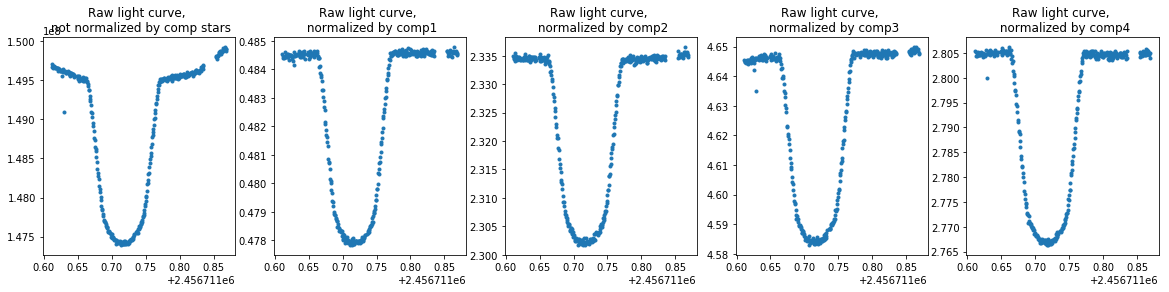

[ 4000.    4001.25  4002.5  ... 10496.25 10497.5  10498.75]






for iteration 19
1/lambda one over 'metric' [192.40120634 342.98824128 135.9460184   73.48880863 263.25808634
 114.78771539]
Constants [0.00075798 0.00100948 0.00135566 0.00102066 0.0012927  0.00068082]


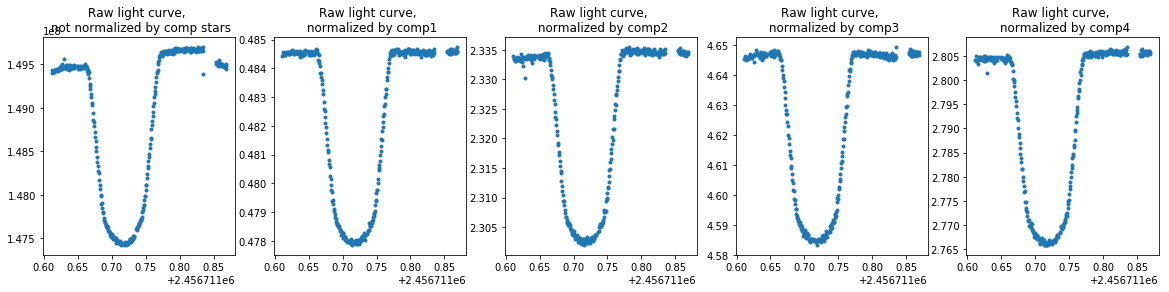

[ 4000.    4001.25  4002.5  ... 10496.25 10497.5  10498.75]






for iteration 20
1/lambda one over 'metric' [344.24744469 114.75447385  83.69996244 390.49986635 195.39881365
  60.85192148]
Constants [0.00098339 0.0011885  0.00143578 0.0012415  0.00131304 0.00052639]


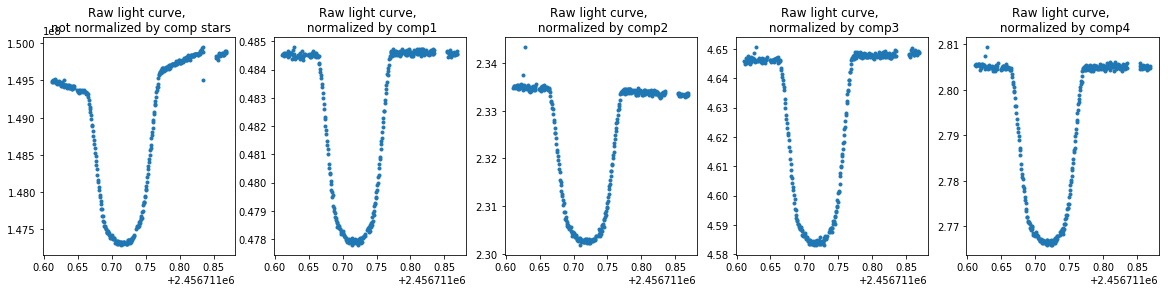

[ 4000.    4001.25  4002.5  ... 10496.25 10497.5  10498.75]








In [35]:
for step in range(0,21):
    print 'for iteration', step
    ###======================= To produce main trend that's identical to all comps =================###
    #number closer to -1 makes the function more dependent on external parameters
    inv_ln_alpha = np.random.uniform(-6.0, -4.0, 6)
    inv_alpha = np.exp(inv_ln_alpha)
    lambDa = 1.0/inv_alpha
    print "1/lambda one over 'metric'", lambDa

    #number closer to -1 makes the functions more dependent on external parameters
    Const = np.random.uniform(.5e-3,1.5e-3, 6)
    print 'Constants', Const
    k1 = Const[0]*george.kernels.ExpSquaredKernel(lambDa[0], axes= 0, ndim = 5)
    k2 = Const[1]*george.kernels.ExpSquaredKernel(lambDa[1], axes= 1, ndim = 5)
    k3 = Const[2]*george.kernels.ExpSquaredKernel(lambDa[2], axes= 2, ndim = 5)
    k4 = Const[3]*george.kernels.ExpSquaredKernel(lambDa[3], axes= 3, ndim = 5)
    k5 = Const[4]*george.kernels.ExpSquaredKernel(lambDa[4], axes= 4, ndim = 5)

    GP_Main = george.GP(k1+k2+k3+k4+k5)
    gp_kernel_inputs_Main = np.array([StrndAir, StrndDelWav, StrndTrcCen, StrndTim, StrndSkyFlx])
    GP_Main.compute(gp_kernel_inputs_Main.T)


    LC_t = []
    LC_c1 = []
    LC_c2 = []
    LC_c3 = []
    LC_c4 = []
    BINS = Binns #bins based of true data
    Error = LC_error
    for binn in range(Good_LC.shape[1]): 
        #Here sampling from GP priors to simulate random unknown dependencies of external parameters 
        gp_y_valuesMain = GP_Main.sample(gp_kernel_inputs_Main.T)

        # for target
        MeanFlux = np.mean(WL_transit_data['WASP31'][:,binn])
        Main_Eff = (gp_y_valuesMain-gp_y_valuesMain.mean())*MeanFlux
        std = MeanFlux*Error[binn] #noise level specific to each bin. 
        noise = np.random.normal(0, std, len(WL_transit_data['WASP31'][:,binn]))
        LC = Main_Eff + noise + (Good_LC[:,binn]*MeanFlux)
        LC_t.append(LC)
    
        # for comp1
        MeanFlux = np.mean(WL_transit_data['comp1'][:,binn])
        Main_Eff = (gp_y_valuesMain-gp_y_valuesMain.mean())*MeanFlux
        std = MeanFlux*Error[binn]
        noise = np.random.normal(0, std, len(WL_transit_data['comp1'][:,binn]))
        LC = Main_Eff + noise + MeanFlux
        LC_c1.append(LC)

        # for comp2
        MeanFlux = np.mean(WL_transit_data['comp2'][:,binn])
        Main_Eff = (gp_y_valuesMain-gp_y_valuesMain.mean())*MeanFlux
        std = MeanFlux*Error[binn]
        noise = np.random.normal(0, std, len(WL_transit_data['comp2'][:,binn]))
        LC = Main_Eff + noise + MeanFlux
        LC_c2.append(LC)

        # for comp3
        MeanFlux = np.mean(WL_transit_data['comp3'][:,binn])
        Main_Eff = (gp_y_valuesMain-gp_y_valuesMain.mean())*MeanFlux
        std =MeanFlux*Error[binn]
        noise = np.random.normal(0, std, len(WL_transit_data['comp3'][:,binn]))
        LC = Main_Eff + noise + MeanFlux
        LC_c3.append(LC)

        # for comp4
        MeanFlux = np.mean(WL_transit_data['comp4'][:,binn])
        Main_Eff = (gp_y_valuesMain-gp_y_valuesMain.mean())*MeanFlux
        std = MeanFlux*Error[binn]
        noise = np.random.normal(0, std, len(WL_transit_data['comp4'][:,binn]))
        LC = Main_Eff + noise + MeanFlux
        LC_c4.append(LC)

    LC_targ_withT = np.array(LC_t)
    LC_c1_withT = np.array(LC_c1)
    LC_c2_withT = np.array(LC_c2)
    LC_c3_withT = np.array(LC_c3)
    LC_c4_withT = np.array(LC_c4)

    WLC_t = np.sum(LC_targ_withT, axis = 0)
    WLC_c1 = np.sum(LC_c1_withT, axis = 0)
    WLC_c2 = np.sum(LC_c2_withT, axis = 0)
    WLC_c3 = np.sum(LC_c3_withT, axis = 0)
    WLC_c4 = np.sum(LC_c4_withT, axis = 0)

    plt.figure(0, figsize = (20,4))
    plt.subplot(151)
    plt.title('Raw light curve, \n not normalized by comp stars')
    plt.plot(Times, WLC_t, '.')
    plt.subplot(152)
    plt.title('Raw light curve, \n normalized by comp1')
    plt.plot(Times, WLC_t/WLC_c1, '.')
    plt.subplot(153)
    plt.title('Raw light curve, \n normalized by comp2')
    plt.plot(Times, WLC_t/WLC_c2, '.')
    plt.subplot(154)
    plt.title('Raw light curve, \n normalized by comp3')
    plt.plot(Times, WLC_t/WLC_c3, '.')
    plt.subplot(155)
    plt.title('Raw light curve, \n normalized by comp4')
    plt.plot(Times, WLC_t/WLC_c4, '.')
    plt.show()
    plt.close()

    Synthetic = {}
    Synthetic['t'] = Times
    Synthetic['cNames'] = ['comp1','comp2', 'comp3', 'comp4']
    cLC = np.array([WLC_c1, WLC_c2,WLC_c3, WLC_c4])
    Synthetic['cLC'] = cLC.T
    Synthetic['oLC'] = WLC_t
    wbins = []
    for i in range(len(bnB)):
        wbins.append([bnB[i], bnT[i]])
    Synthetic['wbins'] = wbins
    Synthetic['oLCw'] = LC_targ_withT.T
    cLCw = np.array([LC_c1_withT.T,LC_c2_withT.T,LC_c3_withT.T,LC_c4_withT.T])
    Synthetic['cLCw'] = RESHAPE(cLCw)

    # Need it for the polyfit
    Synthetic['etimes'] = Raw_LC['etimes'][Good_idx] 
    Synthetic['spectra'] = {}
    Synthetic['spectra']['wavelengths'] = Raw_LC['spectra']['wavelengths']
    Synthetic['spectra']['WASP31'] = None
    Synthetic['spectra']['comp1'] = None 
    Synthetic['spectra']['comp2'] = None 
    Synthetic['spectra']['comp3'] = None
    Synthetic['spectra']['comp4'] = None
    print Synthetic['spectra']['wavelengths']

    #Now to save to pickle file
    name = 'SynSpecOb3/Tst'+str(step)+'/LCs_114S'+str(step)+'.pkl'
    FilE = open(name, 'wb')
    pickle.dump(Synthetic, FilE)
    FilE.close()
    
    print "\n"
    print "\n"
    print "\n"

# END OF MAIN PART OF JUPYTER NOTEBOOK

### 3) To read synthetic tests results:
#### (Results were produced in the cluster, Hydra, because of the large amount of data I was testing)

In [14]:
# Ex submission: Errors([RpRs_CMC,RpRs_u_CMC, RpRs_l_CMC], RpRss)
def Errors(DetrendData, SynData):
    DetndErrBars = np.array([])
    Error = np.array([])
    if len(DetrendData[0]) != len(SynData):
        print "The detrended data you gave doesn't have the same binning scheme as the synthetic data!!!"
        print 'len(DetrendData[0]) =', len(DetrendData[0]), 'len(SynData) =', len(SynData)
        print 'EXITING!'
        sys.exit()
    for i in range(len(DetrendData[0])): 
        error = abs(SynData[i]-DetrendData[0][i])/(SynData[i]*1.0)
        Error = np.append(Error, error)
        DetndErrBars = np.append(DetndErrBars, abs(DetrendData[1][i])+abs(DetrendData[2][i]))
    return Error,DetndErrBars 

In [15]:
def Stats(test_name, CMC = True):
    Files = glob.glob(test_name+'*')
    MeanErr = np.zeros(len(Files))
    MeanNorErr = np.zeros(len(Files))
    MeanErrBar = np.zeros(len(Files))
    for f in range(len(Files)): # To pull out mean error and error bars from files
        if CMC: 
            dot_dat = Files[f]+'/transpec_cmc.dat'
        else: #Must be using PCA
            dot_dat = Files[f]+'/transpec.dat'
        WavLow,WavUP,rprs,rprs_U,rprs_L,Depth,Depthup,DepthDown,IDK1,IDK2,IDK3= np.loadtxt(dot_dat, unpack = True)
        Error,Errbars = Errors([rprs,rprs_U, rprs_L], RpRss)
        #To normalize the amplitude of the transmission spectrum. Incase the fit shifted everything upwards
        rprs_correction = np.mean(rprs) - np.mean(RpRss)
        rprs_Norm = rprs - rprs_correction
        Norm_Error,Norm_Errbars = Errors([rprs_Norm,rprs_U, rprs_L], RpRss)
        MeanErr[f] = np.mean(Error)
        MeanNorErr[f] = np.mean(Norm_Error)
        MeanErrBar[f] = np.mean(Errbars)
    return MeanErr, MeanNorErr, MeanErrBar

mean error for Synthetic data: 0.004690607095652173


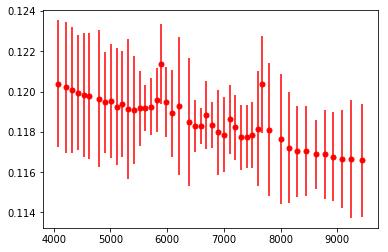

In [16]:
plt.errorbar(Binns, RpRss, fmt = '.', color ='r', yerr = [LC_errorBar, LC_errorBar], markersize = 10, label = 'true values')
SynaErrBars = np.array([])
for i in range(len(RpRss)): 
    SynaErrBars = np.append(SynaErrBars, abs(LC_errorBar[i])+abs(LC_errorBar[i]))
print 'mean error for Synthetic data:', np.mean(SynaErrBars)

To get the mean error bars for each final dataset

In [17]:
def FinalStats(File):
    WavLow,WavUP,rprs,rprs_U,rprs_L,Depth,Depthup,DepthDown,IDK1,IDK2,IDK3= np.loadtxt(File, unpack = True)
    EBmean = np.mean(rprs_U+rprs_L)/2.0
    return EBmean

In [17]:
File_name1 = '/Users/chimamcgruder/Hydra/Copy0/GPTransmissionSpectra/outputs/WASP31/ut130226/LC114/BstPar/transpec.dat'
File_name2 = '/Users/chimamcgruder/Hydra/Copy0/GPTransmissionSpectra/outputs/WASP31/ut130425/LC114/BstParPCA/transpec.dat'
print FinalStats(File_name1)
print FinalStats(File_name2)

0.006536440673333333
0.0034508079944444454


To do statistics on mean error and error bars

mean Error of PCA=0.007972663277026988+0.007266497906848031-0.008279076768753594
mean Error of Normalize PCA=0.0061886893807691435+0.005157631099473264-0.00704911352100821
mean Error bars of PCA=0.0014424060557575759+0.0012686092013333332-0.0016021172768888891


mean Error of CMC=0.0076832528741245165+0.005630692398079231-0.00961301281050625
mean Error of Normalized CMC=0.004801360747187553+0.004187336713643129-0.005454001094742169
mean Error bars of CMC=0.001512971198181818+0.0012608604026666664-0.0018222892164444443


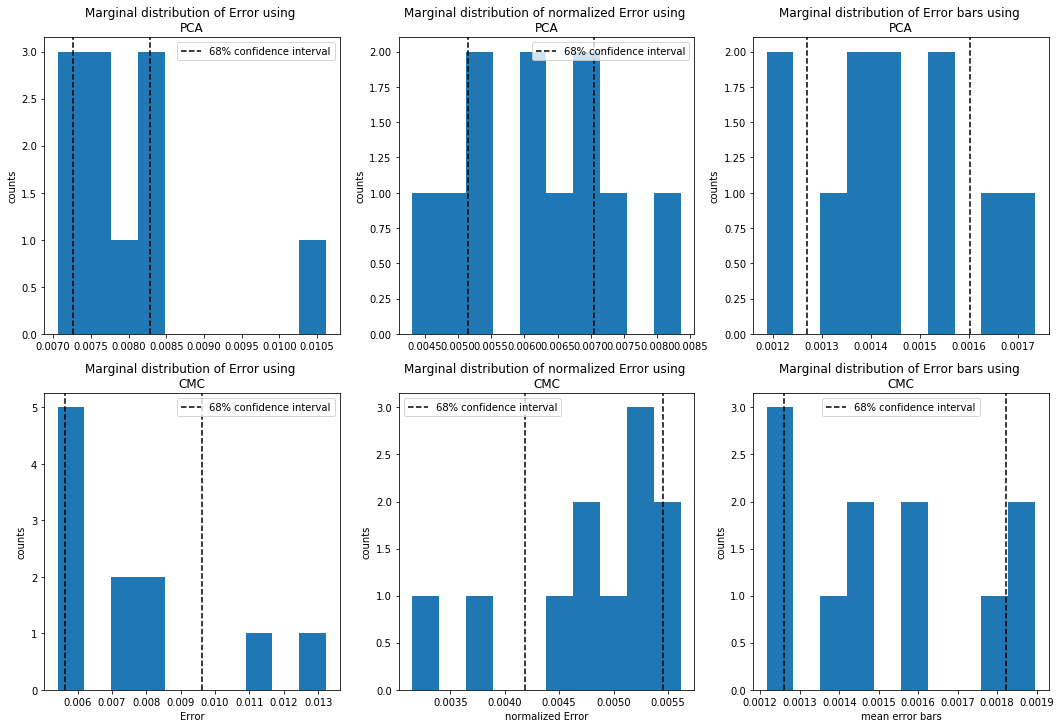

In [31]:
#For 1st comparison
one = 'PCA'
two = 'CMC'
File_name1 = '/Users/chimamcgruder/Hydra/Copy0/GPTransmissionSpectra/outputs/WASP31/ut130425/LC114C/Tstp' #unique path name of where the information is saved
File_name2 = '/Users/chimamcgruder/Hydra/Copy0/GPTransmissionSpectra/outputs/WASP31/ut130425/LC114C/Tstc' #unique path name of where the information is saved
PCI = 68 # percent confidence interval
M_Err1, M_NorErr1, M_ErrBar1 = Stats(File_name1, CMC = False)
M_Err2, M_NorErr2, M_ErrBar2 = Stats(File_name2)
plt.figure(0, figsize = (18,12))

credible = np.percentile(M_Err1, [50-(PCI/2.0),50+(PCI/2.0)])
plt.subplot(231)
plt.ylabel('counts')
plt.hist(M_Err1)
plt.axvline(credible[0], 0, 1, color='k', linestyle='dashed', label=str(PCI)+'% confidence interval')
plt.axvline(credible[1], 0, 1, color='k', linestyle='dashed')
plt.title('Marginal distribution of Error using \n'+one)
print 'mean accuracy of'+one+'='+str(np.mean(M_Err1))+'+'+str(credible[0])+'-'+str(credible[1])
plt.legend()

credible = np.percentile(M_NorErr1, [50-(PCI/2.0),50+(PCI/2.0)])
plt.subplot(232)
plt.ylabel('counts')
plt.hist(M_NorErr1)
plt.axvline(credible[0], 0, 1, color='k', linestyle='dashed', label=str(PCI)+'% confidence interval')
plt.axvline(credible[1], 0, 1, color='k', linestyle='dashed')
plt.title('Marginal distribution of normalized Error using \n'+one)
print 'mean accuracy of Normalize '+one+'='+str(np.mean(M_NorErr1))+'+'+str(credible[0])+'-'+str(credible[1])
plt.legend()

credible = np.percentile(M_ErrBar1, [50-(PCI/2.0),50+(PCI/2.0)])
plt.subplot(233)
plt.ylabel('counts')
plt.hist(M_ErrBar1)
plt.axvline(credible[0], 0, 1, color='k', linestyle='dashed', label=str(PCI)+'% confidence interval')
plt.axvline(credible[1], 0, 1, color='k', linestyle='dashed')
plt.title('Marginal distribution of Error bars using \n'+one)
print 'mean precision of '+one+'='+str(np.mean(M_ErrBar1))+'+'+str(credible[0])+'-'+str(credible[1])
print '\n'
credible = np.percentile(M_Err2, [50-(PCI/2.0),50+(PCI/2.0)])
plt.subplot(234)
plt.xlabel('Error')
plt.ylabel('counts')
plt.hist(M_Err2)
plt.axvline(credible[0], 0, 1, color='k', linestyle='dashed', label=str(PCI)+'% confidence interval')
plt.axvline(credible[1], 0, 1, color='k', linestyle='dashed')
plt.title('Marginal distribution of Error using \n'+two)
print 'mean accuracy of '+two+'='+str(np.mean(M_Err2))+'+'+str(credible[0])+'-'+str(credible[1])
plt.legend()

credible = np.percentile(M_NorErr2, [50-(PCI/2.0),50+(PCI/2.0)])
plt.subplot(235)
plt.xlabel('normalized Error')
plt.ylabel('counts')
plt.hist(M_NorErr2)
plt.axvline(credible[0], 0, 1, color='k', linestyle='dashed', label=str(PCI)+'% confidence interval')
plt.axvline(credible[1], 0, 1, color='k', linestyle='dashed')
plt.title('Marginal distribution of normalized Error using \n'+two)
print 'mean accuracy of Normalized '+two+'='+str(np.mean(M_NorErr2))+'+'+str(credible[0])+'-'+str(credible[1])
plt.legend()

credible = np.percentile(M_ErrBar2, [50-(PCI/2.0),50+(PCI/2.0)])
plt.subplot(236)
plt.xlabel('mean error bars')
plt.ylabel('counts')
plt.hist(M_ErrBar2)
plt.axvline(credible[0], 0, 1, color='k', linestyle='dashed', label=str(PCI)+'% confidence interval')
plt.axvline(credible[1], 0, 1, color='k', linestyle='dashed')
plt.title('Marginal distribution of Error bars using \n'+two)
print 'mean precision of '+two+'='+str(np.mean(M_ErrBar2))+'+'+str(credible[0])+'-'+str(credible[1])
plt.legend()
plt.legend()
plt.show()

Use both pca and cmc correction because the error bars on the accuracy and precision of both are the same size as the found accuracy and precision

mean accuracy of amplitude=0.00940240146058097+0.0058599181210108615-0.012360979150596179
mean accuracy of Normalize amplitude=0.00532525751818593+0.004721099469385044-0.006014519421422983
mean precision of amplitude=0.0018157728869565213+0.0015626500373913043-0.002027172015217391


mean accuracy of normal=0.009265684925459672+0.006179347196945281-0.012139768678947676
mean accuracy of Normalized normal=0.005356189630958309+0.004701949994762947-0.006179877867454142
mean precision of normal=0.0016842648667701862+0.0014456396760869562-0.0018807396578260868


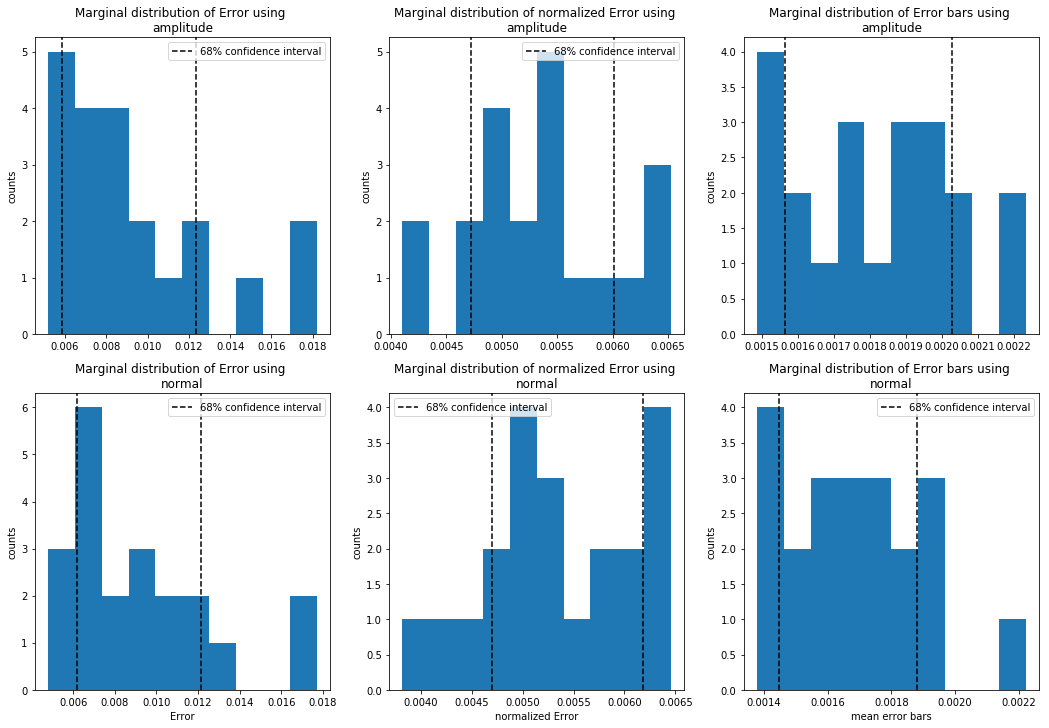

In [21]:
one = 'amplitude' #For 1st comparison
two = 'normal'
File_name1 = '/Users/chimamcgruder/Hydra/Copy0/GPTransmissionSpectra/outputs/WASP31/ut140222/LC114A/TstA' #unique path name of where the information is saved
File_name2 = '/Users/chimamcgruder/Hydra/Copy0/GPTransmissionSpectra/outputs/WASP31/ut140222/LC114N/TstN' #unique path name of where the information is saved
PCI = 68 # percent confidence interval
M_Err1, M_NorErr1, M_ErrBar1 = Stats(File_name1)
M_Err2, M_NorErr2, M_ErrBar2 = Stats(File_name2)
plt.figure(0, figsize = (18,12))

credible = np.percentile(M_Err1, [50-(PCI/2.0),50+(PCI/2.0)])
plt.subplot(231)
plt.ylabel('counts')
plt.hist(M_Err1)
plt.axvline(credible[0], 0, 1, color='k', linestyle='dashed', label=str(PCI)+'% confidence interval')
plt.axvline(credible[1], 0, 1, color='k', linestyle='dashed')
plt.title('Marginal distribution of Error using \n'+one)
print 'mean accuracy of '+one+'='+str(np.mean(M_Err1))+'+'+str(credible[0])+'-'+str(credible[1])
plt.legend()

credible = np.percentile(M_NorErr1, [50-(PCI/2.0),50+(PCI/2.0)])
plt.subplot(232)
plt.ylabel('counts')
plt.hist(M_NorErr1)
plt.axvline(credible[0], 0, 1, color='k', linestyle='dashed', label=str(PCI)+'% confidence interval')
plt.axvline(credible[1], 0, 1, color='k', linestyle='dashed')
plt.title('Marginal distribution of normalized Error using \n'+one)
print 'mean accuracy of Normalize '+one+'='+str(np.mean(M_NorErr1))+'+'+str(credible[0])+'-'+str(credible[1])
plt.legend()

credible = np.percentile(M_ErrBar1, [50-(PCI/2.0),50+(PCI/2.0)])
plt.subplot(233)
plt.ylabel('counts')
plt.hist(M_ErrBar1)
plt.axvline(credible[0], 0, 1, color='k', linestyle='dashed', label=str(PCI)+'% confidence interval')
plt.axvline(credible[1], 0, 1, color='k', linestyle='dashed')
plt.title('Marginal distribution of Error bars using \n'+one)
print 'mean precision of '+one+'='+str(np.mean(M_ErrBar1))+'+'+str(credible[0])+'-'+str(credible[1])
print '\n'
credible = np.percentile(M_Err2, [50-(PCI/2.0),50+(PCI/2.0)])
plt.subplot(234)
plt.xlabel('Error')
plt.ylabel('counts')
plt.hist(M_Err2)
plt.axvline(credible[0], 0, 1, color='k', linestyle='dashed', label=str(PCI)+'% confidence interval')
plt.axvline(credible[1], 0, 1, color='k', linestyle='dashed')
plt.title('Marginal distribution of Error using \n'+two)
print 'mean accuracy of '+two+'='+str(np.mean(M_Err2))+'+'+str(credible[0])+'-'+str(credible[1])
plt.legend()

credible = np.percentile(M_NorErr2, [50-(PCI/2.0),50+(PCI/2.0)])
plt.subplot(235)
plt.xlabel('normalized Error')
plt.ylabel('counts')
plt.hist(M_NorErr2)
plt.axvline(credible[0], 0, 1, color='k', linestyle='dashed', label=str(PCI)+'% confidence interval')
plt.axvline(credible[1], 0, 1, color='k', linestyle='dashed')
plt.title('Marginal distribution of normalized Error using \n'+two)
print 'mean accuracy of Normalized '+two+'='+str(np.mean(M_NorErr2))+'+'+str(credible[0])+'-'+str(credible[1])
plt.legend()

credible = np.percentile(M_ErrBar2, [50-(PCI/2.0),50+(PCI/2.0)])
plt.subplot(236)
plt.xlabel('mean error bars')
plt.ylabel('counts')
plt.hist(M_ErrBar2)
plt.axvline(credible[0], 0, 1, color='k', linestyle='dashed', label=str(PCI)+'% confidence interval')
plt.axvline(credible[1], 0, 1, color='k', linestyle='dashed')
plt.title('Marginal distribution of Error bars using \n'+two)
print 'mean precision of '+two+'='+str(np.mean(M_ErrBar2))+'+'+str(credible[0])+'-'+str(credible[1])
plt.legend()
plt.legend()
plt.show()

mean accuracy of length scale bounds=0.009733106108316283+0.006257373347983516-0.014392552025530617
mean accuracy of Normalize length scale bounds=0.005757586929558382+0.005236390075553383-0.0065333035892434855
mean precision of length scale bounds=0.0021541428943064184+0.001993741709565217-0.0023273441743478264


mean accuracy of normal=0.009265684925459672+0.006179347196945281-0.012139768678947676
mean accuracy of Normalized normal=0.005356189630958309+0.004701949994762947-0.006179877867454142
mean precision of normal=0.0016842648667701862+0.0014456396760869562-0.0018807396578260868


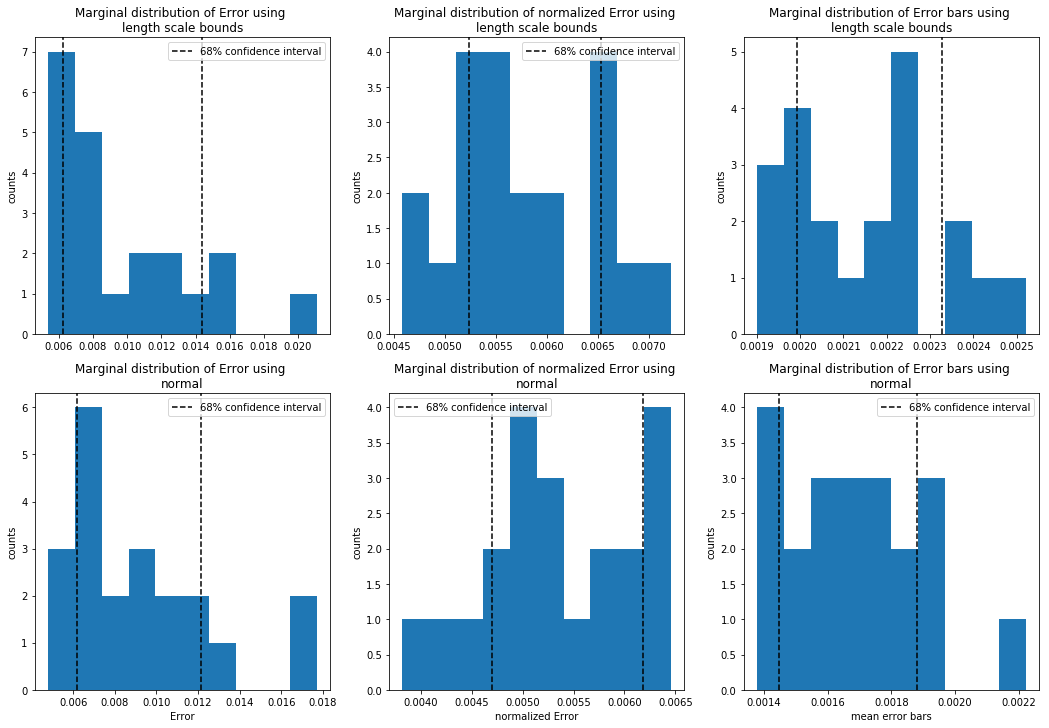

In [22]:
one = 'length scale bounds' #For 1st comparison
two = 'normal'
File_name1 = '/Users/chimamcgruder/Hydra/Copy0/GPTransmissionSpectra/outputs/WASP31/ut140222/LC114l/Tstl' #unique path name of where the information is saved
File_name2 = '/Users/chimamcgruder/Hydra/Copy0/GPTransmissionSpectra/outputs/WASP31/ut140222/LC114N/TstN' #unique path name of where the information is saved
PCI = 68 # percent confidence interval
M_Err1, M_NorErr1, M_ErrBar1 = Stats(File_name1)
M_Err2, M_NorErr2, M_ErrBar2 = Stats(File_name2)
plt.figure(0, figsize = (18,12))

credible = np.percentile(M_Err1, [50-(PCI/2.0),50+(PCI/2.0)])
plt.subplot(231)
plt.ylabel('counts')
plt.hist(M_Err1)
plt.axvline(credible[0], 0, 1, color='k', linestyle='dashed', label=str(PCI)+'% confidence interval')
plt.axvline(credible[1], 0, 1, color='k', linestyle='dashed')
plt.title('Marginal distribution of Error using \n'+one)
print 'mean accuracy of '+one+'='+str(np.mean(M_Err1))+'+'+str(credible[0])+'-'+str(credible[1])
plt.legend()

credible = np.percentile(M_NorErr1, [50-(PCI/2.0),50+(PCI/2.0)])
plt.subplot(232)
plt.ylabel('counts')
plt.hist(M_NorErr1)
plt.axvline(credible[0], 0, 1, color='k', linestyle='dashed', label=str(PCI)+'% confidence interval')
plt.axvline(credible[1], 0, 1, color='k', linestyle='dashed')
plt.title('Marginal distribution of normalized Error using \n'+one)
print 'mean accuracy of Normalize '+one+'='+str(np.mean(M_NorErr1))+'+'+str(credible[0])+'-'+str(credible[1])
plt.legend()

credible = np.percentile(M_ErrBar1, [50-(PCI/2.0),50+(PCI/2.0)])
plt.subplot(233)
plt.ylabel('counts')
plt.hist(M_ErrBar1)
plt.axvline(credible[0], 0, 1, color='k', linestyle='dashed', label=str(PCI)+'% confidence interval')
plt.axvline(credible[1], 0, 1, color='k', linestyle='dashed')
plt.title('Marginal distribution of Error bars using \n'+one)
print 'mean precision of '+one+'='+str(np.mean(M_ErrBar1))+'+'+str(credible[0])+'-'+str(credible[1])
print '\n'
credible = np.percentile(M_Err2, [50-(PCI/2.0),50+(PCI/2.0)])
plt.subplot(234)
plt.xlabel('Error')
plt.ylabel('counts')
plt.hist(M_Err2)
plt.axvline(credible[0], 0, 1, color='k', linestyle='dashed', label=str(PCI)+'% confidence interval')
plt.axvline(credible[1], 0, 1, color='k', linestyle='dashed')
plt.title('Marginal distribution of Error using \n'+two)
print 'mean accuracy of '+two+'='+str(np.mean(M_Err2))+'+'+str(credible[0])+'-'+str(credible[1])
plt.legend()

credible = np.percentile(M_NorErr2, [50-(PCI/2.0),50+(PCI/2.0)])
plt.subplot(235)
plt.xlabel('normalized Error')
plt.ylabel('counts')
plt.hist(M_NorErr2)
plt.axvline(credible[0], 0, 1, color='k', linestyle='dashed', label=str(PCI)+'% confidence interval')
plt.axvline(credible[1], 0, 1, color='k', linestyle='dashed')
plt.title('Marginal distribution of normalized Error using \n'+two)
print 'mean accuracy of Normalized '+two+'='+str(np.mean(M_NorErr2))+'+'+str(credible[0])+'-'+str(credible[1])
plt.legend()

credible = np.percentile(M_ErrBar2, [50-(PCI/2.0),50+(PCI/2.0)])
plt.subplot(236)
plt.xlabel('mean error bars')
plt.ylabel('counts')
plt.hist(M_ErrBar2)
plt.axvline(credible[0], 0, 1, color='k', linestyle='dashed', label=str(PCI)+'% confidence interval')
plt.axvline(credible[1], 0, 1, color='k', linestyle='dashed')
plt.title('Marginal distribution of Error bars using \n'+two)
print 'mean precision of '+two+'='+str(np.mean(M_ErrBar2))+'+'+str(credible[0])+'-'+str(credible[1])
plt.legend()
plt.legend()
plt.show()

mean accuracy of metric = (1/alpha)^2=0.009164784951060637+0.006287462700767245-0.012387836632820757
mean accuracy of Normalize metric = (1/alpha)^2=0.005380077489166818+0.004717836251530398-0.006214034533835319
mean precision of metric = (1/alpha)^2=0.0016857141488612836+0.001446903335652174-0.0018685916904347824


mean accuracy of normal=0.009265684925459672+0.006179347196945281-0.012139768678947676
mean accuracy of Normalized normal=0.005356189630958309+0.004701949994762947-0.006179877867454142
mean precision of normal=0.0016842648667701862+0.0014456396760869562-0.0018807396578260868


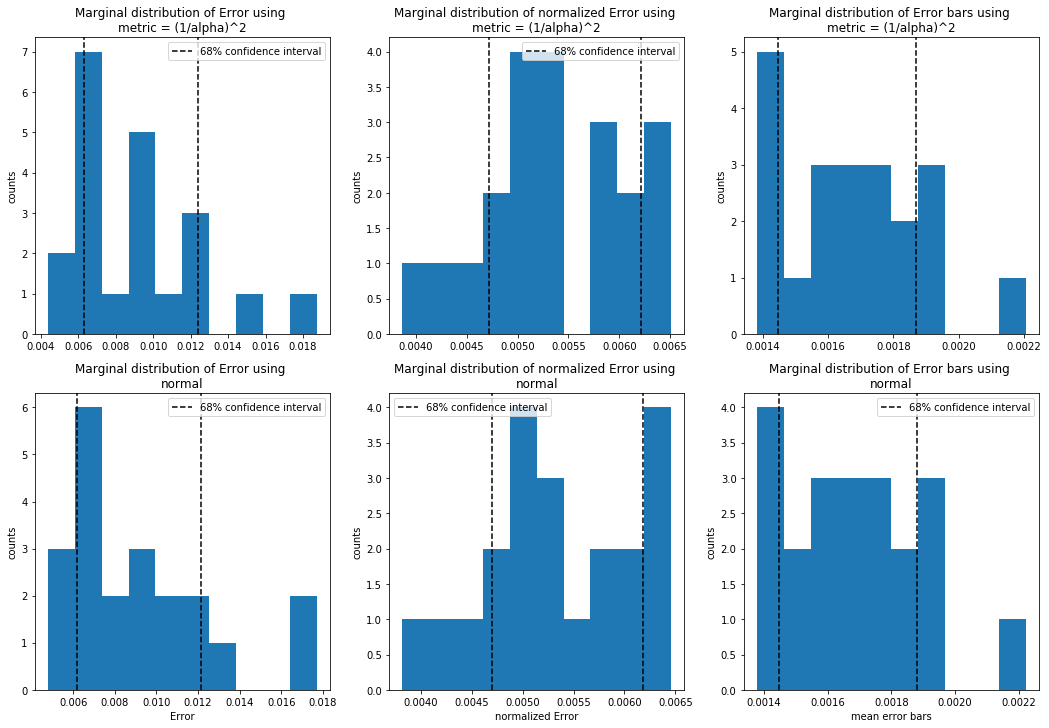

In [23]:
one = 'metric = (1/alpha)^2' #For 1st comparison
two = 'normal'
File_name1 = '/Users/chimamcgruder/Hydra/Copy0/GPTransmissionSpectra/outputs/WASP31/ut140222/LC114L/TstL' #unique path name of where the information is saved
File_name2 = '/Users/chimamcgruder/Hydra/Copy0/GPTransmissionSpectra/outputs/WASP31/ut140222/LC114N/TstN' #unique path name of where the information is saved
PCI = 68 # percent confidence interval
M_Err1, M_NorErr1, M_ErrBar1 = Stats(File_name1)
M_Err2, M_NorErr2, M_ErrBar2 = Stats(File_name2)
plt.figure(0, figsize = (18,12))

credible = np.percentile(M_Err1, [50-(PCI/2.0),50+(PCI/2.0)])
plt.subplot(231)
plt.ylabel('counts')
plt.hist(M_Err1)
plt.axvline(credible[0], 0, 1, color='k', linestyle='dashed', label=str(PCI)+'% confidence interval')
plt.axvline(credible[1], 0, 1, color='k', linestyle='dashed')
plt.title('Marginal distribution of Error using \n'+one)
print 'mean accuracy of '+one+'='+str(np.mean(M_Err1))+'+'+str(credible[0])+'-'+str(credible[1])
plt.legend()

credible = np.percentile(M_NorErr1, [50-(PCI/2.0),50+(PCI/2.0)])
plt.subplot(232)
plt.ylabel('counts')
plt.hist(M_NorErr1)
plt.axvline(credible[0], 0, 1, color='k', linestyle='dashed', label=str(PCI)+'% confidence interval')
plt.axvline(credible[1], 0, 1, color='k', linestyle='dashed')
plt.title('Marginal distribution of normalized Error using \n'+one)
print 'mean accuracy of Normalize '+one+'='+str(np.mean(M_NorErr1))+'+'+str(credible[0])+'-'+str(credible[1])
plt.legend()

credible = np.percentile(M_ErrBar1, [50-(PCI/2.0),50+(PCI/2.0)])
plt.subplot(233)
plt.ylabel('counts')
plt.hist(M_ErrBar1)
plt.axvline(credible[0], 0, 1, color='k', linestyle='dashed', label=str(PCI)+'% confidence interval')
plt.axvline(credible[1], 0, 1, color='k', linestyle='dashed')
plt.title('Marginal distribution of Error bars using \n'+one)
print 'mean precision of '+one+'='+str(np.mean(M_ErrBar1))+'+'+str(credible[0])+'-'+str(credible[1])
print '\n'
credible = np.percentile(M_Err2, [50-(PCI/2.0),50+(PCI/2.0)])
plt.subplot(234)
plt.xlabel('Error')
plt.ylabel('counts')
plt.hist(M_Err2)
plt.axvline(credible[0], 0, 1, color='k', linestyle='dashed', label=str(PCI)+'% confidence interval')
plt.axvline(credible[1], 0, 1, color='k', linestyle='dashed')
plt.title('Marginal distribution of Error using \n'+two)
print 'mean accuracy of '+two+'='+str(np.mean(M_Err2))+'+'+str(credible[0])+'-'+str(credible[1])
plt.legend()

credible = np.percentile(M_NorErr2, [50-(PCI/2.0),50+(PCI/2.0)])
plt.subplot(235)
plt.xlabel('normalized Error')
plt.ylabel('counts')
plt.hist(M_NorErr2)
plt.axvline(credible[0], 0, 1, color='k', linestyle='dashed', label=str(PCI)+'% confidence interval')
plt.axvline(credible[1], 0, 1, color='k', linestyle='dashed')
plt.title('Marginal distribution of normalized Error using \n'+two)
print 'mean accuracy of Normalized '+two+'='+str(np.mean(M_NorErr2))+'+'+str(credible[0])+'-'+str(credible[1])
plt.legend()

credible = np.percentile(M_ErrBar2, [50-(PCI/2.0),50+(PCI/2.0)])
plt.subplot(236)
plt.xlabel('mean error bars')
plt.ylabel('counts')
plt.hist(M_ErrBar2)
plt.axvline(credible[0], 0, 1, color='k', linestyle='dashed', label=str(PCI)+'% confidence interval')
plt.axvline(credible[1], 0, 1, color='k', linestyle='dashed')
plt.title('Marginal distribution of Error bars using \n'+two)
print 'mean precision of '+two+'='+str(np.mean(M_ErrBar2))+'+'+str(credible[0])+'-'+str(credible[1])
plt.legend()
plt.legend()
plt.show()

mean accuracy of Time=0.008782086726630643+0.005468732219331954-0.011490902447435471
mean accuracy of Normalize Time=0.005289106346767076+0.0045194146875968035-0.0061252943221511815
mean precision of Time=0.0017425624145962733+0.0014764291778260868-0.0019384854204347825


mean accuracy of normal=0.009265684925459672+0.006179347196945281-0.012139768678947676
mean accuracy of Normalized normal=0.005356189630958309+0.004701949994762947-0.006179877867454142
mean precision of normal=0.0016842648667701862+0.0014456396760869562-0.0018807396578260868


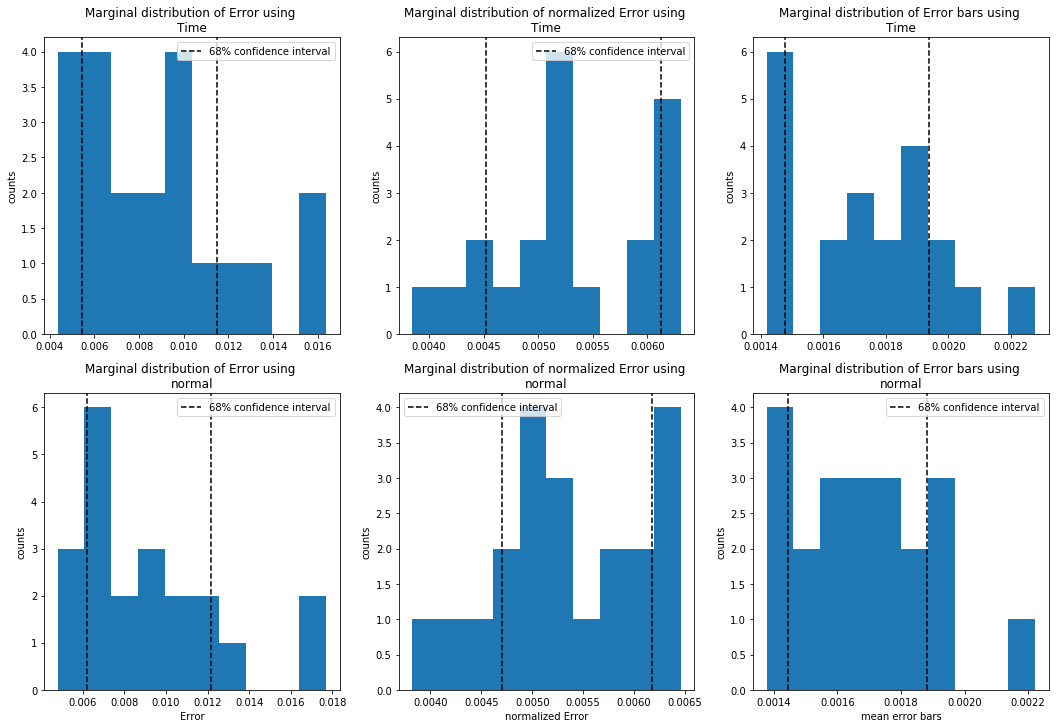

In [24]:
one = 'Time' #For 1st comparison
two = 'normal'
File_name1 = '/Users/chimamcgruder/Hydra/Copy0/GPTransmissionSpectra/outputs/WASP31/ut140222/LC114T/TstT' #unique path name of where the information is saved
File_name2 = '/Users/chimamcgruder/Hydra/Copy0/GPTransmissionSpectra/outputs/WASP31/ut140222/LC114N/TstN' #unique path name of where the information is saved
PCI = 68 # percent confidence interval
M_Err1, M_NorErr1, M_ErrBar1 = Stats(File_name1)
M_Err2, M_NorErr2, M_ErrBar2 = Stats(File_name2)
plt.figure(0, figsize = (18,12))

credible = np.percentile(M_Err1, [50-(PCI/2.0),50+(PCI/2.0)])
plt.subplot(231)
plt.ylabel('counts')
plt.hist(M_Err1)
plt.axvline(credible[0], 0, 1, color='k', linestyle='dashed', label=str(PCI)+'% confidence interval')
plt.axvline(credible[1], 0, 1, color='k', linestyle='dashed')
plt.title('Marginal distribution of Error using \n'+one)
print 'mean accuracy of '+one+'='+str(np.mean(M_Err1))+'+'+str(credible[0])+'-'+str(credible[1])
plt.legend()

credible = np.percentile(M_NorErr1, [50-(PCI/2.0),50+(PCI/2.0)])
plt.subplot(232)
plt.ylabel('counts')
plt.hist(M_NorErr1)
plt.axvline(credible[0], 0, 1, color='k', linestyle='dashed', label=str(PCI)+'% confidence interval')
plt.axvline(credible[1], 0, 1, color='k', linestyle='dashed')
plt.title('Marginal distribution of normalized Error using \n'+one)
print 'mean accuracy of Normalize '+one+'='+str(np.mean(M_NorErr1))+'+'+str(credible[0])+'-'+str(credible[1])
plt.legend()

credible = np.percentile(M_ErrBar1, [50-(PCI/2.0),50+(PCI/2.0)])
plt.subplot(233)
plt.ylabel('counts')
plt.hist(M_ErrBar1)
plt.axvline(credible[0], 0, 1, color='k', linestyle='dashed', label=str(PCI)+'% confidence interval')
plt.axvline(credible[1], 0, 1, color='k', linestyle='dashed')
plt.title('Marginal distribution of Error bars using \n'+one)
print 'mean precision of '+one+'='+str(np.mean(M_ErrBar1))+'+'+str(credible[0])+'-'+str(credible[1])
print '\n'
credible = np.percentile(M_Err2, [50-(PCI/2.0),50+(PCI/2.0)])
plt.subplot(234)
plt.xlabel('Error')
plt.ylabel('counts')
plt.hist(M_Err2)
plt.axvline(credible[0], 0, 1, color='k', linestyle='dashed', label=str(PCI)+'% confidence interval')
plt.axvline(credible[1], 0, 1, color='k', linestyle='dashed')
plt.title('Marginal distribution of Error using \n'+two)
print 'mean accuracy of '+two+'='+str(np.mean(M_Err2))+'+'+str(credible[0])+'-'+str(credible[1])
plt.legend()

credible = np.percentile(M_NorErr2, [50-(PCI/2.0),50+(PCI/2.0)])
plt.subplot(235)
plt.xlabel('normalized Error')
plt.ylabel('counts')
plt.hist(M_NorErr2)
plt.axvline(credible[0], 0, 1, color='k', linestyle='dashed', label=str(PCI)+'% confidence interval')
plt.axvline(credible[1], 0, 1, color='k', linestyle='dashed')
plt.title('Marginal distribution of normalized Error using \n'+two)
print 'mean accuracy of Normalized '+two+'='+str(np.mean(M_NorErr2))+'+'+str(credible[0])+'-'+str(credible[1])
plt.legend()

credible = np.percentile(M_ErrBar2, [50-(PCI/2.0),50+(PCI/2.0)])
plt.subplot(236)
plt.xlabel('mean error bars')
plt.ylabel('counts')
plt.hist(M_ErrBar2)
plt.axvline(credible[0], 0, 1, color='k', linestyle='dashed', label=str(PCI)+'% confidence interval')
plt.axvline(credible[1], 0, 1, color='k', linestyle='dashed')
plt.title('Marginal distribution of Error bars using \n'+two)
print 'mean precision of '+two+'='+str(np.mean(M_ErrBar2))+'+'+str(credible[0])+'-'+str(credible[1])
plt.legend()
plt.legend()
plt.show()

### 4) To look at the raw light curves and do some test with my data

In [2]:
pklLC = '/Users/chimamcgruder/Documents/GPs/PklLCs/commLC.pkl'
LC = pickle.load(open(pklLC,'r')) # to load the LC that was used, so get exact data
LC['cNames']

['comp4', 'comp1', 'comp3', 'comp2']

In [3]:
from decimal import Decimal
def CheckRawBins(LC, WantedCompNums = [0,2,3], BadIndecies = [], plotstyle = '-o'):
    Good_idx = np.arange(LC['oLCw'].shape[0])
    Good_idx = list(set(Good_idx).difference(BadIndecies))
    for i in range(LC['oLCw'].shape[1]):
        GoodCompSum = np.zeros(LC['oLCw'][Good_idx,:].shape[0])
        for comp_num in WantedCompNums:
            GoodCompSum += LC['cLCw'][Good_idx,comp_num,i] 
        Raw_LC = LC['oLCw'][Good_idx,i]/GoodCompSum
        Targ_Counts = np.sum(LC['oLCw'][Good_idx,i])
        Norm_Raw_LC = Raw_LC/np.mean(Raw_LC)
        plt.figure(i)
        plt.title('Bin mean of '+str(np.mean(LC['wbins'][i])))
        plt.plot(LC['t'][Good_idx], Norm_Raw_LC, plotstyle, label ='Tot Targ counts ='+'%.2E' % Decimal(str(Targ_Counts)))
        plt.legend()
    return None

In [4]:
LC['oLCw'].shape

(363, 50)

In [14]:
LC['cLCw'][:,3,1]

array([27915.54539386, 39641.07614202, 27173.24490253, 27993.11458111,
       27656.22031369, 28469.94989596, 27362.08025244, 27604.45459925,
       40570.20581471, 27889.52496634, 39884.93399222, 27740.16808194,
       28082.24367949, 27795.60161488, 27857.22733556, 27310.67077538,
       27489.56889362, 27754.05598621, 27087.25919615, 27662.14417637,
       27111.71521547, 27615.95297972, 27919.18210296, 27570.79961339,
       40762.28526194, 41029.95240183, 27327.03957856, 27736.57849128,
       27327.43241223, 23402.72936653, 23086.4137908 , 23187.38253953,
       37001.8693921 , 36705.66711543, 25226.75725057, 25565.97733203,
       25033.54020433, 37746.925437  , 36912.07270917, 25750.08531671,
       36229.91103019, 36535.68850546, 25261.92731373, 25502.82961637,
       25143.76566698, 24870.80244111, 36622.95666496, 12296.46380269,
       12727.89377189, 12748.38612038, 24033.60939492, 24535.69484122,
       25049.4567585 , 24474.27801972, 25235.97206056, 25129.03636486,
      

/Users/chimamcgruder/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in divide
  if __name__ == '__main__':
/Users/chimamcgruder/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in divide
  # This is added back by InteractiveShellApp.init_path()


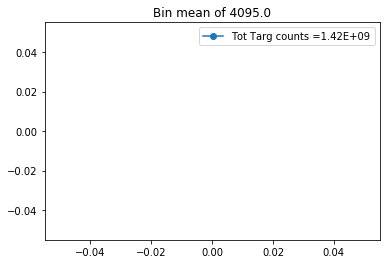

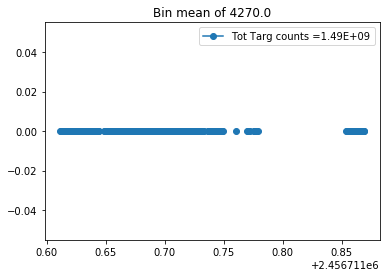

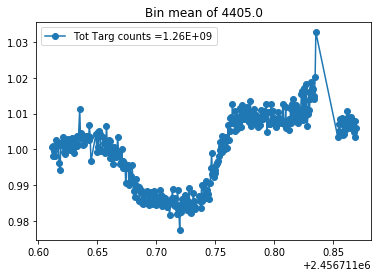

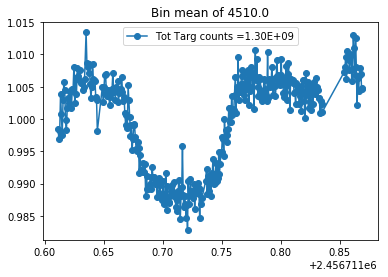

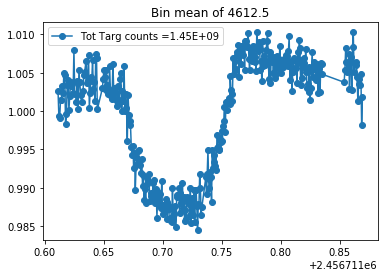

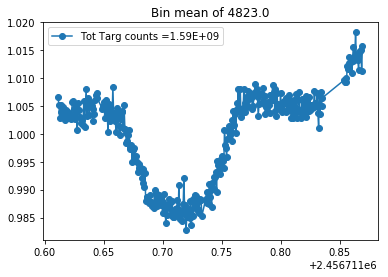

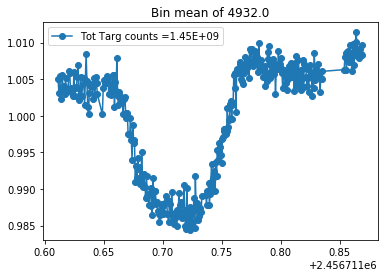

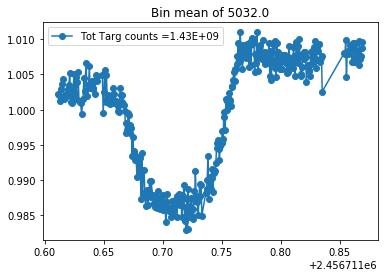

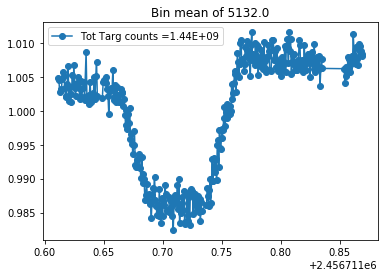

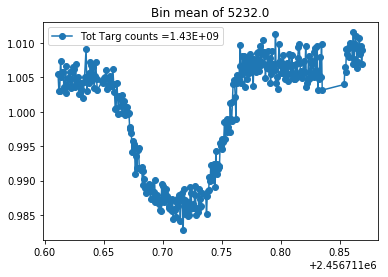

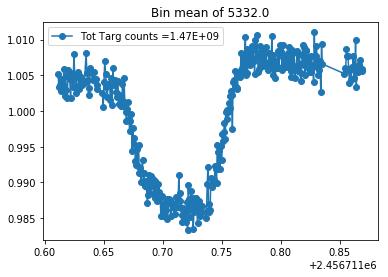

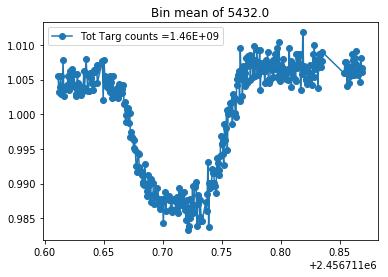

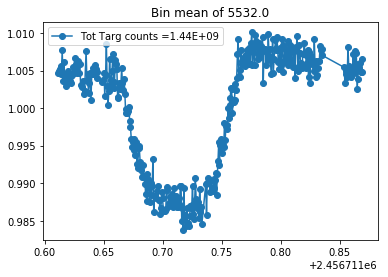

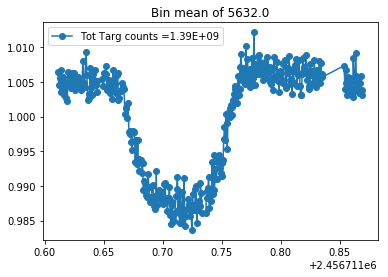

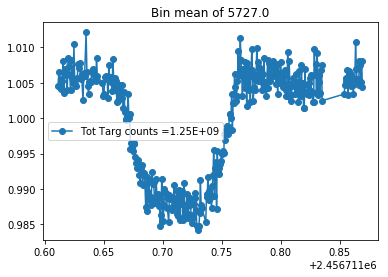

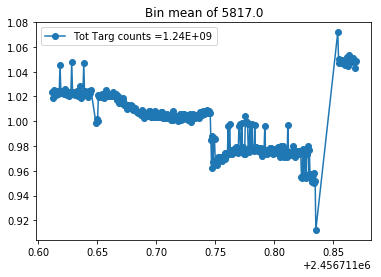

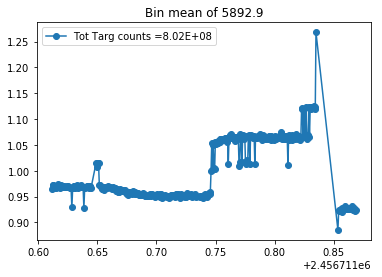

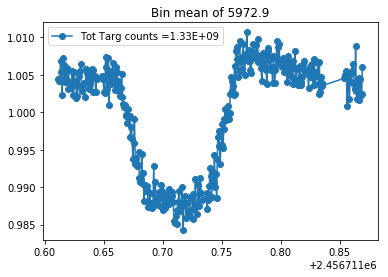

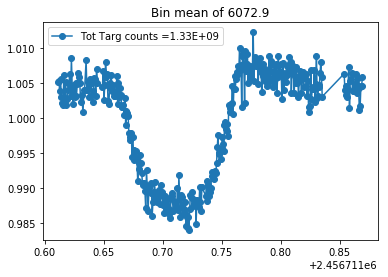

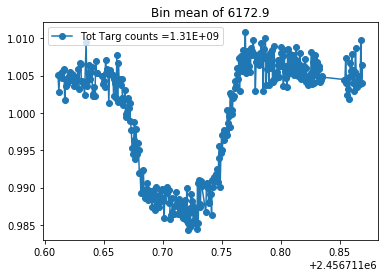

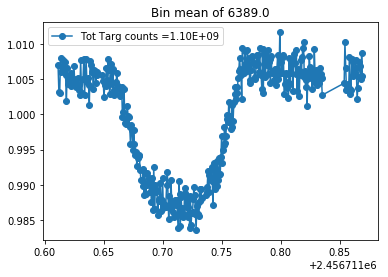

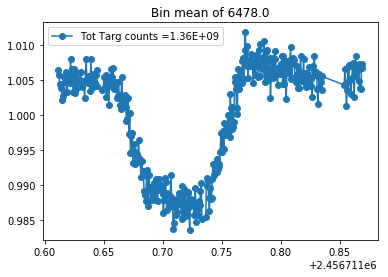

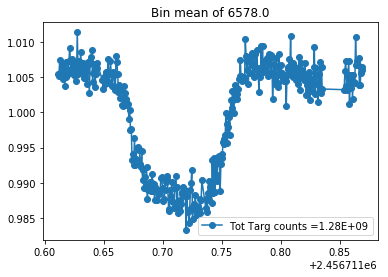

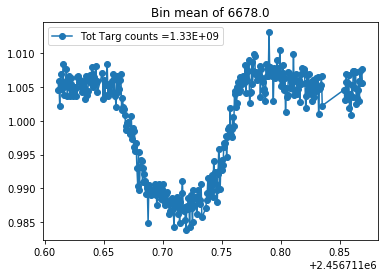

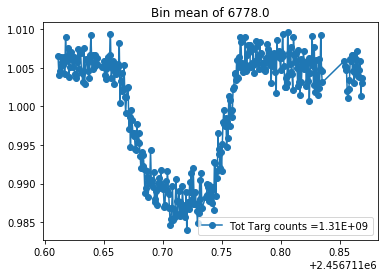

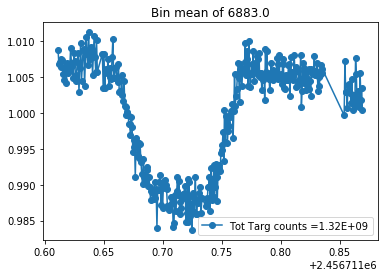

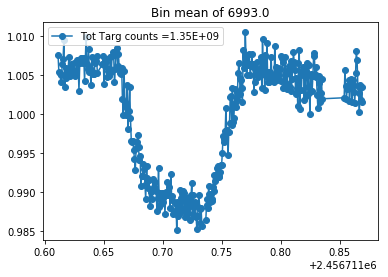

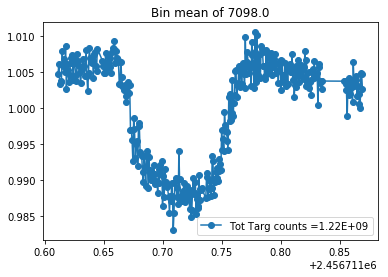

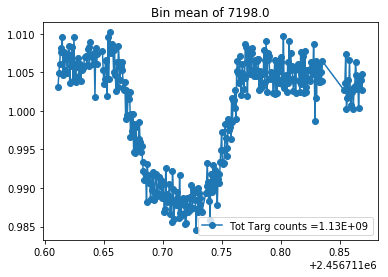

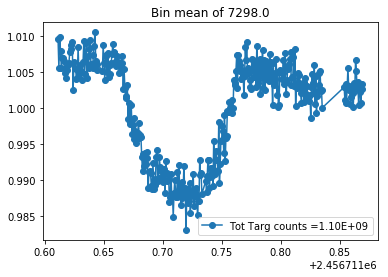

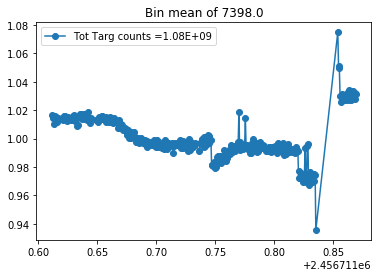

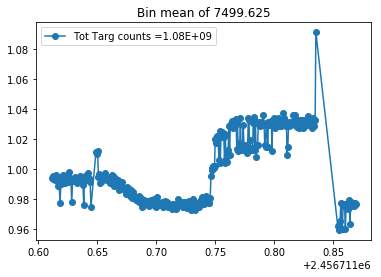

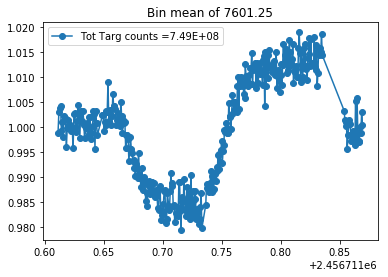

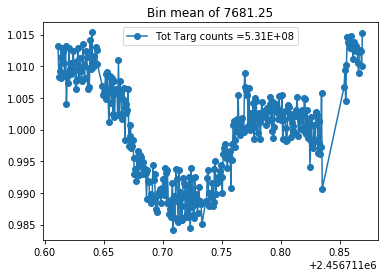

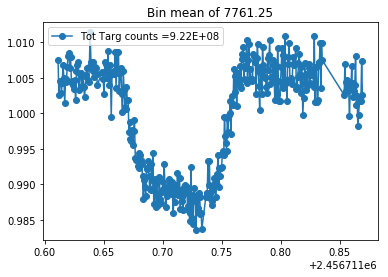

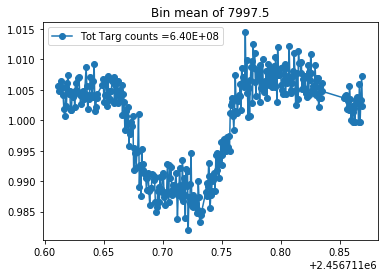

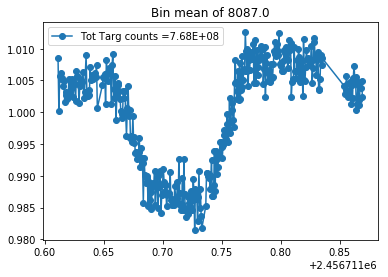

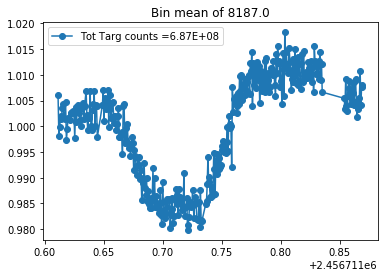

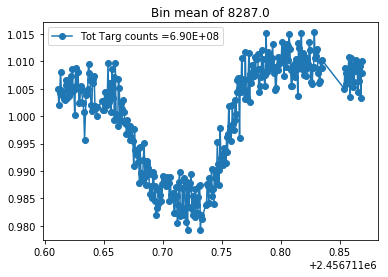

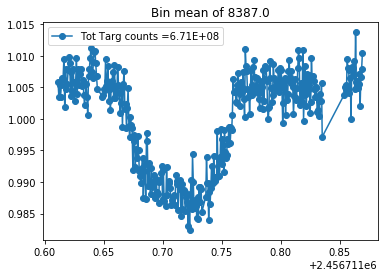

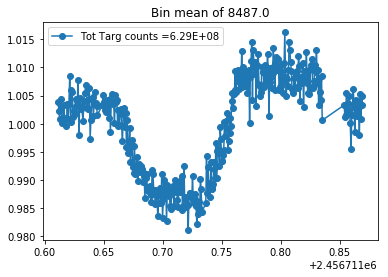

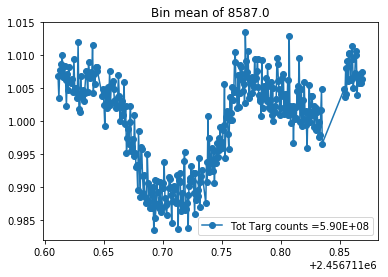

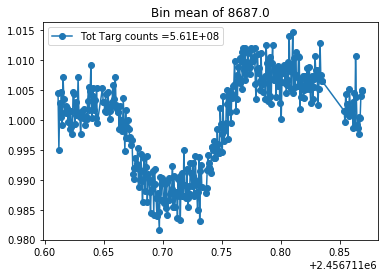

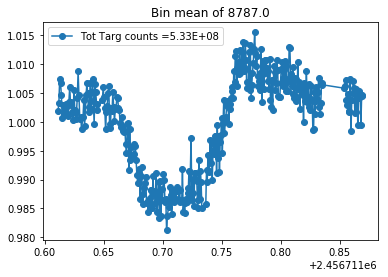

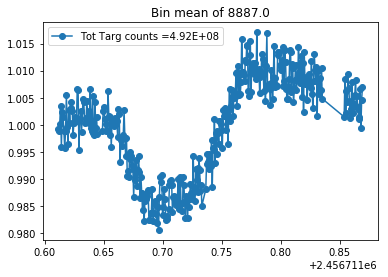

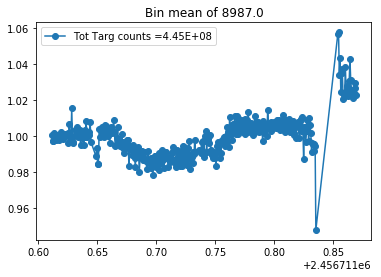

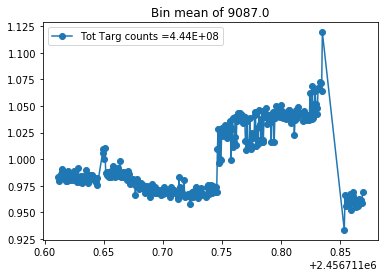

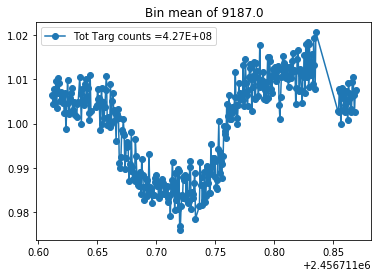

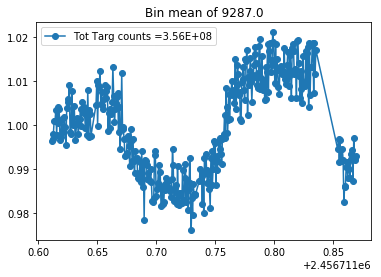

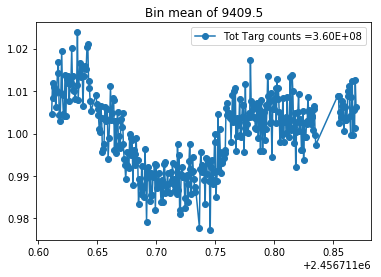

In [11]:
# pklLC = '/Users/chimamcgruder/Documents/GPs/PklLCs/commLC.pkl'
# LC = pickle.load(open(pklLC,'r')) # to load the LC that was used, so get exact data
CheckRawBins(LC, WantedCompNums = [3], plotstyle = '-o')
plt.show()
plt.close()

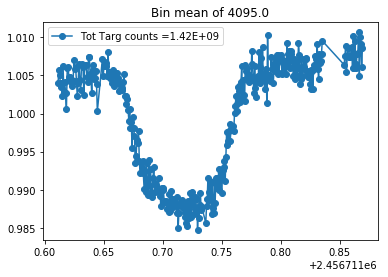

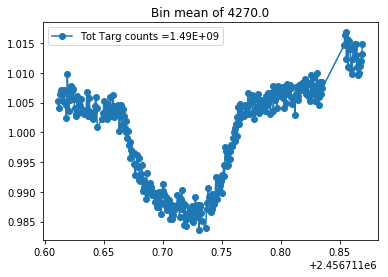

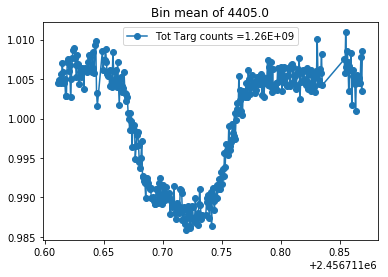

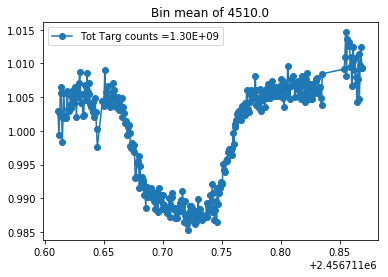

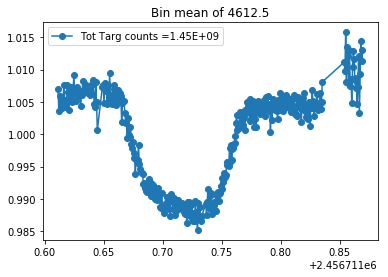

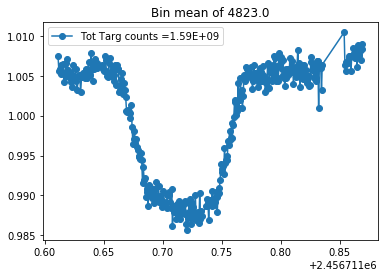

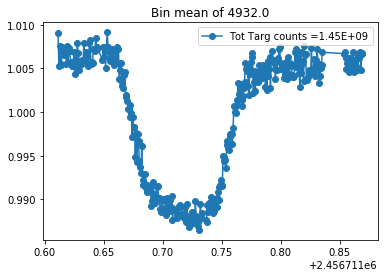

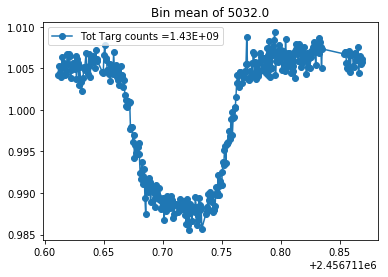

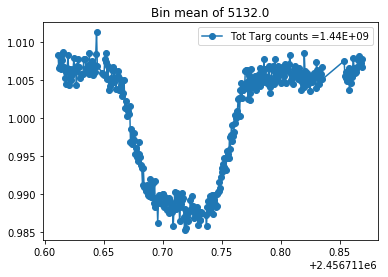

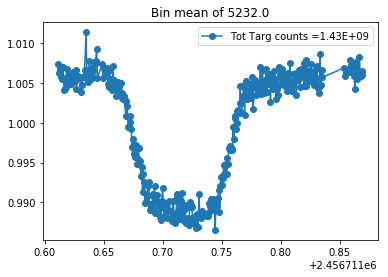

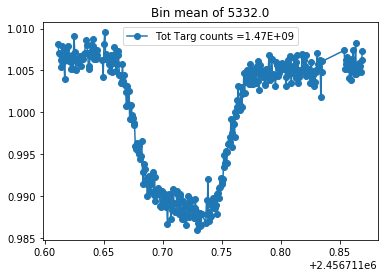

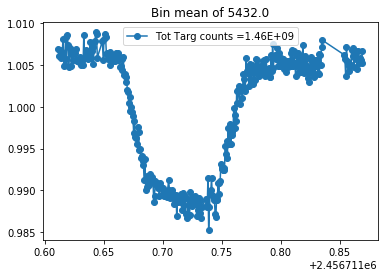

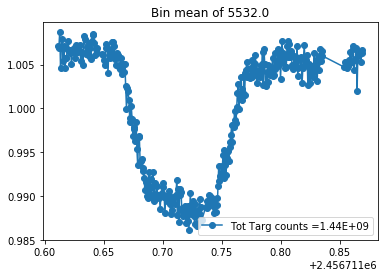

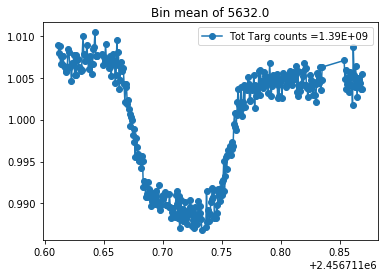

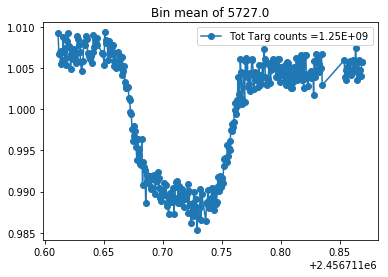

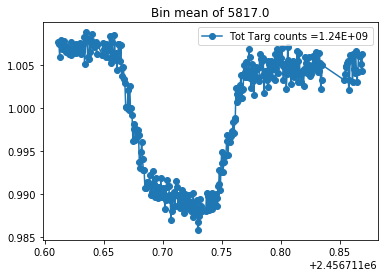

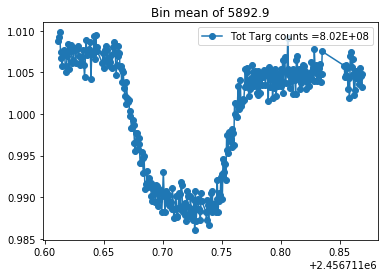

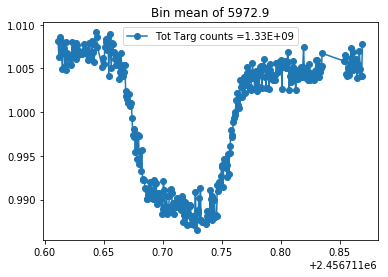

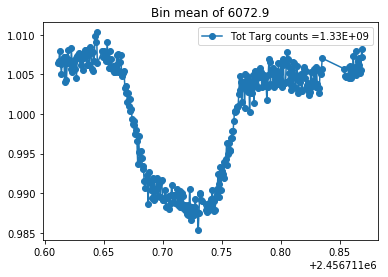

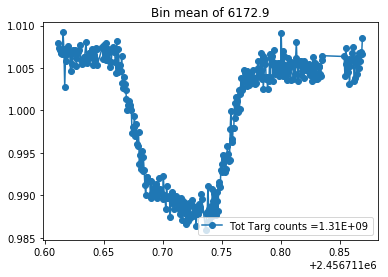

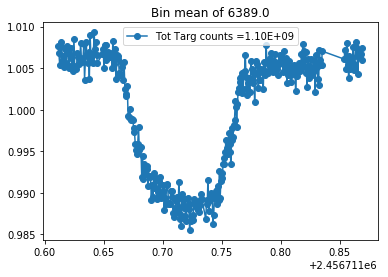

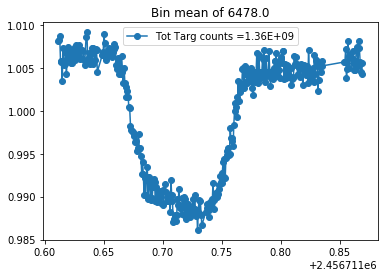

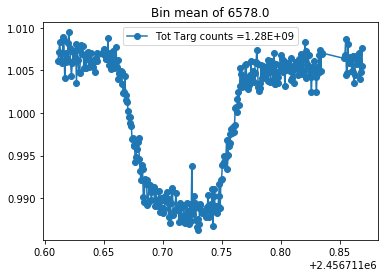

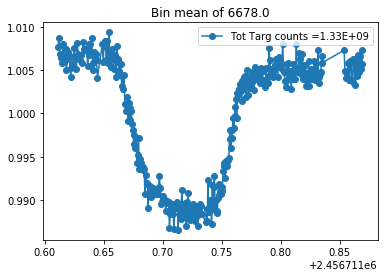

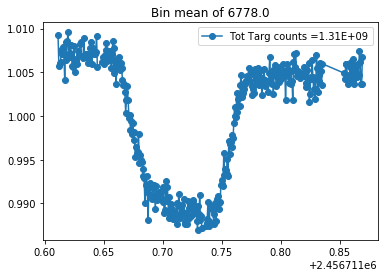

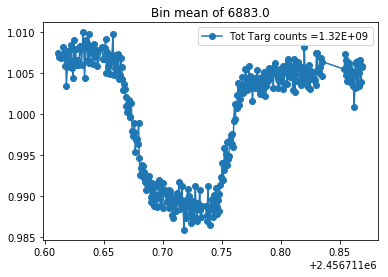

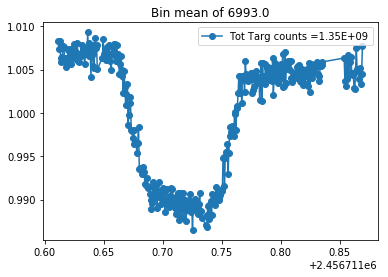

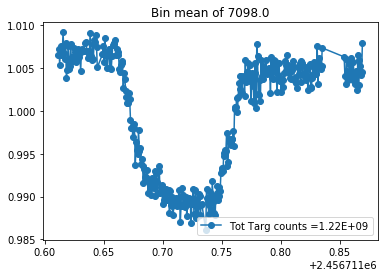

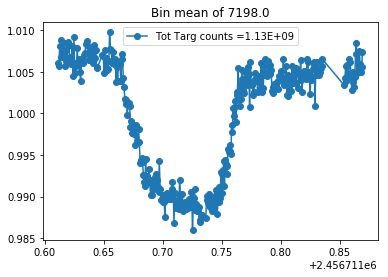

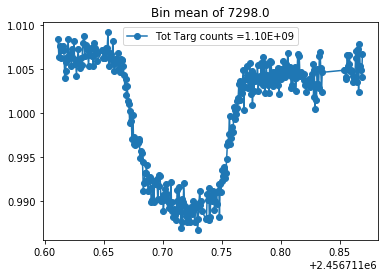

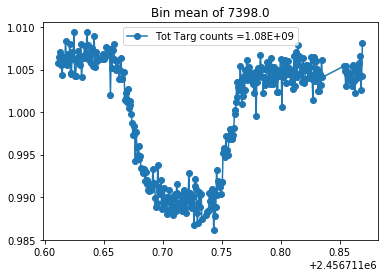

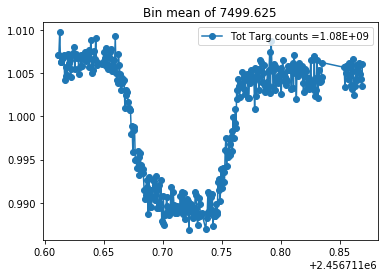

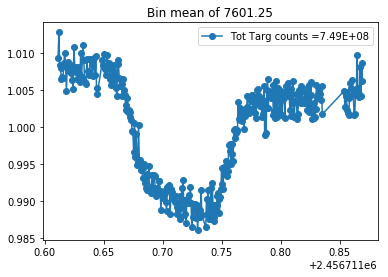

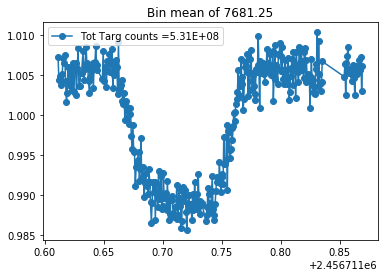

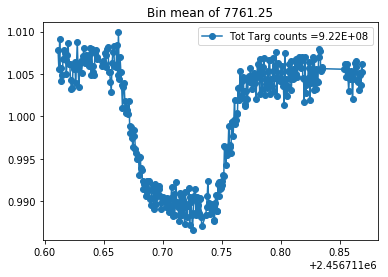

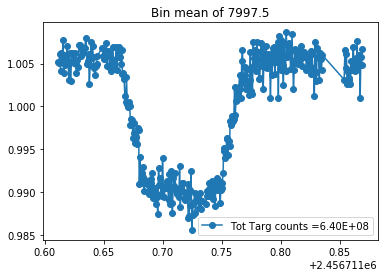

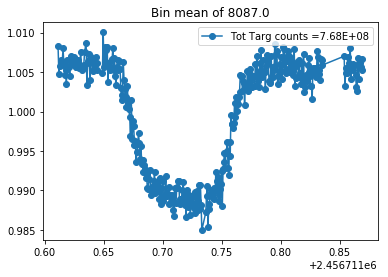

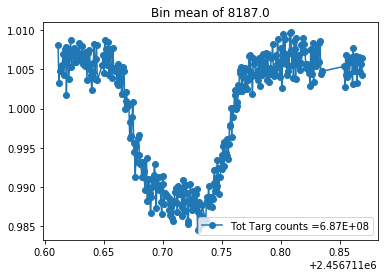

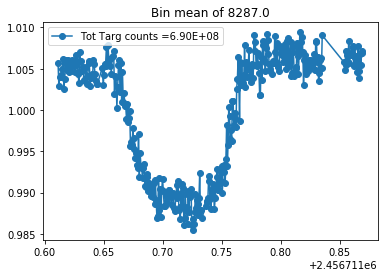

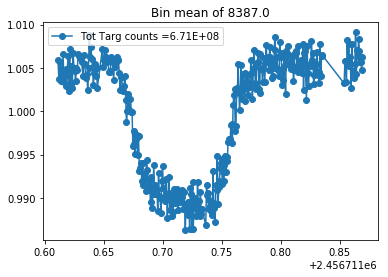

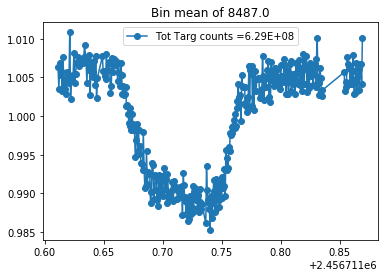

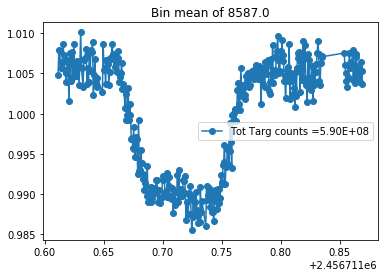

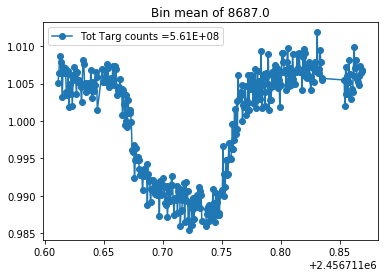

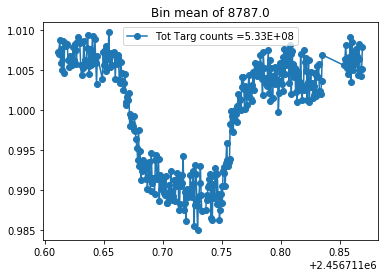

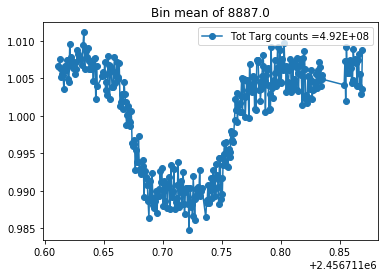

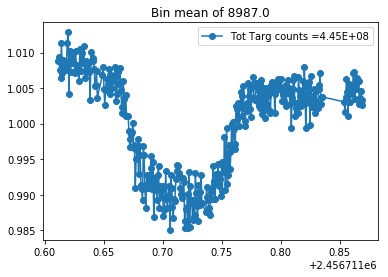

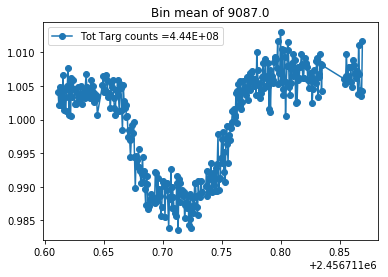

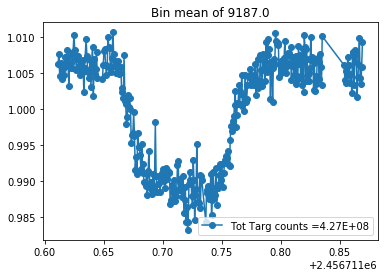

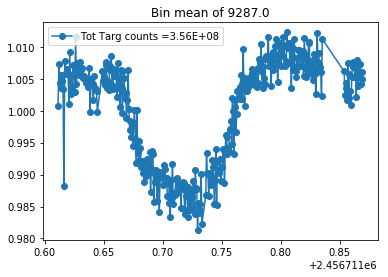

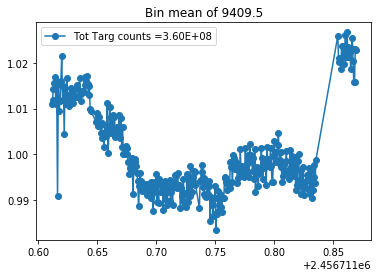

In [9]:
pklLC = '/Users/chimamcgruder/Documents/GPs/PklLCs/commLC.pkl'
LC = pickle.load(open(pklLC,'r')) # to load the LC that was used, so get exact data
CheckRawBins(LC, WantedCompNums = [1], plotstyle = '-o')
plt.show()
plt.close()

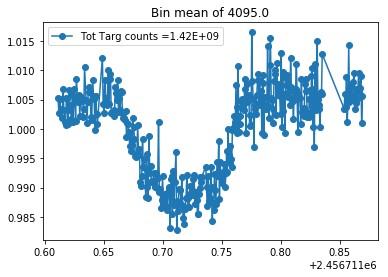

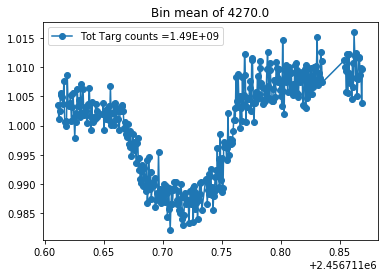

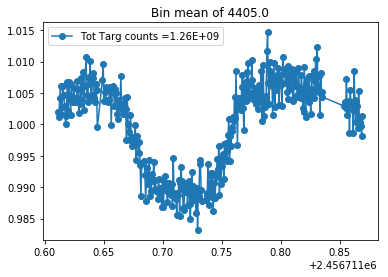

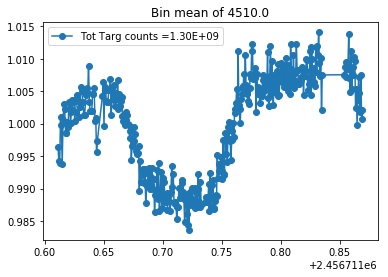

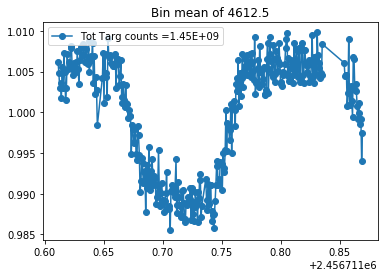

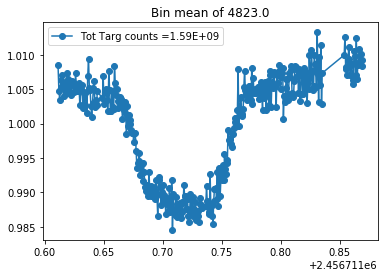

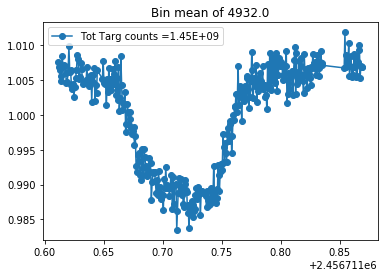

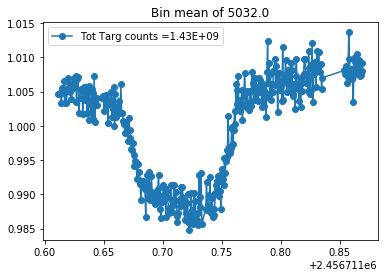

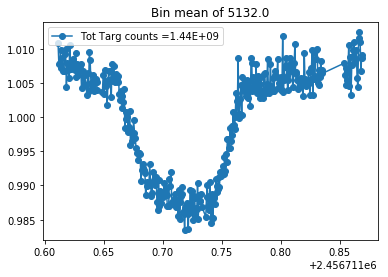

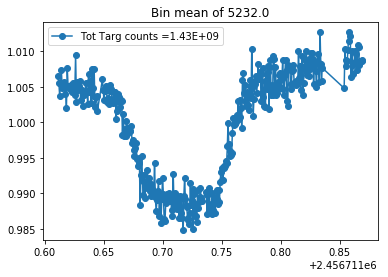

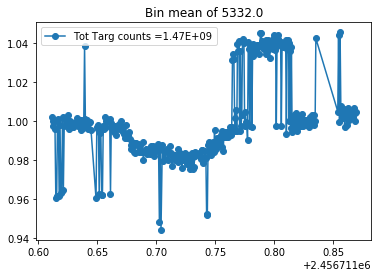

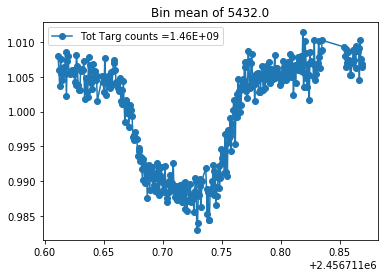

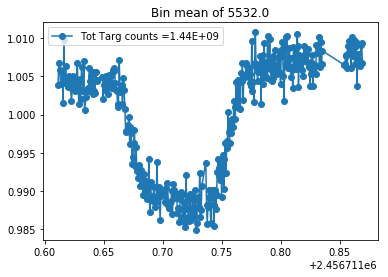

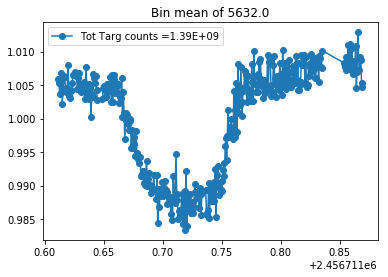

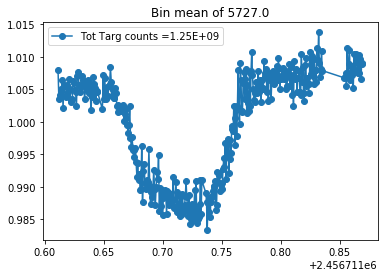

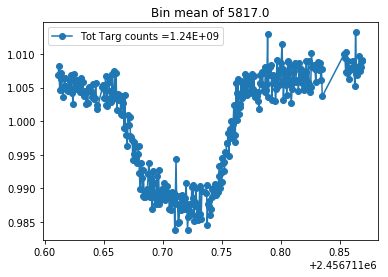

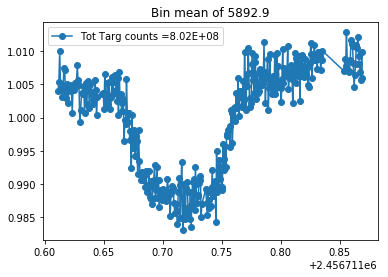

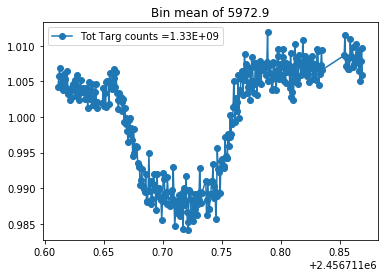

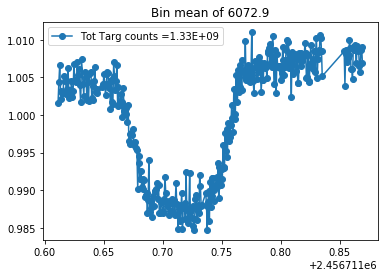

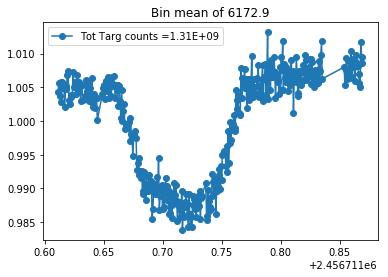

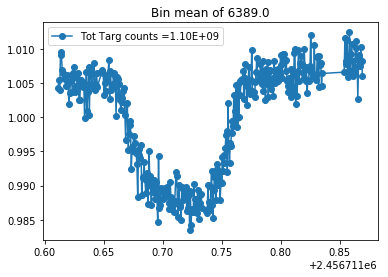

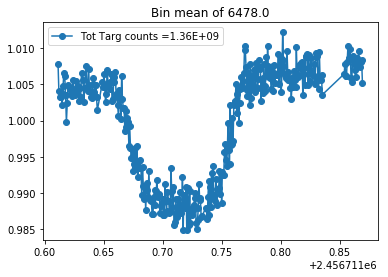

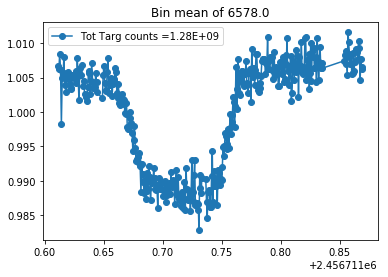

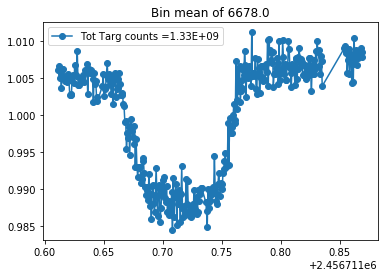

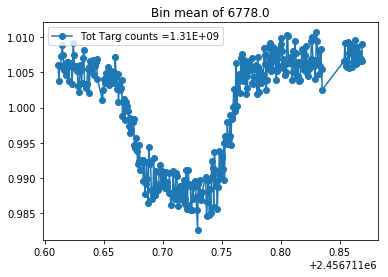

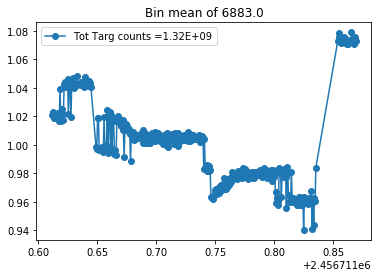

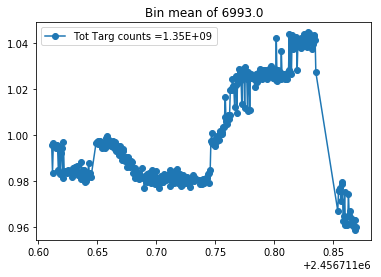

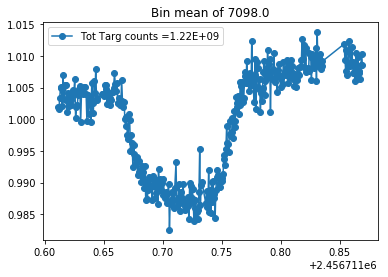

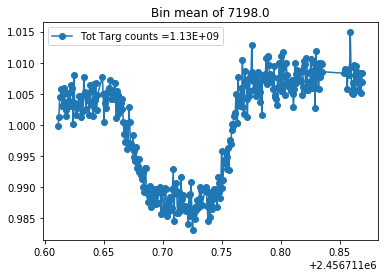

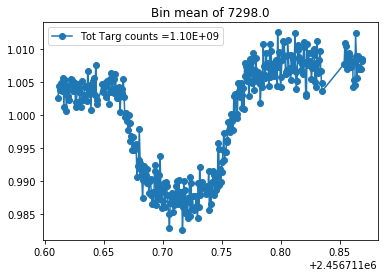

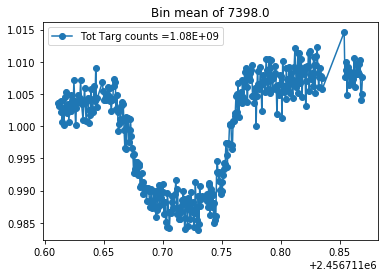

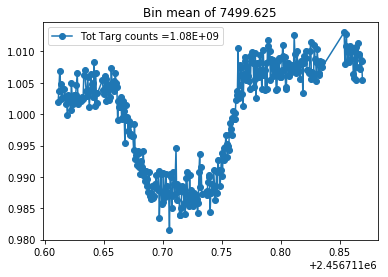

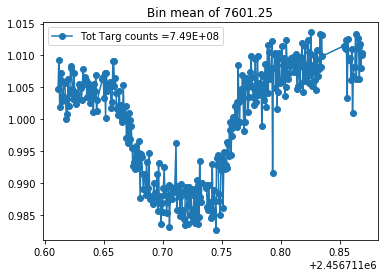

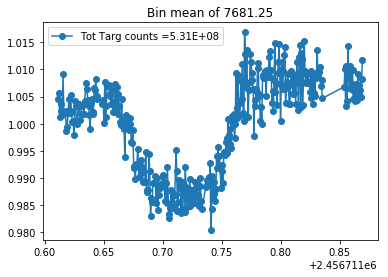

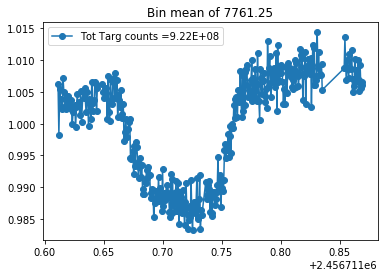

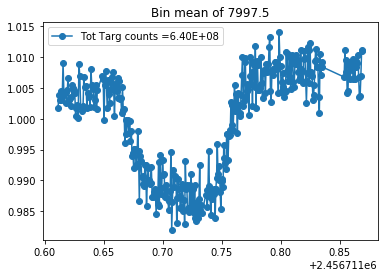

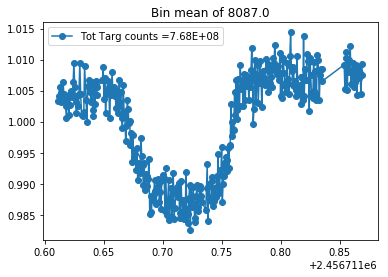

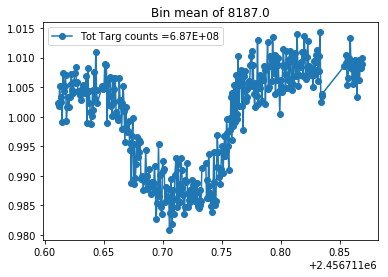

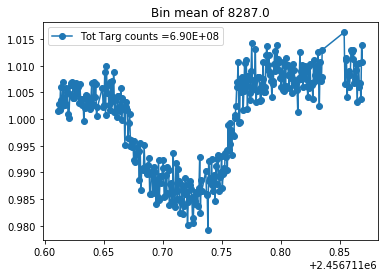

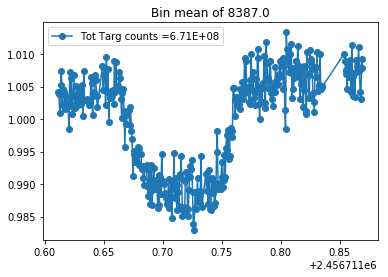

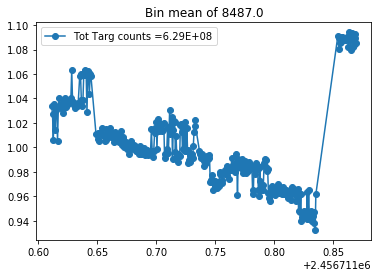

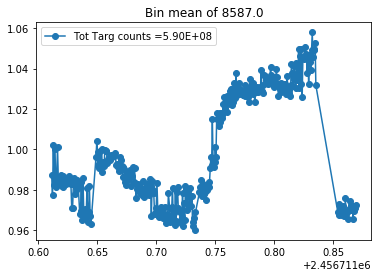

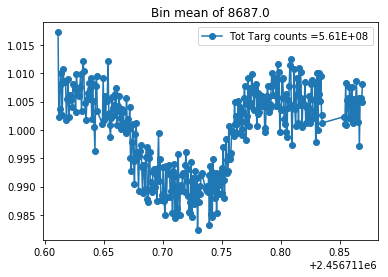

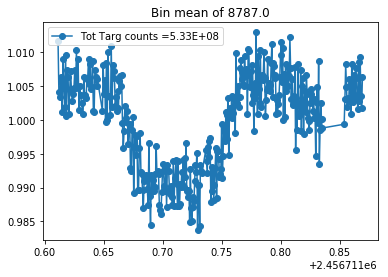

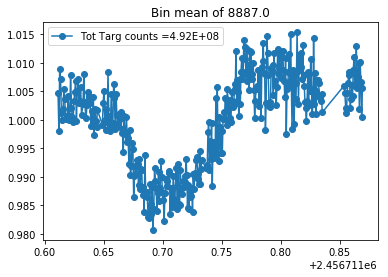

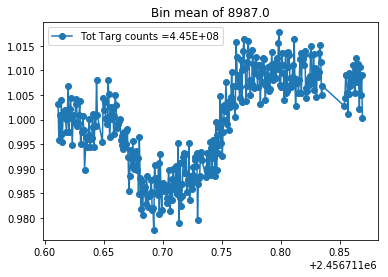

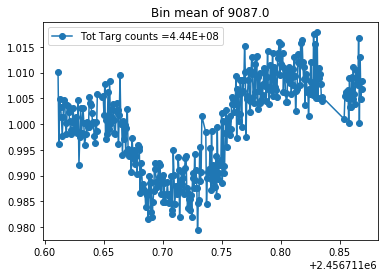

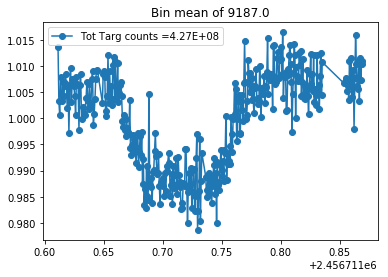

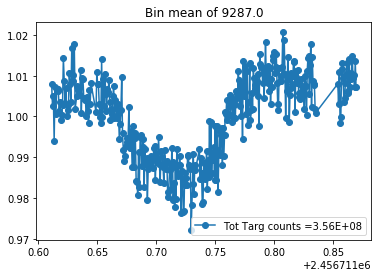

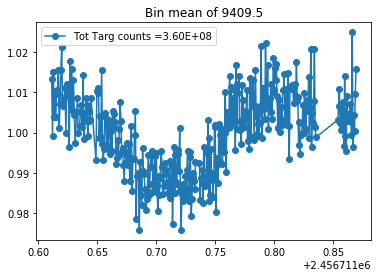

In [10]:
pklLC = '/Users/chimamcgruder/Documents/GPs/PklLCs/commLC.pkl'
LC = pickle.load(open(pklLC,'r')) # to load the LC that was used, so get exact data
CheckRawBins(LC, WantedCompNums = [0], plotstyle = '-o')
plt.show()
plt.close()

#### To check to see what the magnitude varition of the real and synthetic data is

In [36]:
TargWavLen = Raw_LC['oLCw']
for i in range(len(TargWavLen[0,:])):
    print i, np.var(TargWavLen[Good_idx,i]/np.mean(TargWavLen[idx_oot_2min,i])), np.mean(TargWavLen[Good_idx,i]), TargWavLen[Good_idx,i].shape

0 9.703899750432621e-05 9675852.11206227 (283,)
1 8.778638668063798e-05 11959018.999047201 (283,)
2 8.638447602650873e-05 15280611.951579286 (283,)
3 0.00023454772199209454 13138566.23979015 (283,)
4 7.61938680680243e-05 13847602.091476174 (283,)
5 8.035279299490664e-05 16211957.975494755 (283,)
6 8.101462798420226e-05 16278898.510900643 (283,)
7 7.889691538107747e-05 15815015.949557042 (283,)
8 7.82959615271469e-05 14974700.210434835 (283,)
9 8.309806352048628e-05 14293617.823640143 (283,)
10 8.418984944309567e-05 13897210.788171742 (283,)
11 0.00020820388867684615 9759107.860338315 (283,)
12 4.727646915284273e-05 12649589.917851241 (283,)
13 7.615869493326561e-05 13517126.221501341 (283,)
14 7.281198157849259e-05 12368460.963405019 (283,)
15 8.802124373424541e-05 10907585.77525172 (283,)
16 5.722701013131953e-05 10188494.49181062 (283,)
17 8.913367545970662e-05 7981316.272306138 (283,)
18 0.0001988716154389141 6497394.283585956 (283,)
19 5.9008749996367557e-05 6375065.513651566 (283,

In [96]:
def get_idx_oot_10min(e, aRs, inc, RpRs, r_s, w, period, t0, eps, t):
    """
    Returns conservative idx_oot, taking into account a 10-min
    buffer on either side of the predicted transit.
    """
    z0 = rsky(e, aRs, inc, r_s, w, period, t0, eps, t)
    idx_it = np.where(z0 < r_s+RpRs)[0]
#     print idx_it
    idx_ing, idx_egr = np.min(idx_it), np.max(idx_it)
    t_ing, t_egr = t[idx_ing], t[idx_egr]
    t1 = t_ing - 2 * (1/60.) * (1/24.)
    t2 = t_egr + 2 * (1/60.) * (1/24.)
    idx_1 = find_nearest_idx(t, t1)
    idx_2 = find_nearest_idx(t, t2)
    idx_oot_10min = np.append( np.arange(0, idx_1+1),  np.arange(idx_2, len(t)) )
    return idx_oot_10min

def find_nearest_idx(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx

In [106]:
from ext_func.rsky import rsky #think I need to install gcc or something like that to run in py37
Bad_frames = [0,1,285]
e =  0.0
aRs = 8.0 
inc = 1.473 
RpRs = 0.1271 #0.12464
r_s =  1.0
w = 1.5707963268
period =  3.4059096
t0 = 2456350.6907252003
eps = 1.0e-7
t = Raw_LC['t']
idx_oot_2min = get_idx_oot_2min(e, aRs, inc, RpRs, r_s, w, period, t0, eps, t)
idx_oot_2min = list(set(idx_oot_2min).difference(Bad_frames)) #To remove bad frames
print idx_oot_2min
print len(idx_oot_2min)

[2, 3, 4, 5, 6, 7, 8, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284]
141


For the actual data

In [105]:
# For actual data
TargWavLen = Raw_LC['oLCw']
for i in range(len(TargWavLen[0,:])):
    NormFlux = TargWavLen[idx_oot_2min,i]/np.mean(TargWavLen[idx_oot_2min,i])
    NfluxMaxChang = 1.0-(np.max(NormFlux)-np.min(NormFlux))
    print i, 1.0 - np.var(NormFlux),  NfluxMaxChang, (-np.log10(NfluxMaxChang)*2.51)*1000

0 0.9999747973515783 0.9768768026179977 25.50211012754697
1 0.9999786029421196 0.9787174572720609 23.450089528355456
2 0.9999806948881481 0.980562406737063 21.39715000175555
3 0.9999535428708984 0.9641629193538727 39.78243330086142
4 0.9999003343642507 0.9653147737157566 38.480928155807575
5 0.9999868888517963 0.9832247354384496 18.441482635999918
6 0.9999874188331427 0.9826725328566953 19.053869199887956
7 0.9999871804282005 0.9839828828343106 17.60126556712102
8 0.9999866528182865 0.9847367234235854 16.766463144244018
9 0.9999854711165362 0.9836664440408851 17.95188021079032
10 0.9999911688009405 0.9866586630649848 14.640997083046091
11 0.9999392101300139 0.9651159854705966 38.705432371734155
12 0.9999617768714767 0.9748413180778989 27.775840168154133
13 0.9999945730979776 0.9887769818059623 12.303147219114502
14 0.9999857993526667 0.9836893016513233 17.926550166029983
15 0.9999736080513144 0.9790076635781491 23.126910505631137
16 0.9999909647507981 0.9855912502763042 15.820933287550

In [95]:
print Good_idx

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 

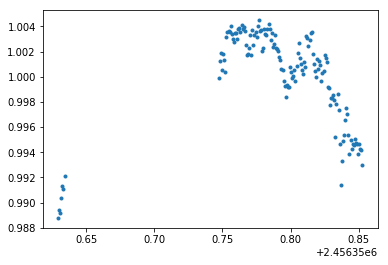

In [109]:
plt.plot(t[idx_oot_2min], Raw_LC['oLC'][idx_oot_2min]/np.mean(Raw_LC['oLC'][idx_oot_2min]), '.')

In [78]:
maxamp = np.max(Raw_LC['oLC'][idx_oot_2min]/np.mean(Raw_LC['oLC'])) - np.min(Raw_LC['oLC'][idx_oot_2min]/np.mean(Raw_LC['oLC']))    
print 1-maxamp
x=  1-np.var(Raw_LC['oLC'][idx_oot_2min]/np.mean(Raw_LC['oLC']))
print x
print (-np.log10(x)*2.51)*1000
print 10**((-0.01*1e-3)/2.51)

0.9842412365040902
0.9999870348906144
0.014133087031984355
0.999990826396


For the synthetic data

In [111]:
Times.shape

(283,)

In [112]:
idx_oot_2min = get_idx_oot_10min(e, aRs, inc, RpRs, r_s, w, period, t0, eps, Times)
print idx_oot_2min
print len(idx_oot_2min)

[  0   1   2   3   4   5   6 149 150 151 152 153 154 155 156 157 158 159
 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213
 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231
 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249
 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267
 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282]
141


In [80]:
LC_targ_withT.shape

(45, 283)

In [117]:
for i in range(len(LC_targ_withT[:,0])):
    NormFlux = LC_targ_withT[i,idx_oot_2min]/np.mean(LC_targ_withT[i,idx_oot_2min])
    NfluxMaxChang = 1.0-(np.max(NormFlux)-np.min(NormFlux))
    print i, 1.0 - np.var(NormFlux),  NfluxMaxChang, (-np.log10(NfluxMaxChang)*2.51)*1000

0 0.9997973000684813 0.9285745251266857 80.77992012485532
1 0.9996136262844716 0.9316915749493508 77.12685758753426
2 0.999230036678653 0.9097910827597563 103.05639370632059
3 0.9996426426978523 0.9193532790044718 91.65910224689384
4 0.9969154930126847 0.819091987638785 217.53497901571782
5 0.9999728480622074 0.9786546121131416 23.520087663594865
6 0.9999300946563738 0.9681780016138062 35.25242132767423
7 0.9999096745867673 0.9683096931913044 35.10415883841371
8 0.9998252142274626 0.9540674400247314 51.25652250480226
9 0.998539823270721 0.8377665491270616 192.96123087793563
10 0.9991702089288571 0.9038147654963825 110.24062552484851
11 0.9994449447471175 0.9238876811691221 86.29586723510842
12 0.9981327485494124 0.8145375692510802 223.61308817406152
13 0.9994908885147148 0.9231402510181139 87.17810410186556
14 0.9986543442725389 0.8498969620148595 177.29064512479565
15 0.9994798065298879 0.9269708618944508 82.66413195807141
16 0.9993054091220556 0.9156774708163595 96.02625219619799
17 

0.9839441055249815
283


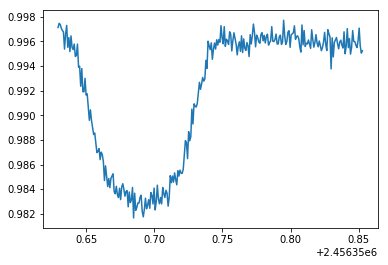

In [154]:
lcfile = '/Users/chimamcgruder/Hydra/Copy0/GPTransmissionSpectra/outputs/WASP31/ut130226/LC114T/Test0/wavelength-cmc/wbin0/lc_cmc.dat'
T, Mag, h = np.loadtxt(lcfile, unpack=True)
Flux = 10**(-Mag/2.51)
plt.plot(T, Flux)
print 1-(np.max(Flux)-np.min(Flux))
print len(Flux)

In [151]:
NfluxMaxChang = (np.max(Flux)-np.min(Flux))
print np.max(Flux), np.min(Flux)
NMagMaxChang = (np.max(Mag)-np.min(Mag))
print np.var(Flux),  NfluxMaxChang, (-np.log10(1-NfluxMaxChang)*2.51)*1000, NMagMaxChang*1000

1.0150052156679217 0.9834866396441118
0.00011826156660008153 0.03151857602380992 34.91084924836487 34.3865215


#### To check to see the difference in dy_min from standardizing the external parameters and not

In [19]:
def dy_min_max(Epar):
    DY = 0
    for dy in range(len(Epar)-1):
        DY += abs(Epar[dy]-Epar[dy+1])
    dy_min = DY/(dy+1)
    dy_max = 5*(np.max(Epar)-np.min(Epar))
    return dy_min, dy_max

LMIn, LMAx = dy_min_max(StrndAir)
print 'alphaMAx:', 1.0/LMIn, 'alphaMIn', 1.0/LMAx
LMIn, LMAx = dy_min_max(StrndDelWav)
print 'alphaMAx:', 1.0/LMIn, 'alphaMIn', 1.0/LMAx
LMIn, LMAx = dy_min_max(StrndFWHM)
print 'alphaMAx:', 1.0/LMIn, 'alphaMIn', 1.0/LMAx
LMIn, LMAx = dy_min_max(StrndSkyFlx)
print 'alphaMAx:', 1.0/LMIn, 'alphaMIn', 1.0/LMAx
LMIn, LMAx = dy_min_max(StrndTrcCen)
print 'alphaMAx:', 1.0/LMIn, 'alphaMIn', 1.0/LMAx

alphaMAx: 41.80574028132089 alphaMIn 0.053772857933217386
alphaMAx: 64.25813562304326 alphaMIn 0.0627835630942354
alphaMAx: 1.5393881581233768 alphaMIn 0.034456951190132507
alphaMAx: 3.2480235853296757 alphaMIn 0.04354425257024293
alphaMAx: 12.186075442943865 alphaMIn 0.05440391827265115


In [20]:
def dy_min_max(Epar):
    DY = 0
    for dy in range(len(Epar)-1):
        DY += abs(Epar[dy]-Epar[dy+1])
    dy_min = DY/(dy)
    dy_max = 5*(np.max(Epar)-np.min(Epar))
    return dy_min, dy_max

LMIn, LMAx = dy_min_max(StrndAir)
print 'alphaMAx:', 1.0/LMIn, 'alphaMIn', 1.0/LMAx
LMIn, LMAx = dy_min_max(StrndDelWav)
print 'alphaMAx:', 1.0/LMIn, 'alphaMIn', 1.0/LMAx
LMIn, LMAx = dy_min_max(StrndFWHM)
print 'alphaMAx:', 1.0/LMIn, 'alphaMIn', 1.0/LMAx
LMIn, LMAx = dy_min_max(StrndSkyFlx)
print 'alphaMAx:', 1.0/LMIn, 'alphaMIn', 1.0/LMAx
LMIn, LMAx = dy_min_max(StrndTrcCen)
print 'alphaMAx:', 1.0/LMIn, 'alphaMIn', 1.0/LMAx

alphaMAx: 41.65749297535876 alphaMIn 0.053772857933217386
alphaMAx: 64.03026989388353 alphaMIn 0.0627835630942354
alphaMAx: 1.5339293348676202 alphaMIn 0.034456951190132507
alphaMAx: 3.236505771197301 alphaMIn 0.04354425257024293
alphaMAx: 12.142862409458248 alphaMIn 0.05440391827265115
